# ML4N - Adversarial Attacks on Tabular Data Classifiers (group 34)

In [ ]:
!pip install kmodes tensorflow tqdm scipy keras-tuner adversarial-robustness-toolbox

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import math
import copy
from tqdm import tqdm

RANDOM_STATE = 50
GROUP_NUMBER = 34
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

2024-01-29 17:05:38.882528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 17:05:39.048252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-29 17:05:39.048301: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-29 17:05:39.932210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [5]:
# allow Keras-tuner compatibility with Python3.7
from functools import reduce
import operator

math.prod = lambda x: reduce(operator.mul, x, 1)

## 1 Data exploration and preprocessing

### 1.2 Data Preprocessing

In [6]:
columns = [
    "status_existing_checking_account",
    "duration_month",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_account_bonds",
    "present_employment_since",
    "installment_rate_perc_disposable_income",
    "personal_status_sex",
    "other_debtors_guarantors",
    "present_residence_since",
    "property",
    "age_years",
    "other_installment_plans",
    "housing",
    "number_existing_credits_bank",
    "job",
    "number_people_liable_provide_maintenance",
    "telephone",
    "foreign_worker",
    "label"
]

categorical_features = [
    "status_existing_checking_account",
    "credit_history",
    "purpose",
    "savings_account_bonds",
    "present_employment_since",
    "personal_status_sex",
    "other_debtors_guarantors",
    "property",
    "other_installment_plans",
    "housing",
    "job",
    "telephone",
    "foreign_worker"
]
non_categorical_features = list(set(columns).difference(categorical_features + ['label']))

translation =  {
    # status existing checking account (conto corrente)
    "A11": "negative", "A12": "low", "A13": "high", "A14": "not_present",
    # credit history
    "A30": "no_cred", "A31": "paid_back", "A32": "on_pair", "A33": "delay", "A34": "critical",
    # loan purpose
    "A40": "car_new", "A41": "car_used", "A42": "furniture", "A43": "radio/tv", "A44": "domestic", "A45": "repairs", "A46": "education", "A47": "vacation", "A48": "retraining", "A49" : "business", "A410": "other",
    # saving account (conto risparmio)
    "A61": "low", "A62": "medium", "A63": "med_high", "A64": "high", "A65": "unknown",
    # present employment since
    "A71": "unemployed", "A72": "less_1year", "A73": "less_4years", "A74": "less_7years", "A75": "more_7years",
    # personal status and sex
    "A91": "male_div", "A92": "female", "A93": "male_single", "A94": "male_married", "A95": "female_single",
    # other debtors or guarantors
    "A101": "none", "A102": "co-applicant", "A103": "guarantor",
     # property
    "A121": "real_estate", "A122": "building/society/savings/life_ins", "A123": "car/others", "A124": "unknown/no_prop",
    # other installment plans (piani rateali)
    "A141": "bank", "A142": "store", "A143": "none",
    # housing
    "A151": "rent", "A152": "own", "A153": "for_free",
    # job
    "A171": "unemp/unskilled", "A172": "unskilled_resident", "A173": "skilled_empl/off", "A174": "management/self_emp",
    # telephone
    "A191": "none", "A192": "yes",
    # foreign worker
    "A201": "yes", "A202": "no"
}

df = pd.read_csv(
    'dataset/german.data',
    delimiter=' ',
    header=None,
    names=columns
)
df

status_existing_checking_account  duration_month credit_history purpose  \
0                                A11               6            A34     A43   
1                                A12              48            A32     A43   
2                                A14              12            A34     A46   
3                                A11              42            A32     A42   
4                                A11              24            A33     A40   
..                               ...             ...            ...     ...   
995                              A14              12            A32     A42   
996                              A11              30            A32     A41   
997                              A14              12            A32     A43   
998                              A11              45            A32     A43   
999                              A12              45            A34     A41   

     credit_amount savings_account_bonds present_employment_since  \
0             1169                   A65                      A75   
1             5951                   A61                      A73   
2             2096                   A61                      A74   
3             7882                   A61                      A74   
4             4870                   A61                      A73   
..             ...                   ...                      ...   
995           1736                   A61                      A74   
996           3857                   A61                      A73   
997            804                   A61                      A75   
998           1845                   A61                      A73   
999           4576                   A62                      A71   

     installment_rate_perc_disposable_income personal_status_sex  \
0                                          4                 A93   
1                                          2                 A92   
2                                          2                 A93   
3                                          2                 A93   
4                                          3                 A93   
..                                       ...                 ...   
995                                        3                 A92   
996                                        4                 A91   
997                                        4                 A93   
998                                        4                 A93   
999                                        3                 A93   

    other_debtors_guarantors  ...  property age_years  \
0                       A101  ...      A121        67   
1                       A101  ...      A121        22   
2                       A101  ...      A121        49   
3                       A103  ...      A122        45   
4                       A101  ...      A124        53   
..                       ...  ...       ...       ...   
995                     A101  ...      A121        31   
996                     A101  ...      A122        40   
997                     A101  ...      A123        38   
998                     A101  ...      A124        23   
999                     A101  ...      A123        27   

     other_installment_plans housing number_existing_credits_bank   job  \
0                       A143    A152                            2  A173   
1                       A143    A152                            1  A173   
2                       A143    A152                            1  A172   
3                       A143    A153                            1  A173   
4                       A143    A153                            2  A173   
..                       ...     ...                          ...   ...   
995                     A143    A152                            1  A172   
996                     A143    A152                            1  A174   
997                     A143    A152             

The following processing operations are performed
1. One-Hot encoding of categorical features
2. MinMax Normalization in [0,1] range

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [9]:
df_processed = df.copy()
enc = OneHotEncoder()
enc.fit(df[categorical_features])
df_processed.drop(categorical_features, axis=1, inplace=True)
df_processed[enc.get_feature_names_out(categorical_features)] = enc.transform(df[categorical_features]).toarray()

mms = MinMaxScaler(feature_range=(0,1))
df_mms = df_processed.copy()
df_mms.loc[:, df_mms.columns != 'label'] = \
    mms.fit_transform(df_mms.loc[:, df_mms.columns != 'label'])

stds = StandardScaler()
df_stds = df_processed.copy()
df_stds.loc[:, df_stds.columns != 'label'] = \
    stds.fit_transform(df_stds.loc[:, df_stds.columns != 'label'])

categorical_features_hotencoded = df_processed.columns.tolist()
categorical_features_hotencoded = list(set(categorical_features_hotencoded).difference(non_categorical_features + ["label"]))

#### Train-Test split

In [10]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(
    df_mms.loc[:, df_mms.columns != 'label'],
    df_mms['label'],
    train_size=0.8,
    stratify=df_mms['label'],
    random_state=RANDOM_STATE
)

### 1.3 Exploratory Data Analysis

In [11]:
print(non_categorical_features)

enc.categories_

['age_years', 'present_residence_since', 'installment_rate_perc_disposable_income', 'duration_month', 'number_people_liable_provide_maintenance', 'credit_amount', 'number_existing_credits_bank']


[array(['A11', 'A12', 'A13', 'A14'], dtype=object),
 array(['A30', 'A31', 'A32', 'A33', 'A34'], dtype=object),
 array(['A40', 'A41', 'A410', 'A42', 'A43', 'A44', 'A45', 'A46', 'A48',
        'A49'], dtype=object),
 array(['A61', 'A62', 'A63', 'A64', 'A65'], dtype=object),
 array(['A71', 'A72', 'A73', 'A74', 'A75'], dtype=object),
 array(['A91', 'A92', 'A93', 'A94'], dtype=object),
 array(['A101', 'A102', 'A103'], dtype=object),
 array(['A121', 'A122', 'A123', 'A124'], dtype=object),
 array(['A141', 'A142', 'A143'], dtype=object),
 array(['A151', 'A152', 'A153'], dtype=object),
 array(['A171', 'A172', 'A173', 'A174'], dtype=object),
 array(['A191', 'A192'], dtype=object),
 array(['A201', 'A202'], dtype=object)]

_Non categorical features distribution and mean value analysis_

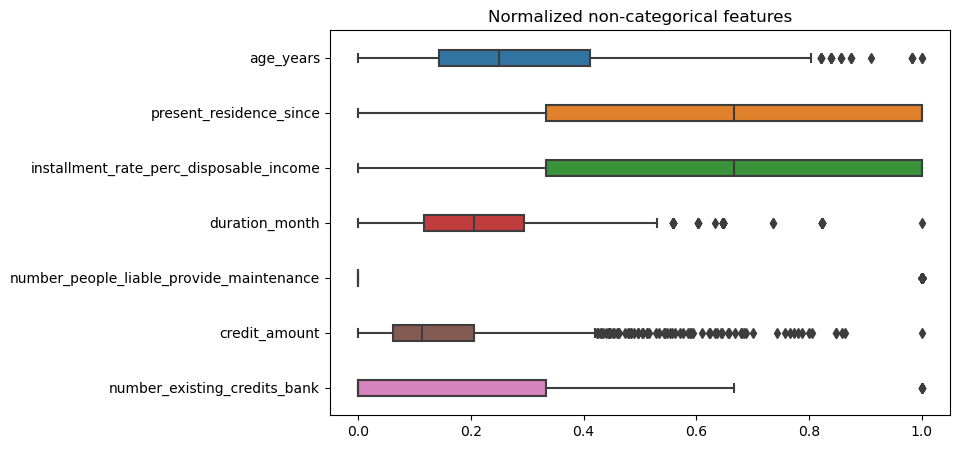

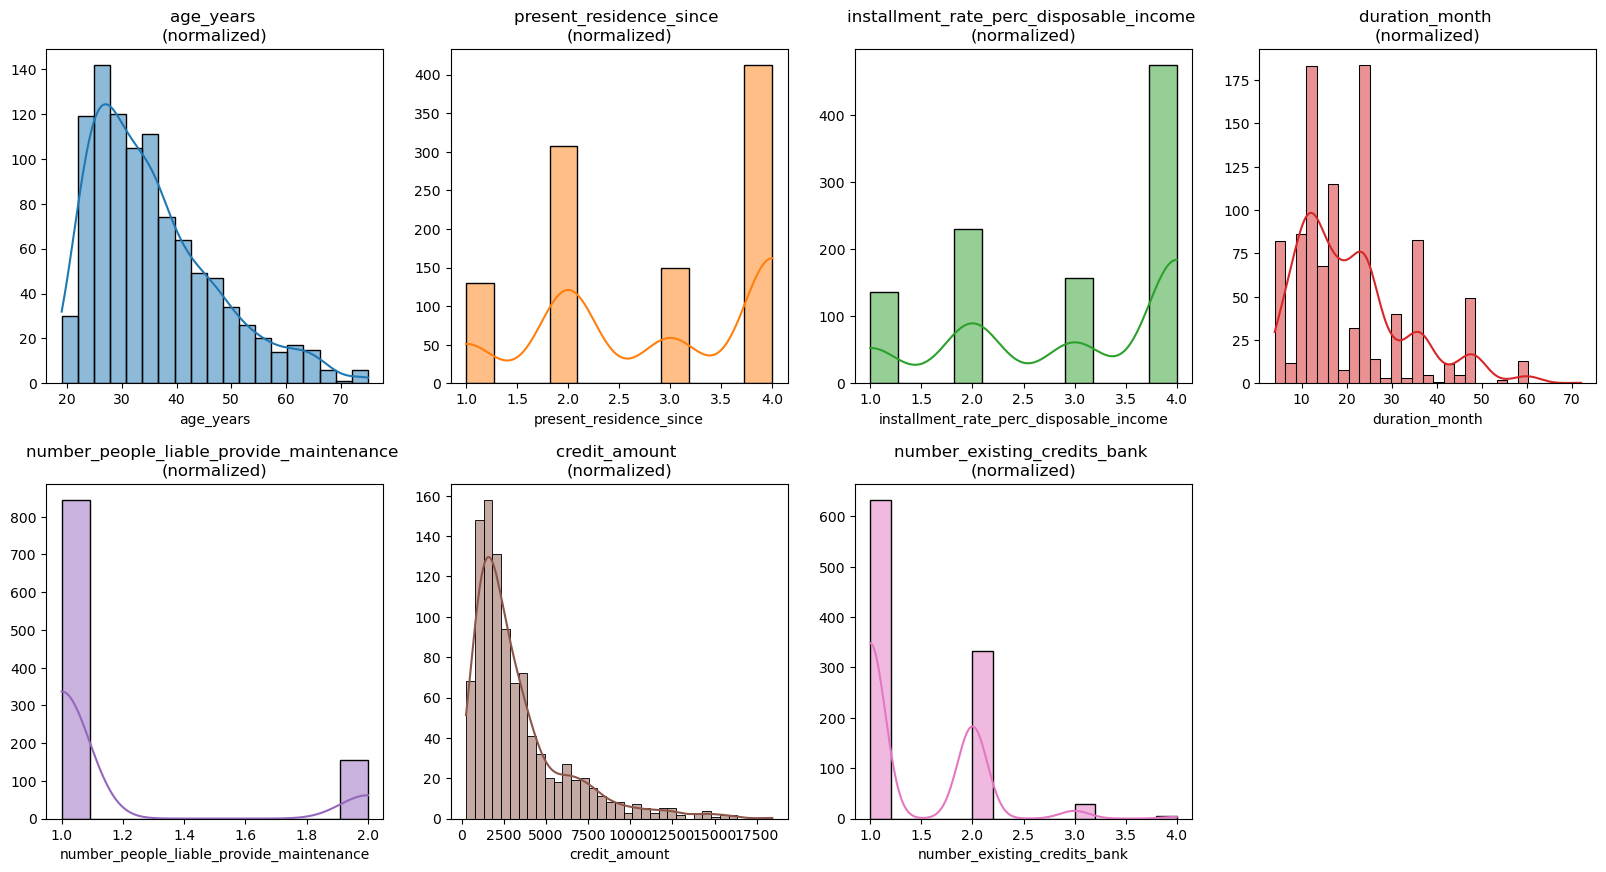

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(df_mms.loc[:,non_categorical_features], width=0.3, orient='horizontal')
plt.title('Normalized non-categorical features')
plt.show()

fig, axs = plt.subplots(2,4, figsize=(20,10))
for i, col in enumerate(non_categorical_features):
    ax = axs[i // 4][i % 4]
    sns.histplot(df_processed.loc[:,col], ax=ax, kde=True, color=sns.color_palette()[i])
    ax.set_title(f"{col} \n(normalized)")
    ax.set_ylabel("")
axs[1][3].remove()
plt.subplots_adjust(hspace=0.3)
plt.show()

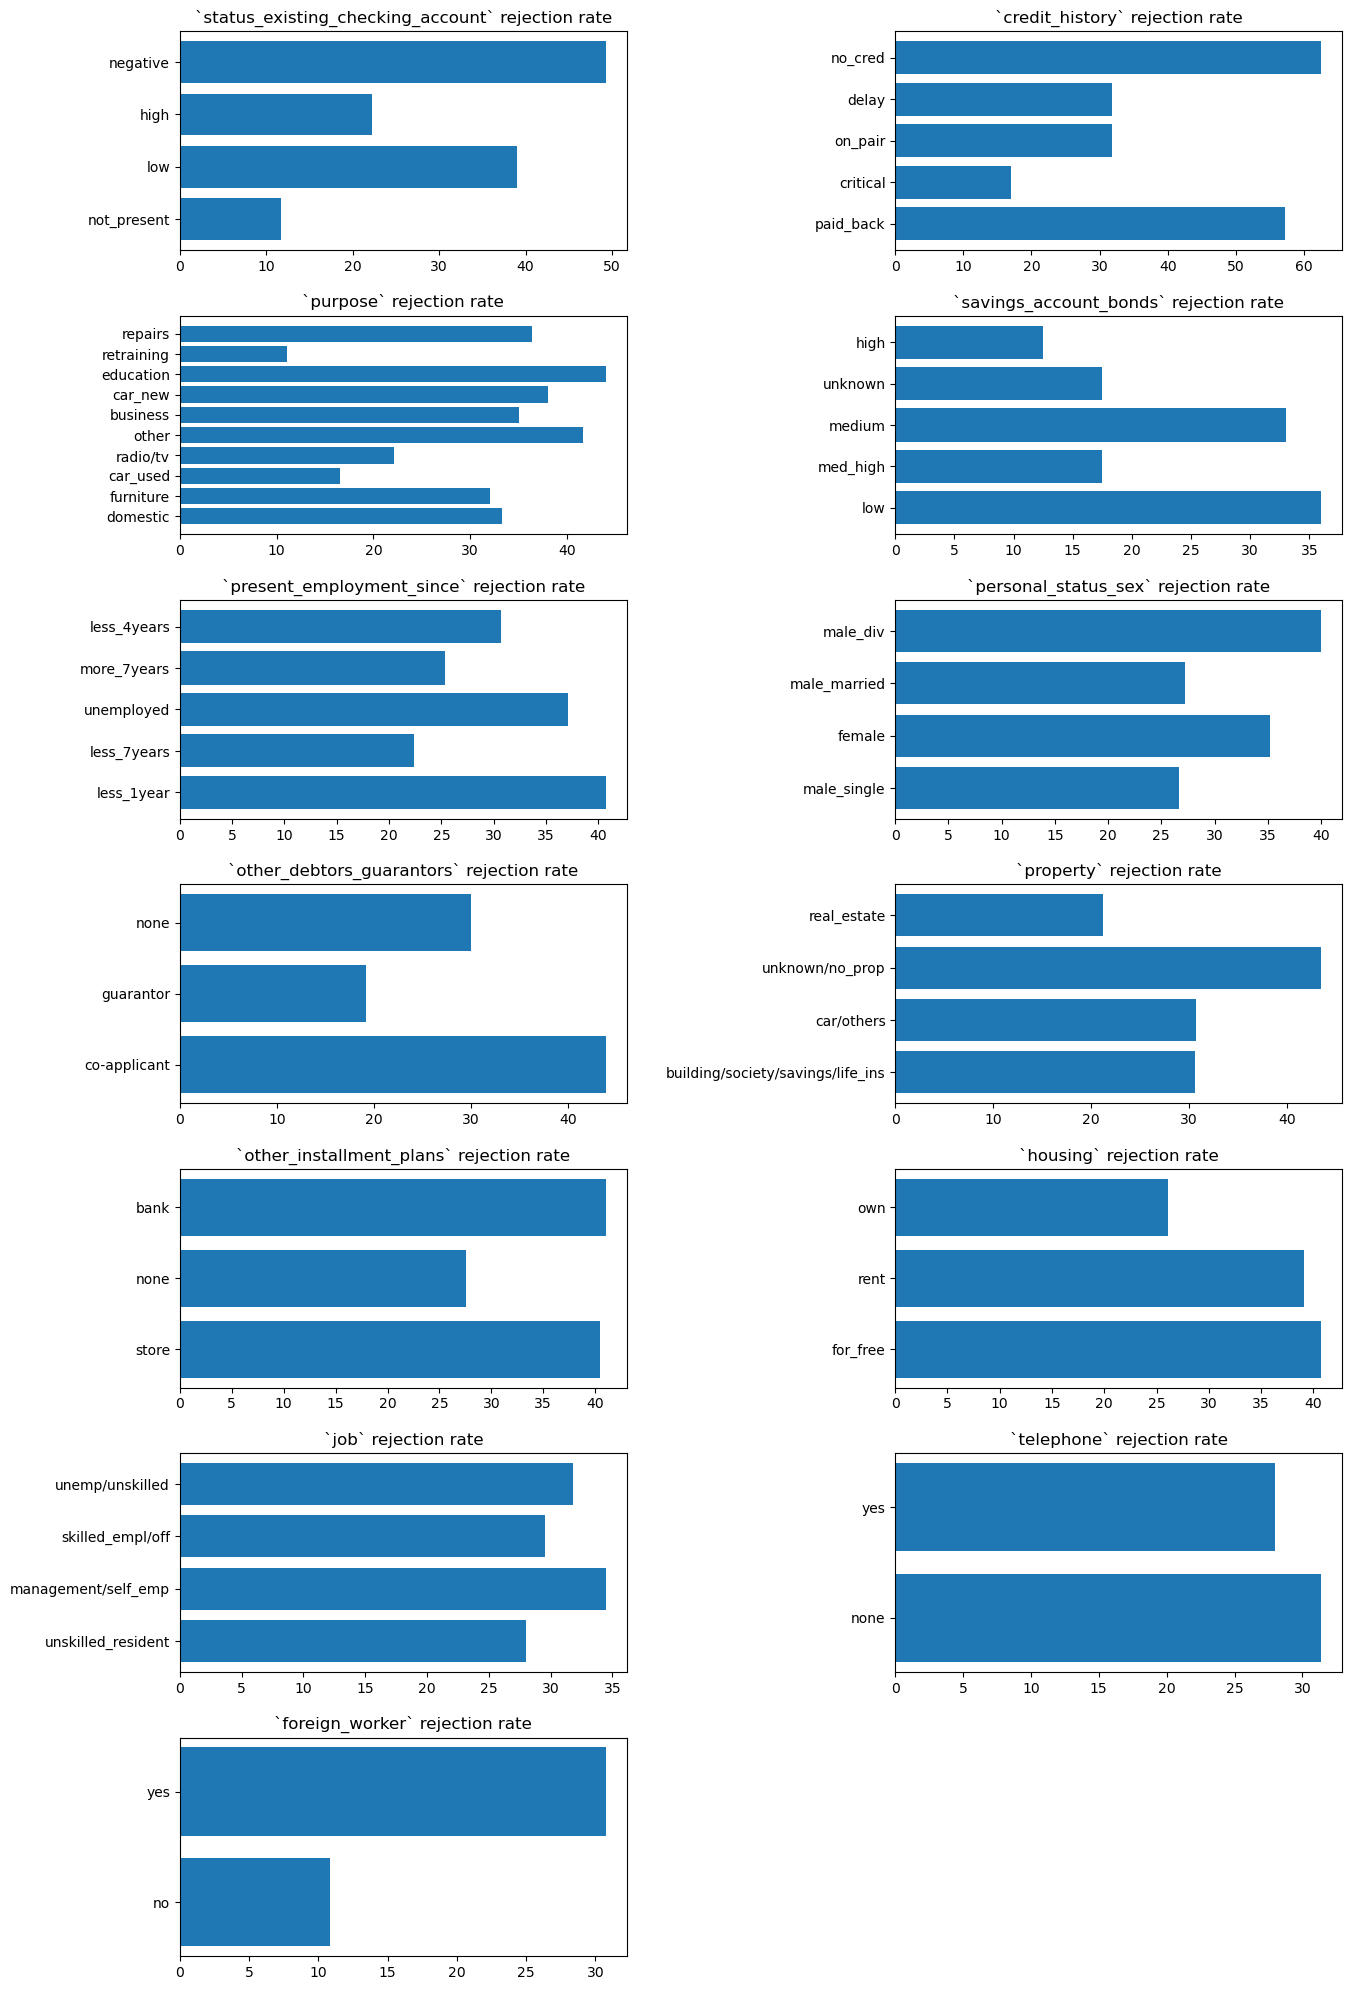

In [14]:
rejection_rates = {}
for col in categorical_features_hotencoded:
    tmp = df_processed[df_processed[col] == 1]
    tot = tmp.size
    neg = tmp[tmp["label"] == 2].size
    rate = neg/tot * 100
    rejection_rates[col] = rate

fig, axs = plt.subplots(len(categorical_features)//2+1,2, figsize=(15,25))
for i, col in enumerate(categorical_features):
    rr = list(filter(lambda x: x[0].startswith(col), rejection_rates.items()))
    axs[i//2][i%2].barh(y=[translation[x[0].split(col)[1][1:]] for x in rr], width=[x[1] for x in rr])
    axs[i//2][i%2].set_title(f"`{col}` rejection rate")
plt.subplots_adjust(hspace=.3, wspace=.6)
axs[-1][-1].remove()
plt.show()

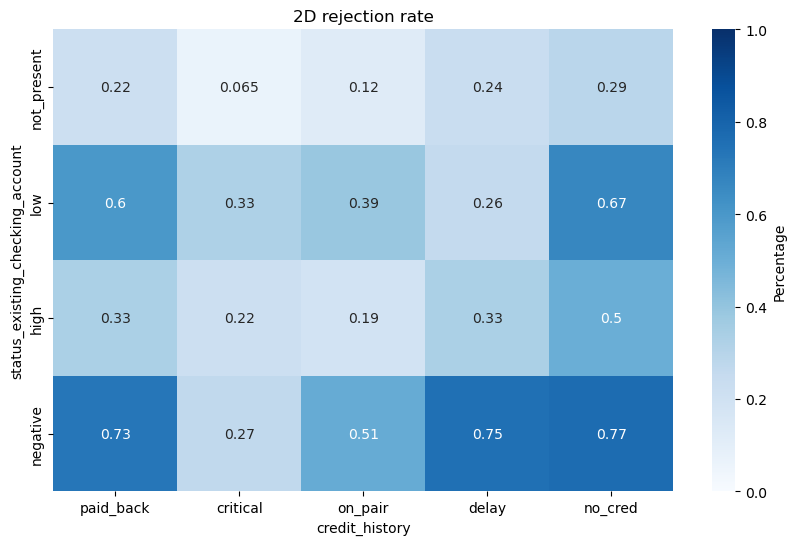

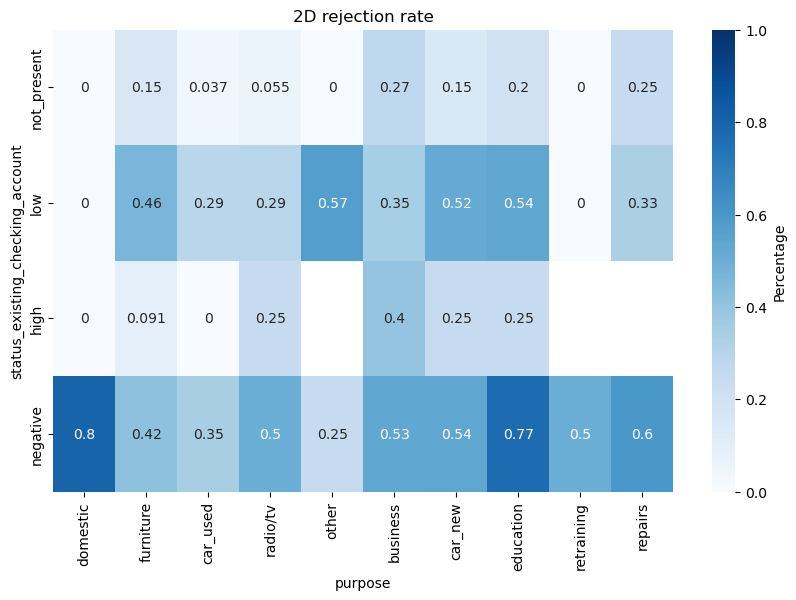

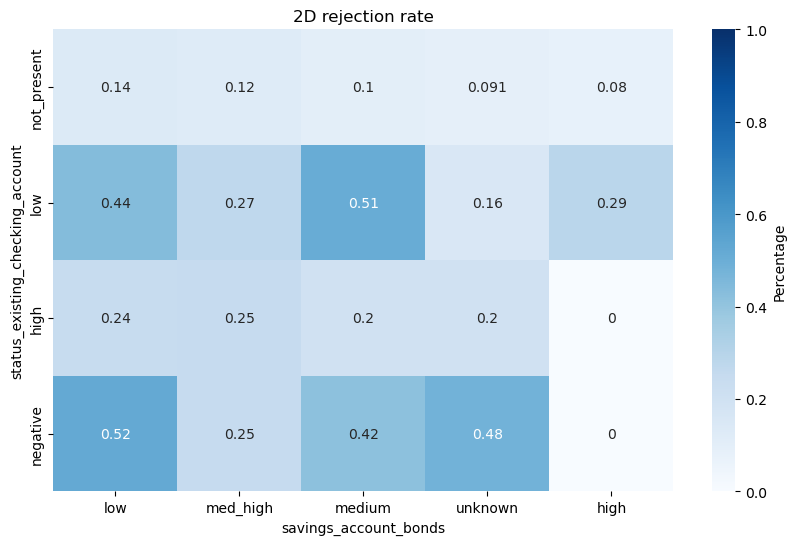

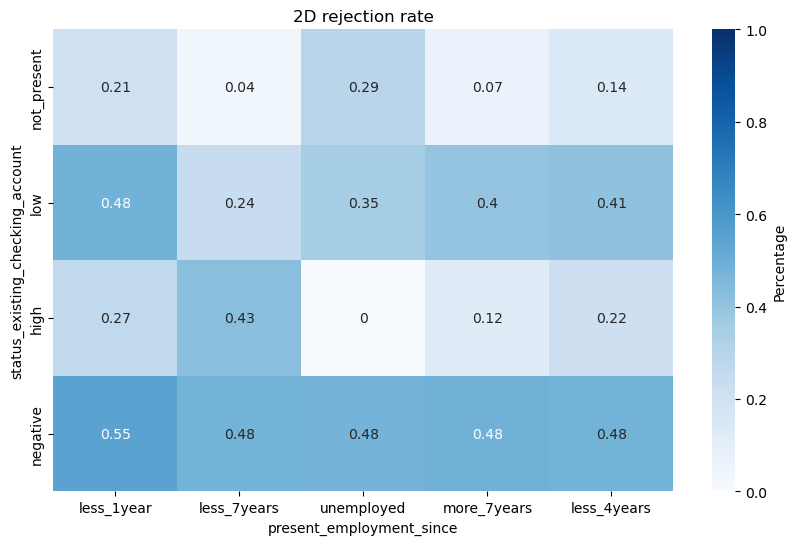

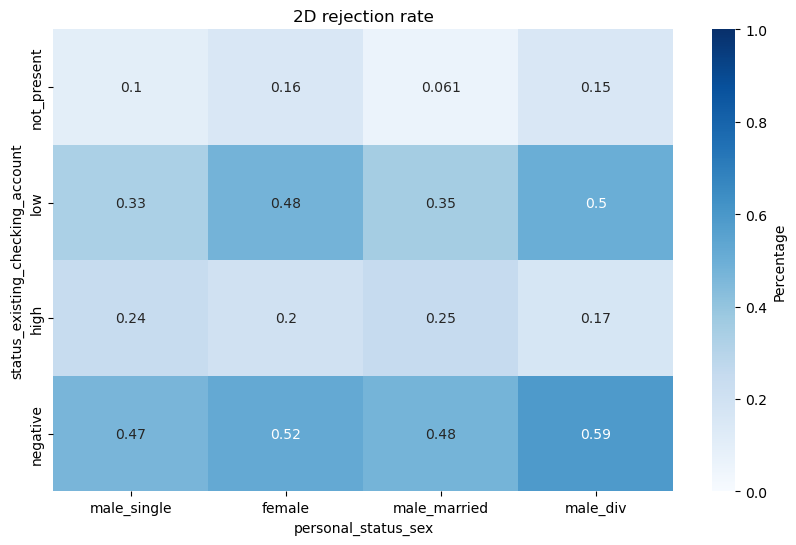

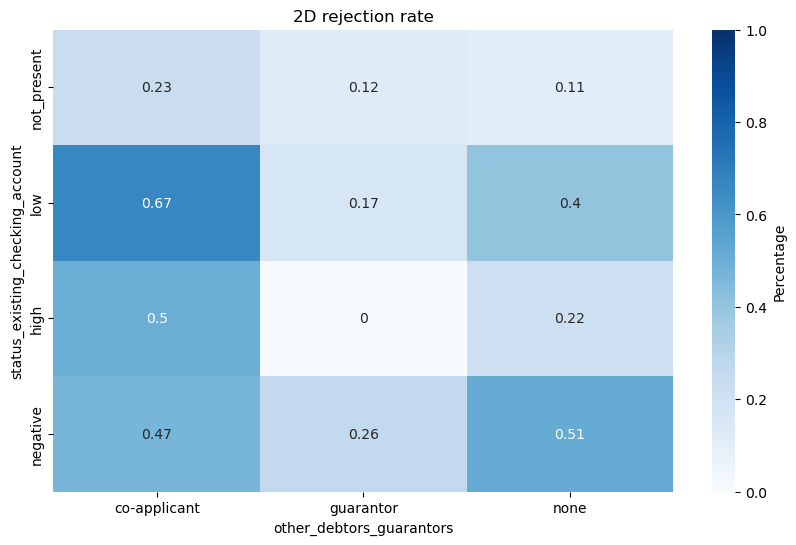

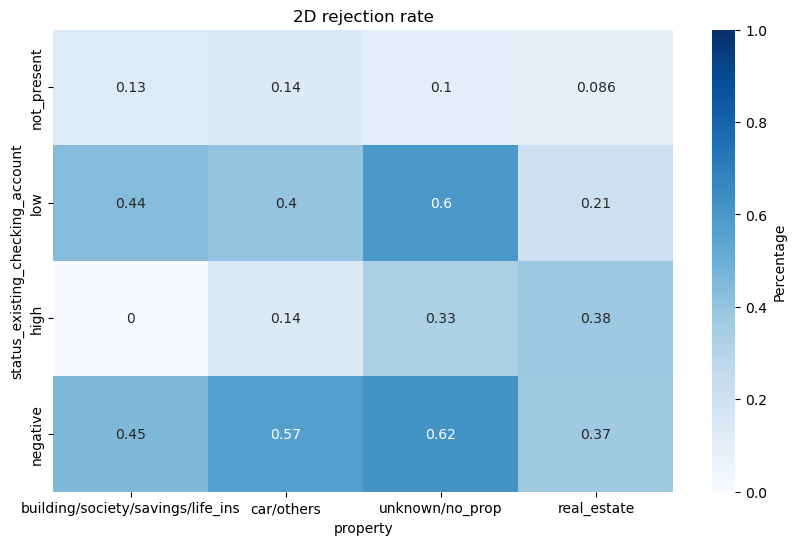

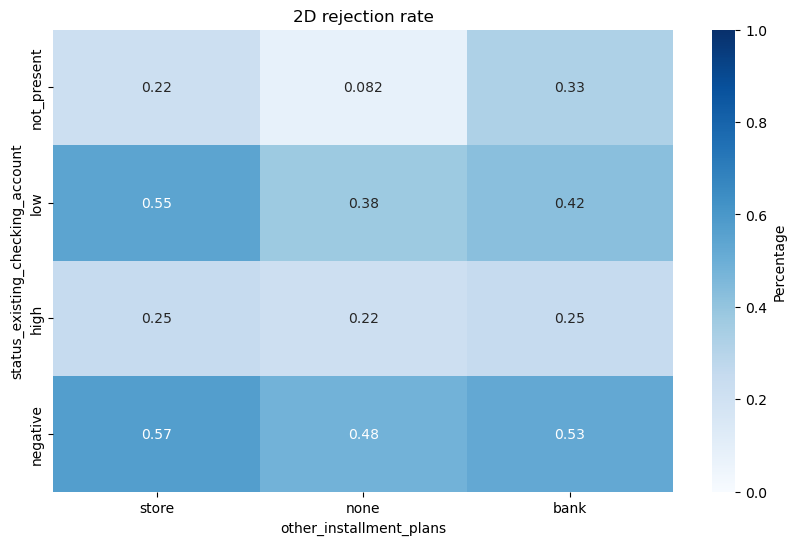

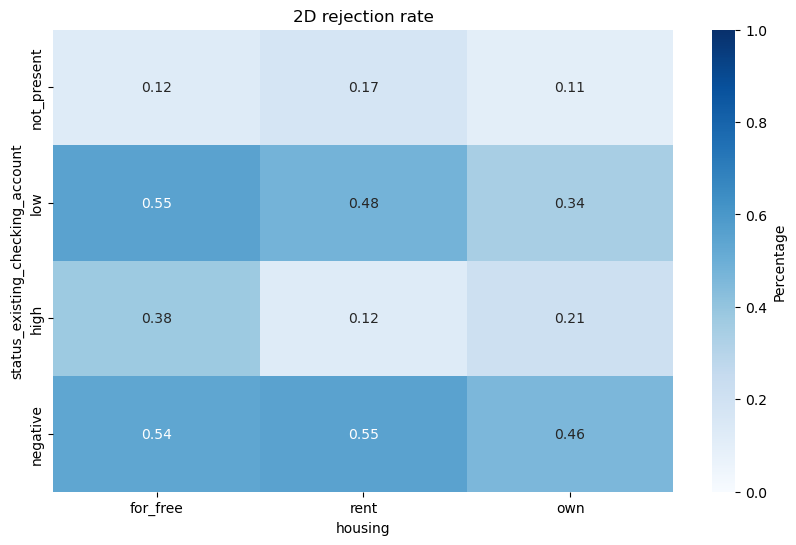

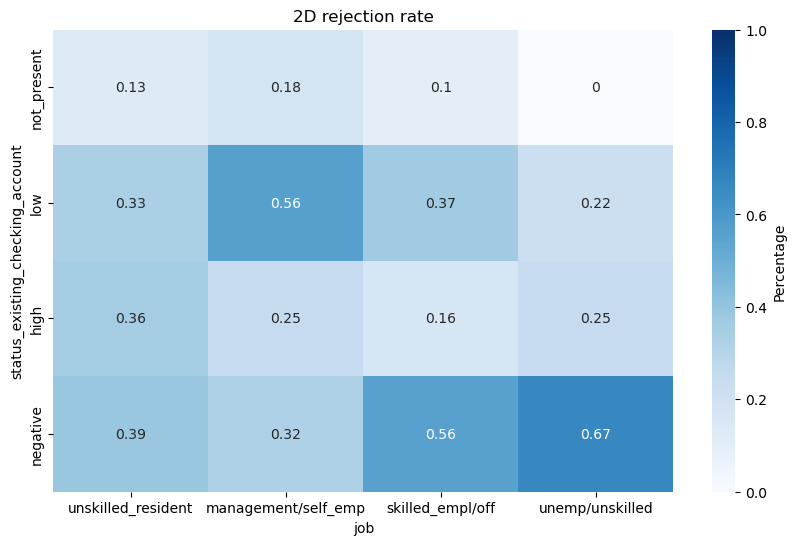

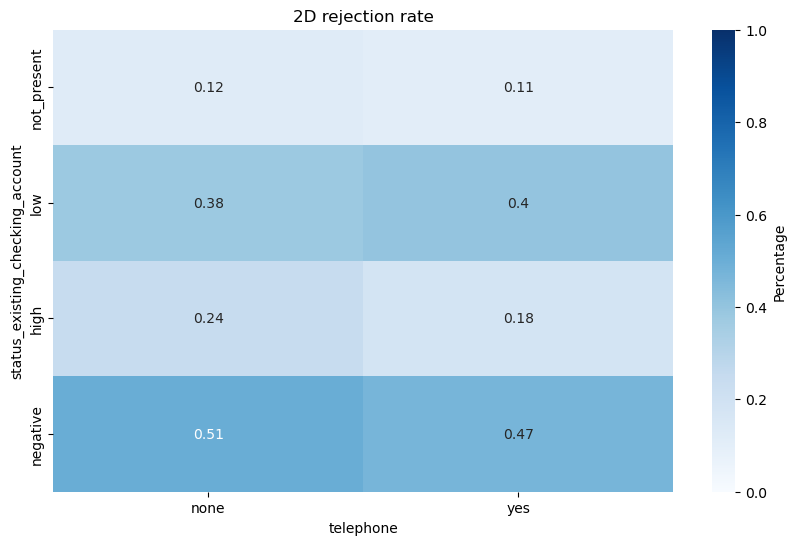

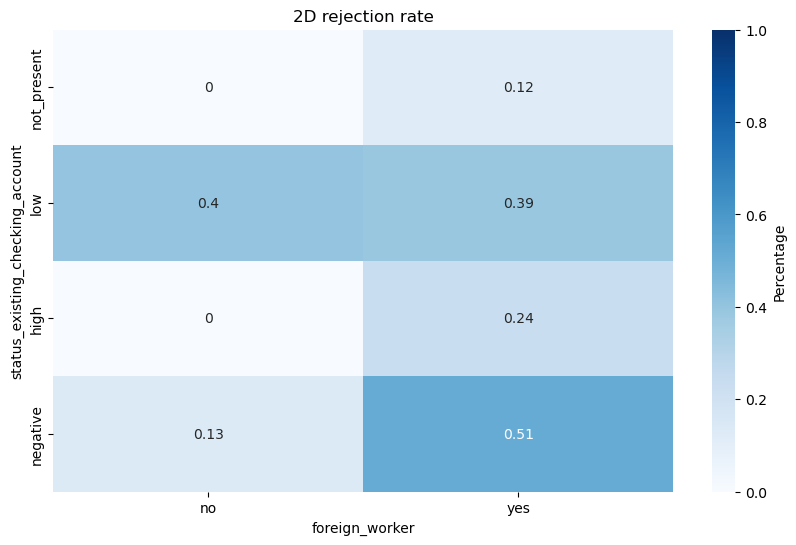

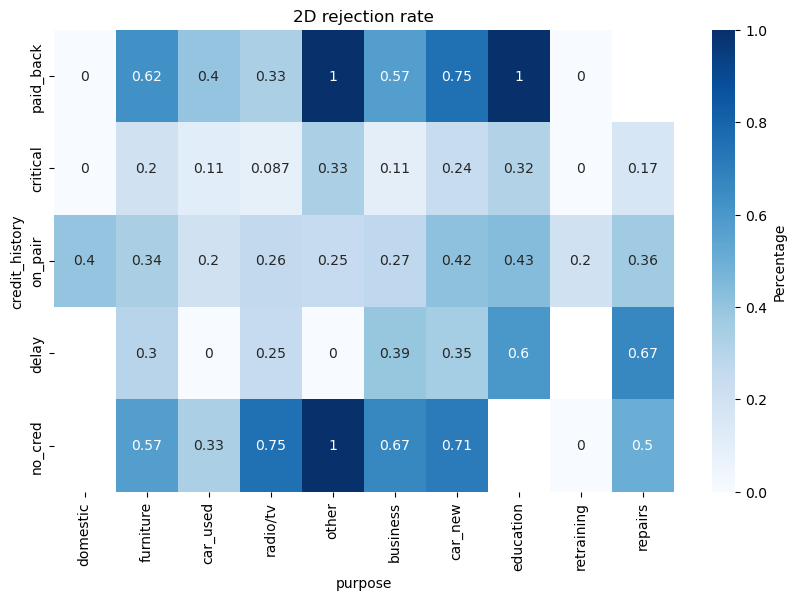

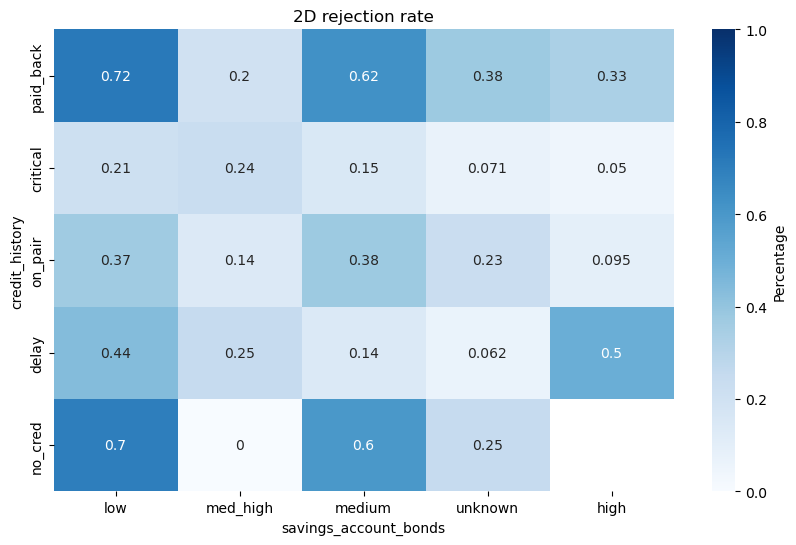

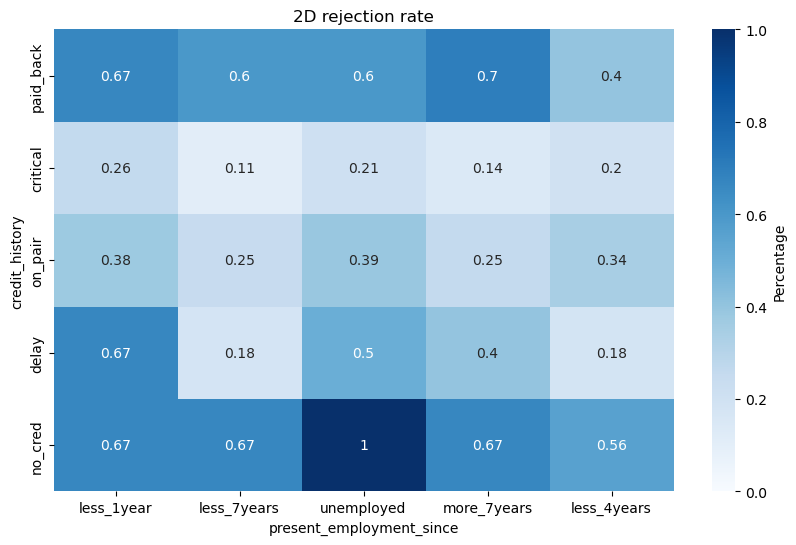

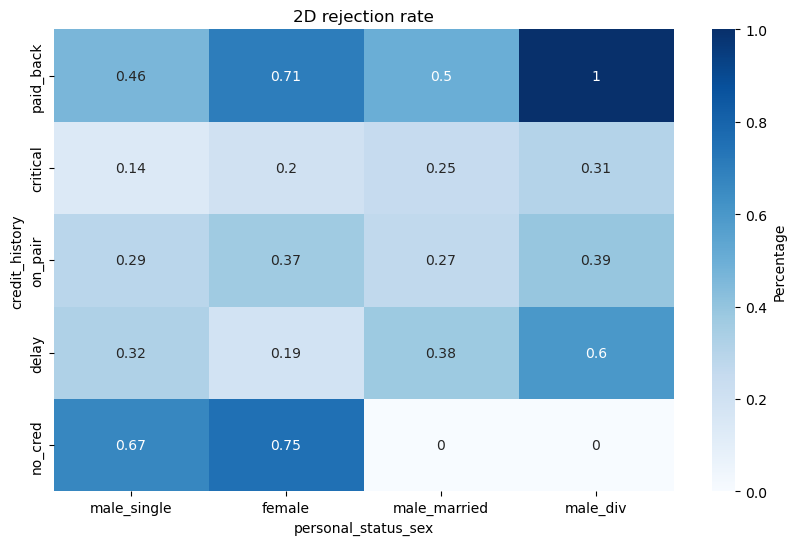

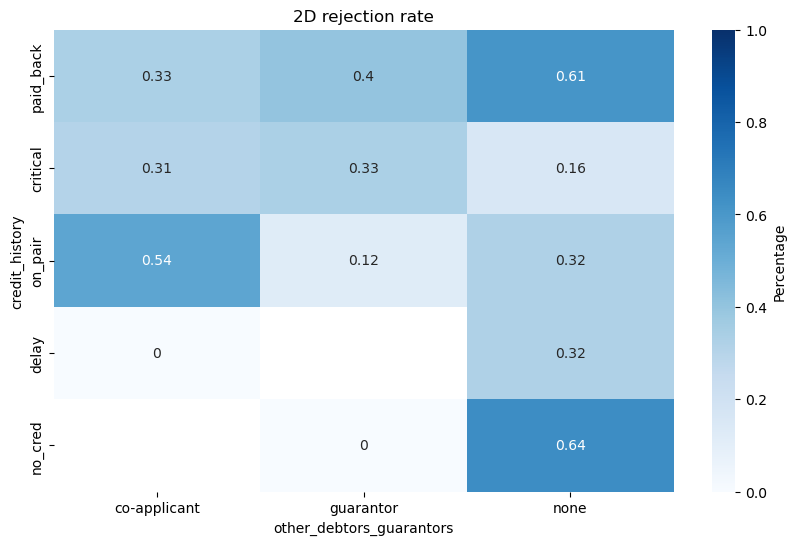

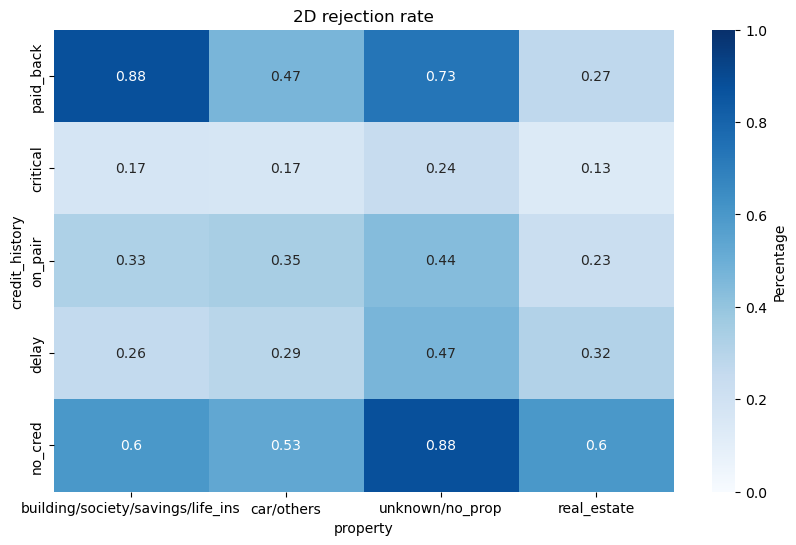

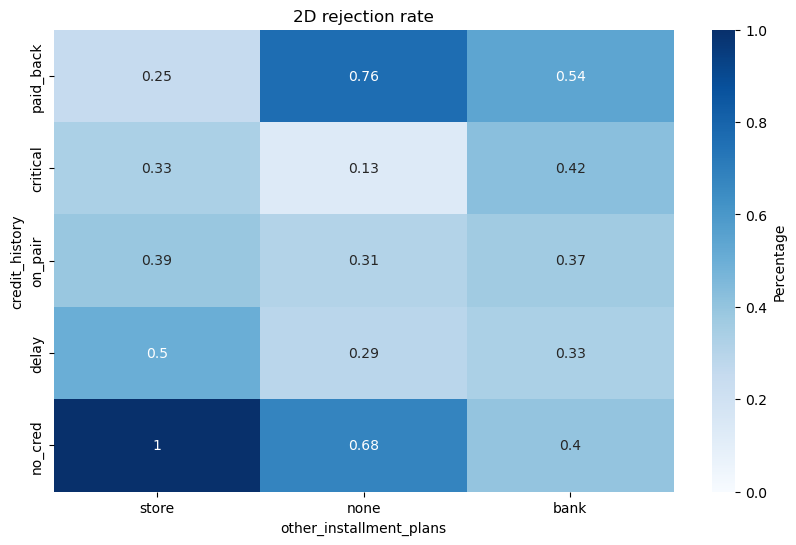

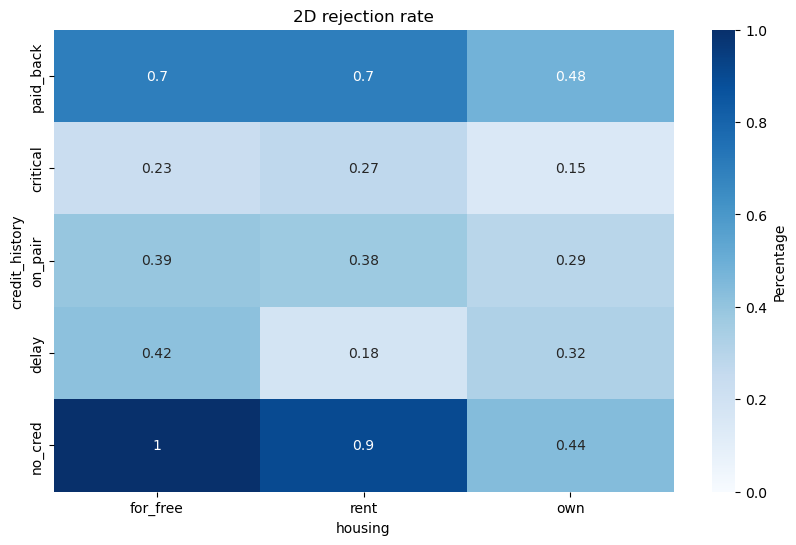

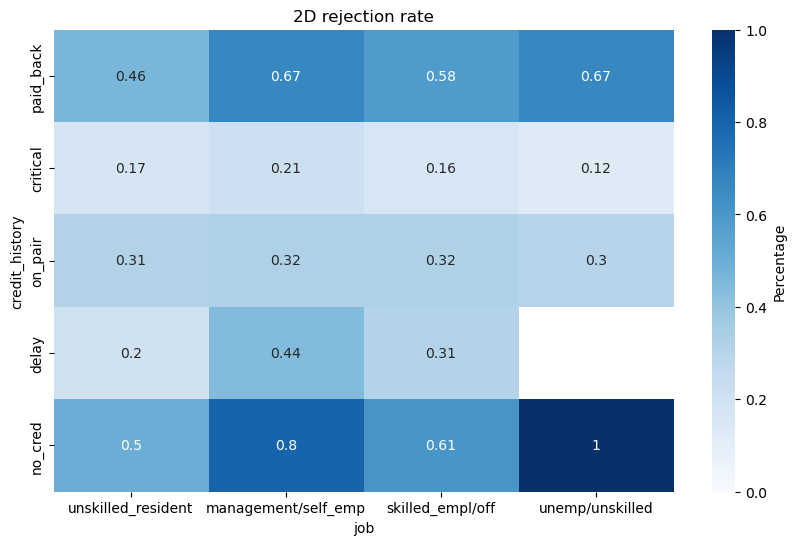

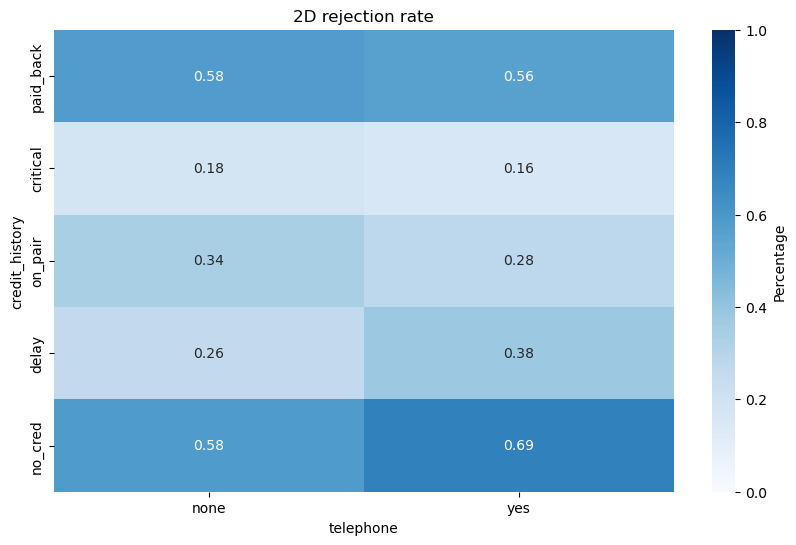

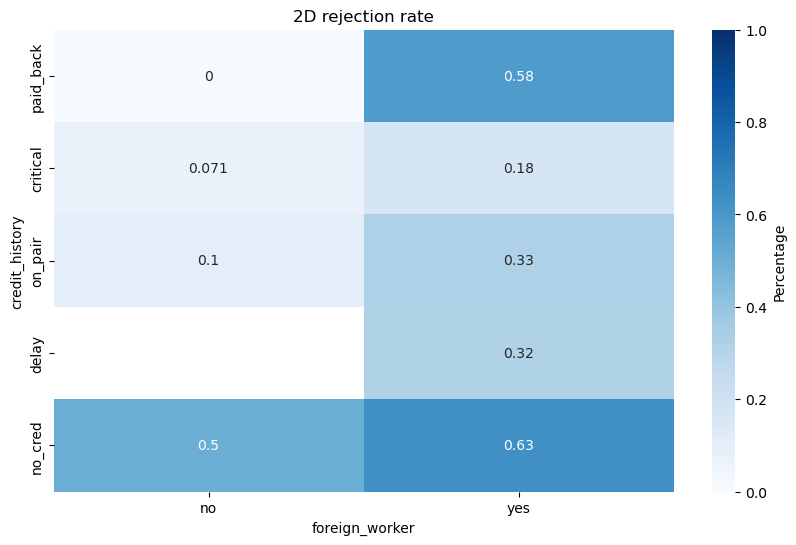

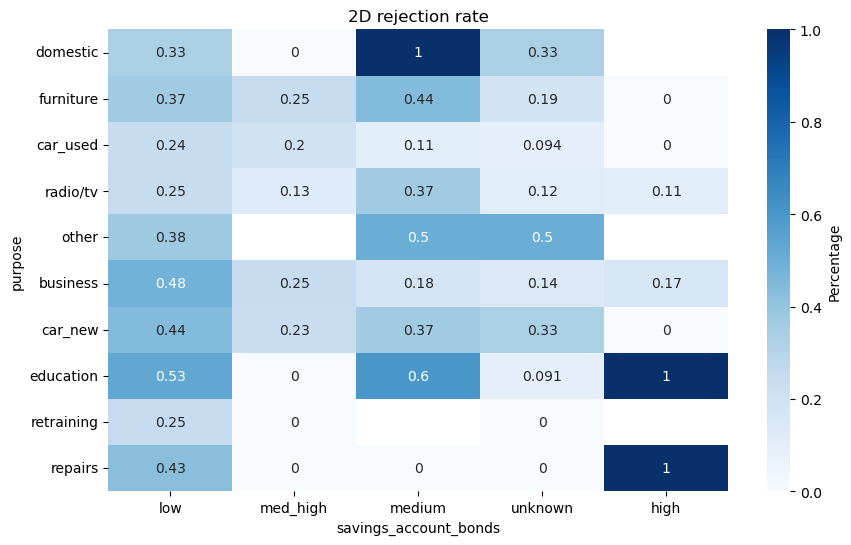

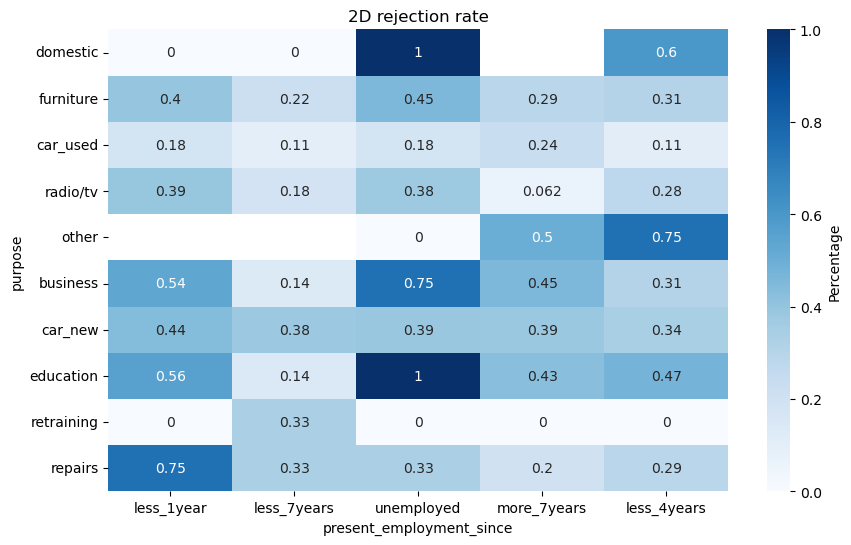

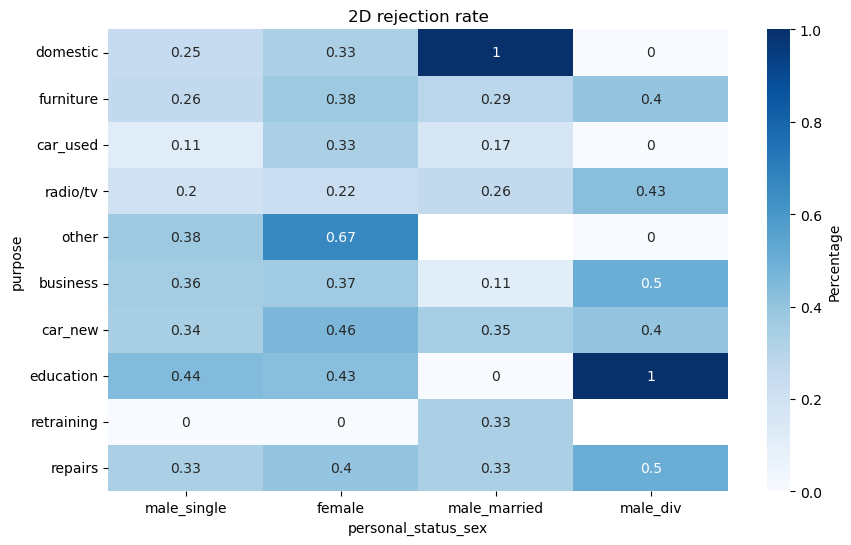

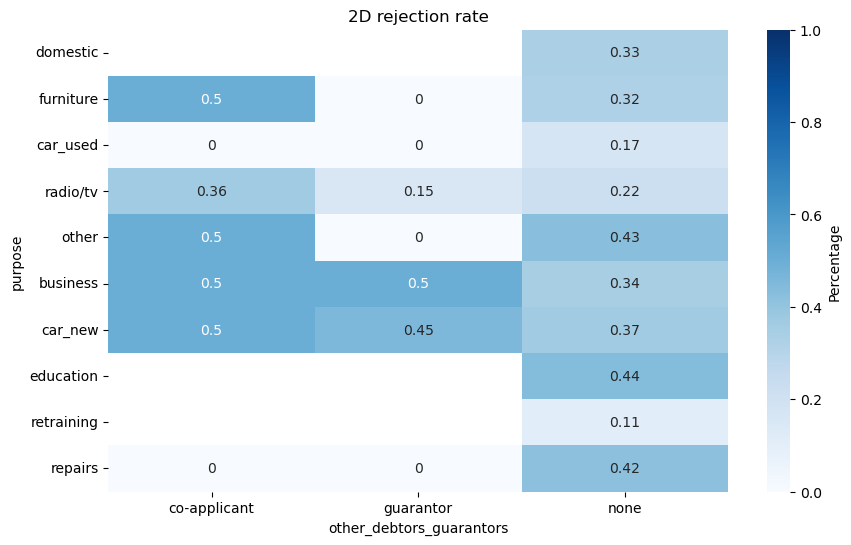

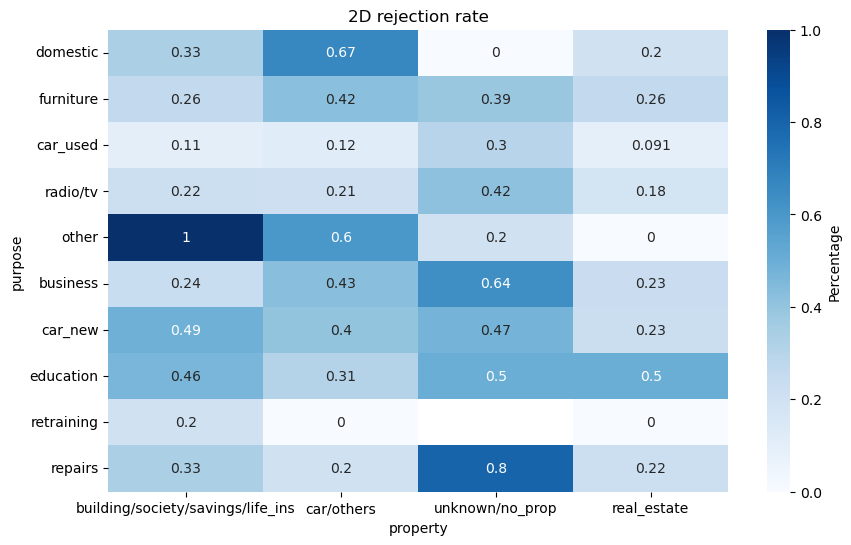

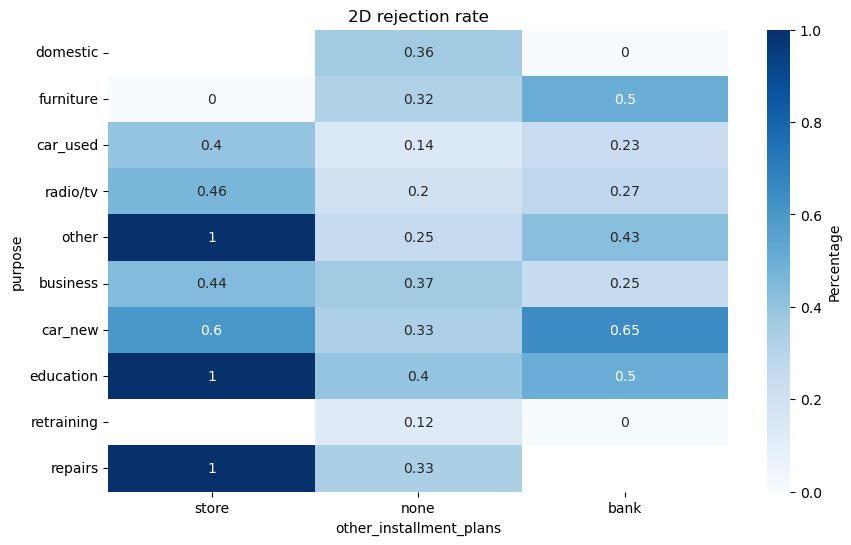

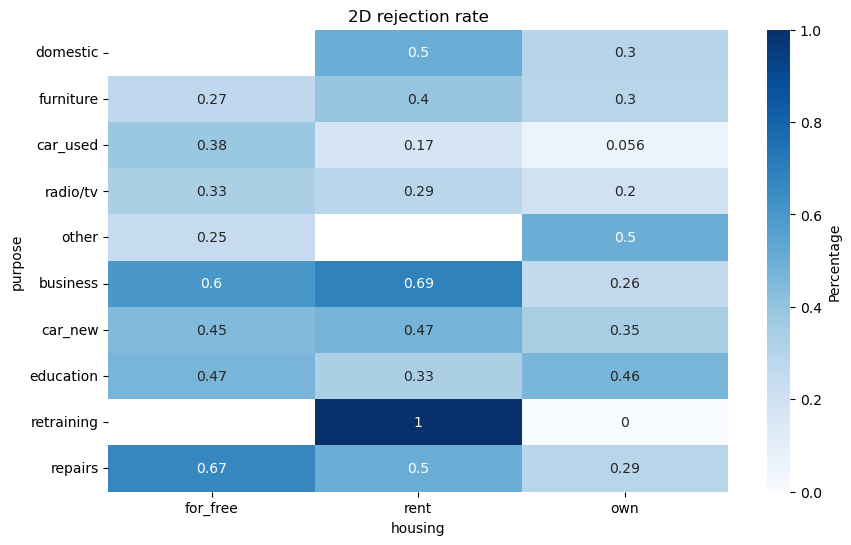

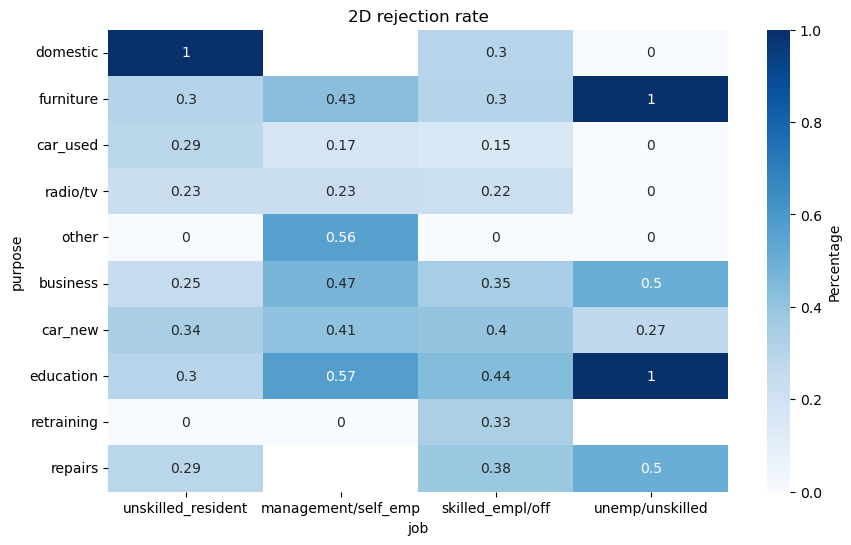

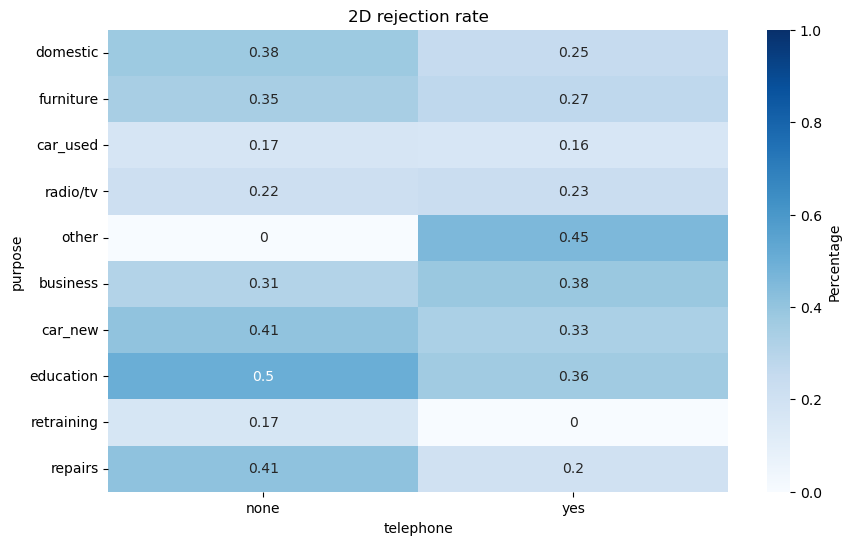

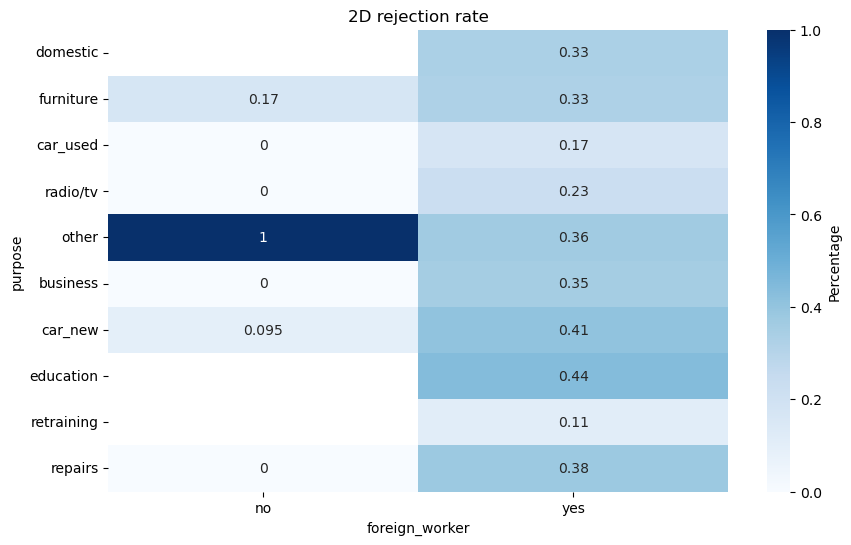

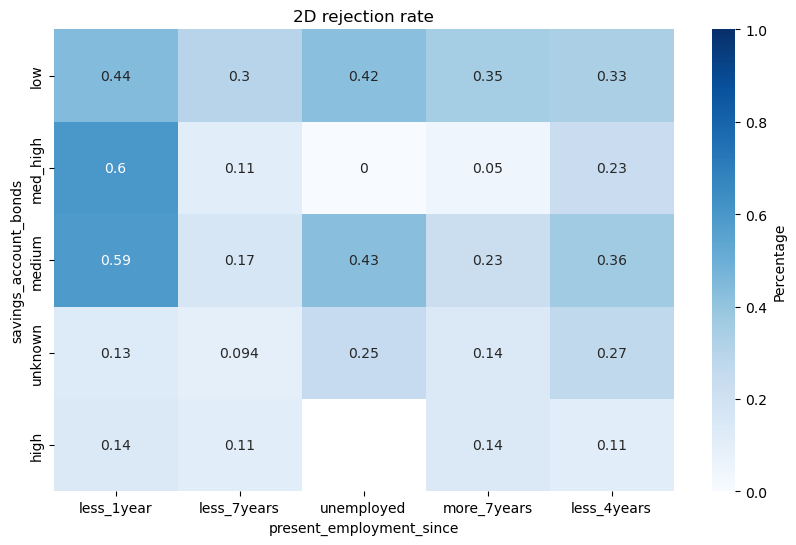

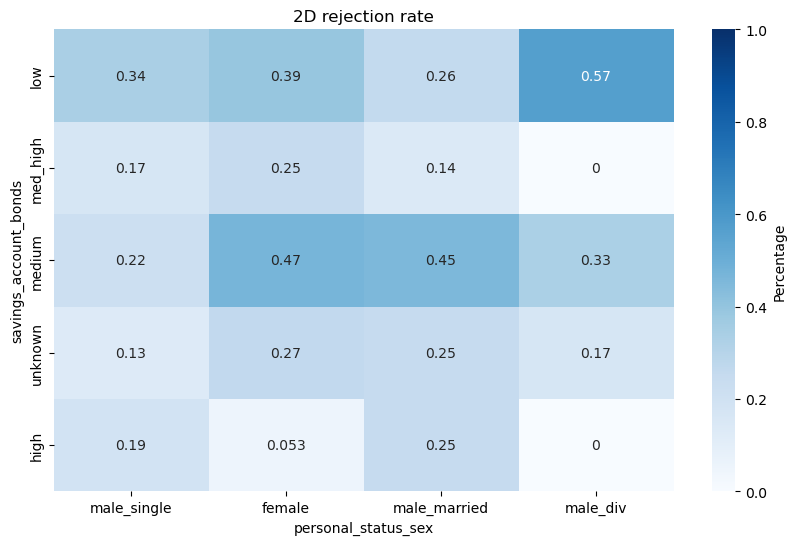

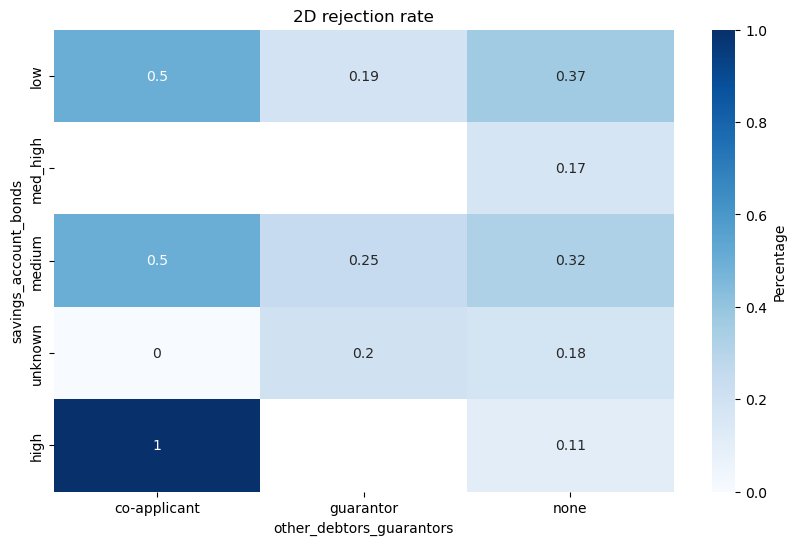

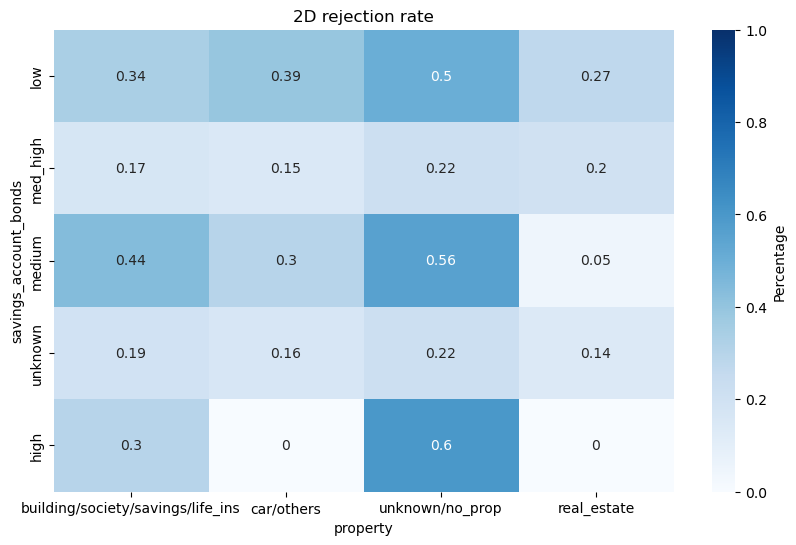

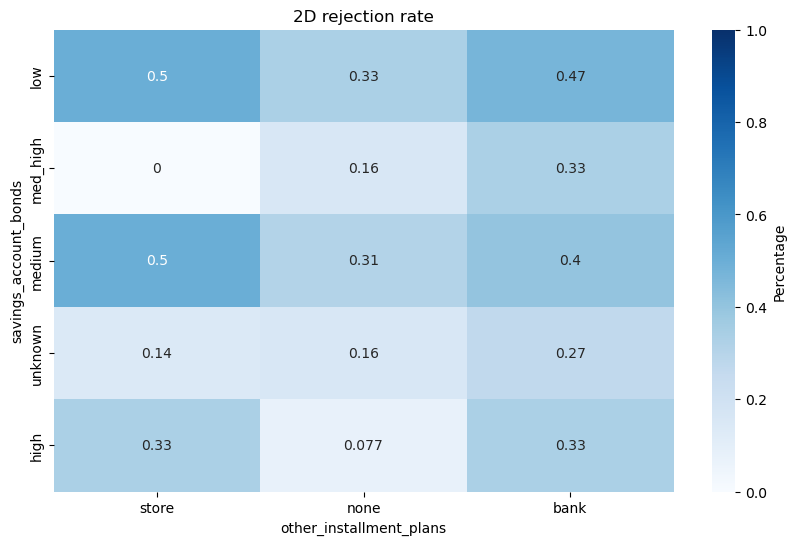

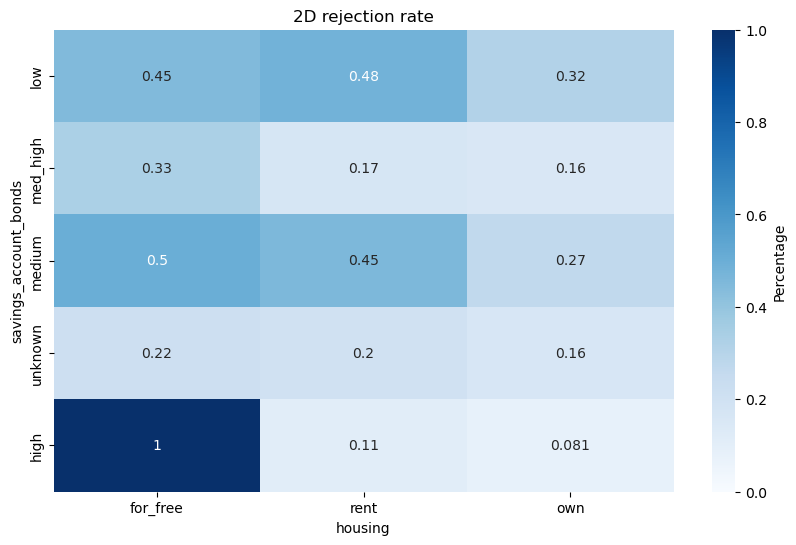

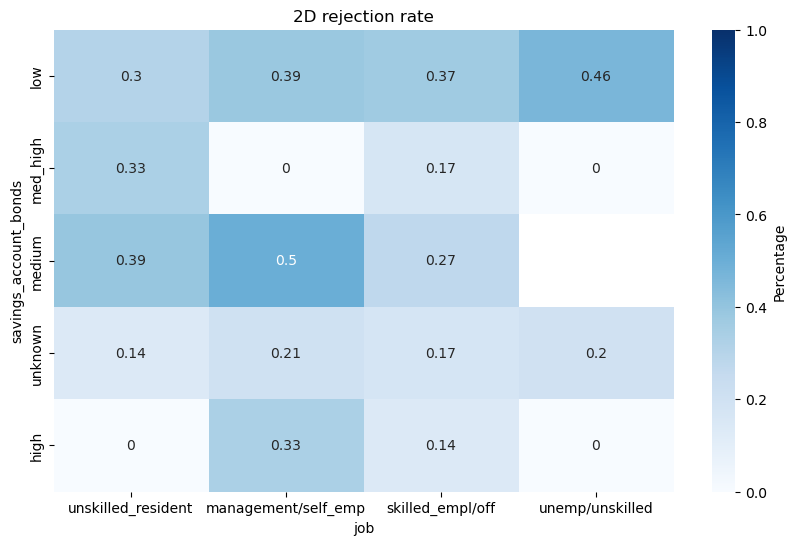

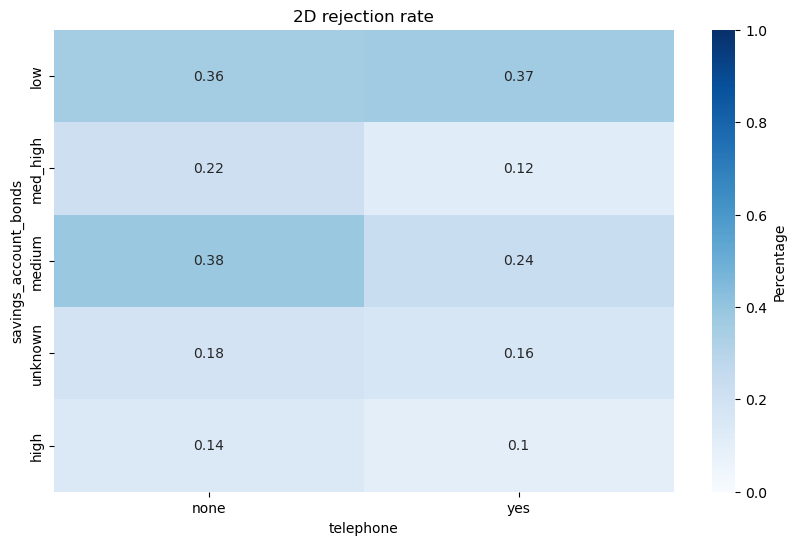

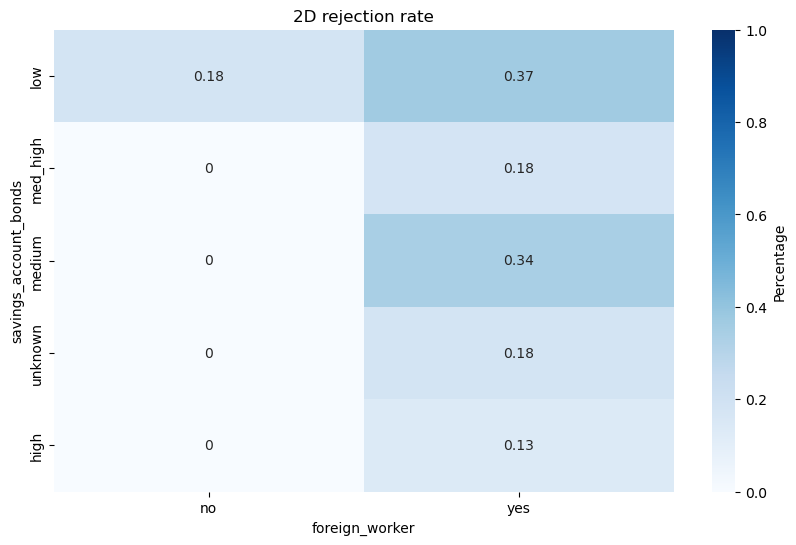

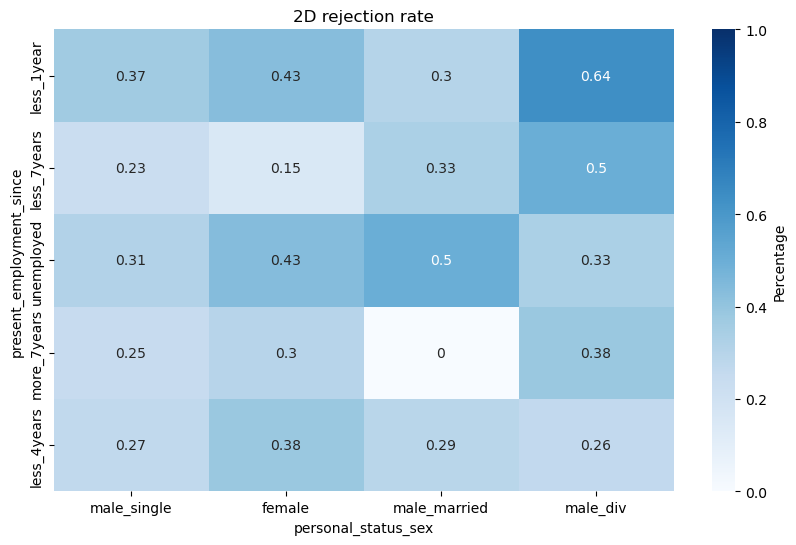

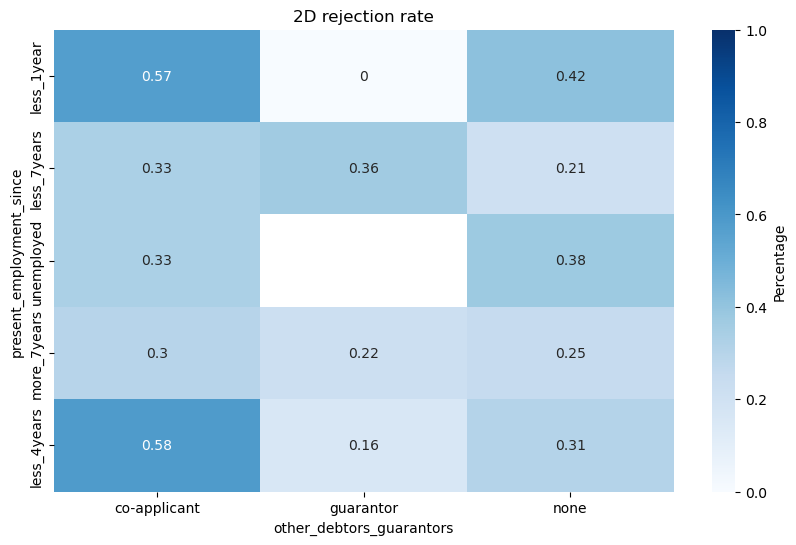

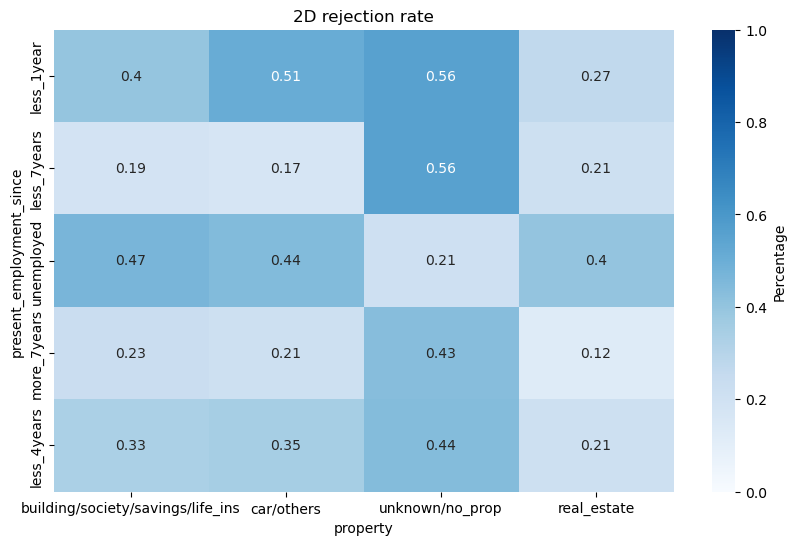

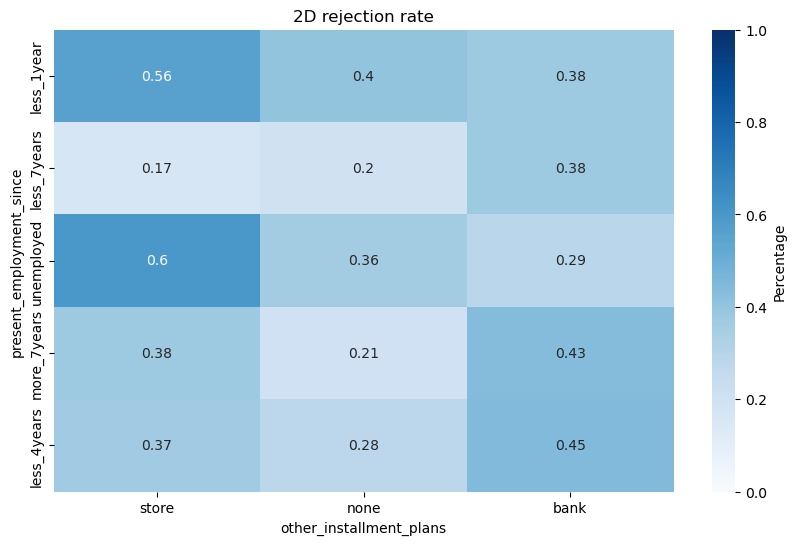

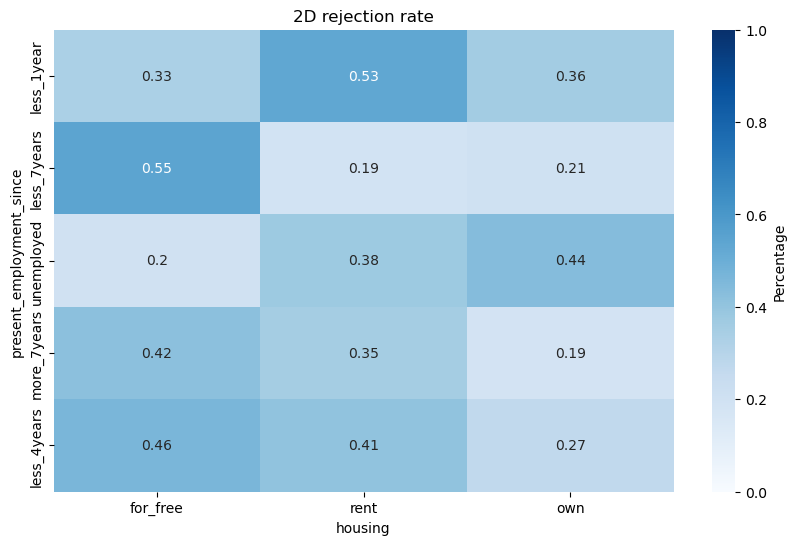

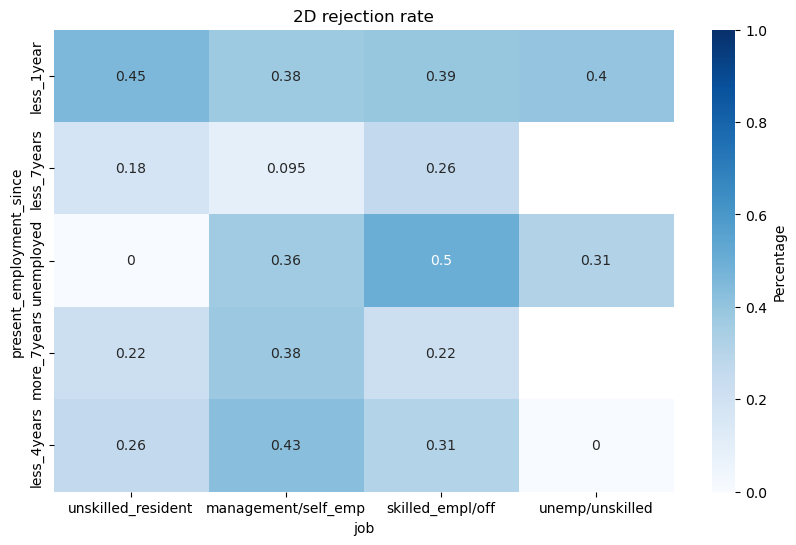

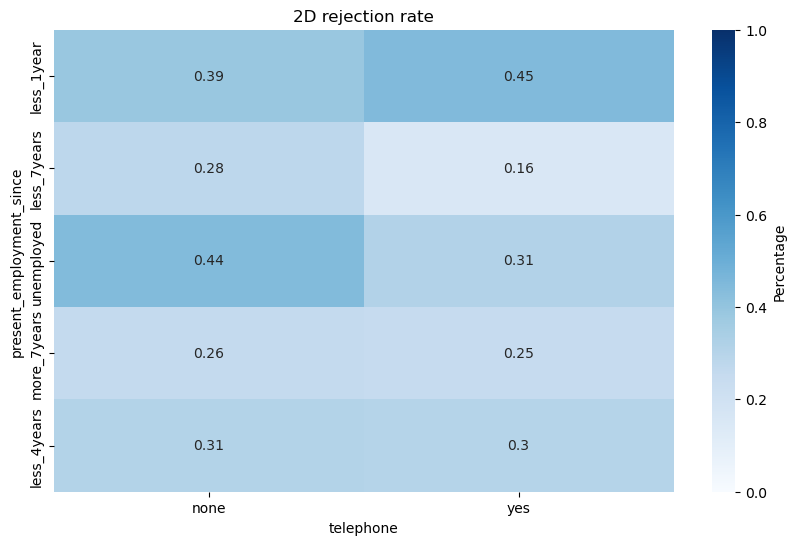

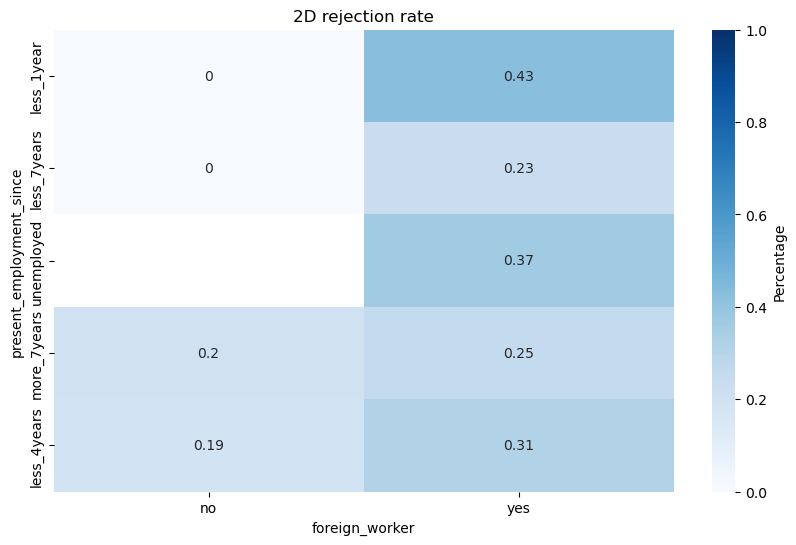

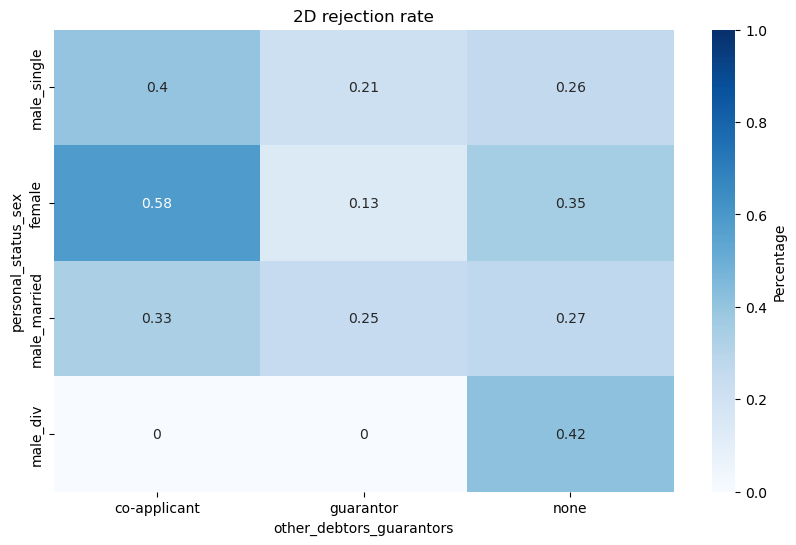

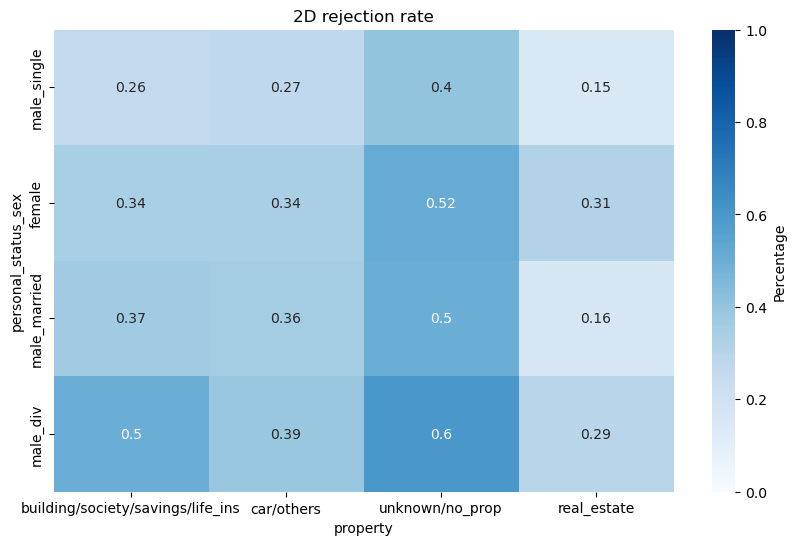

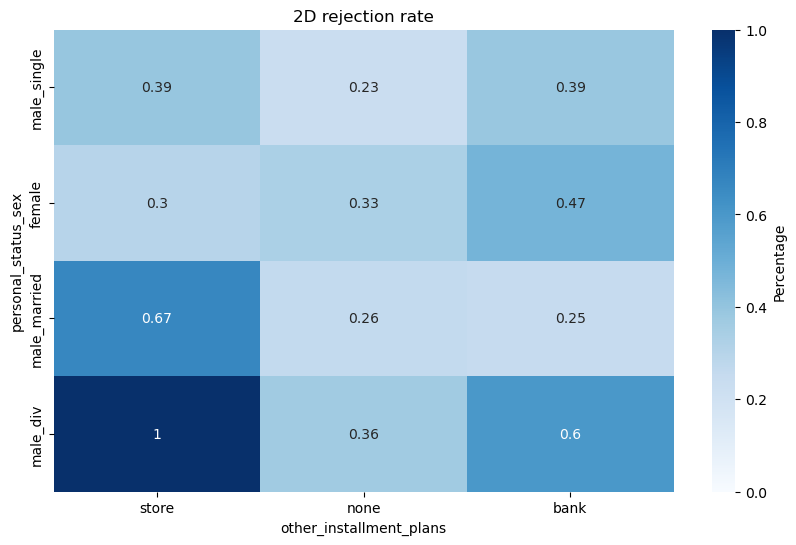

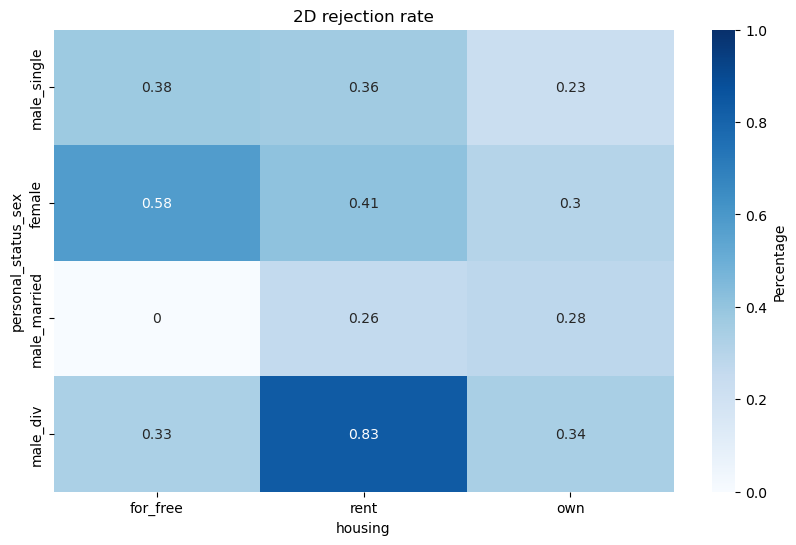

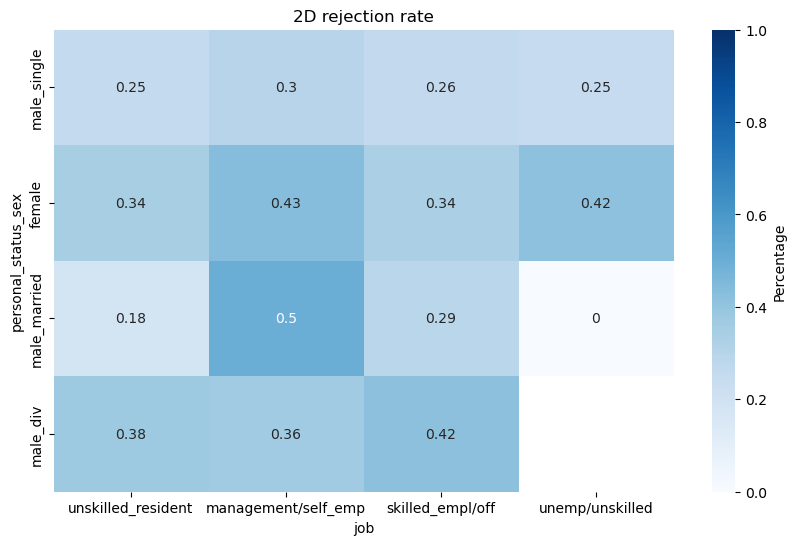

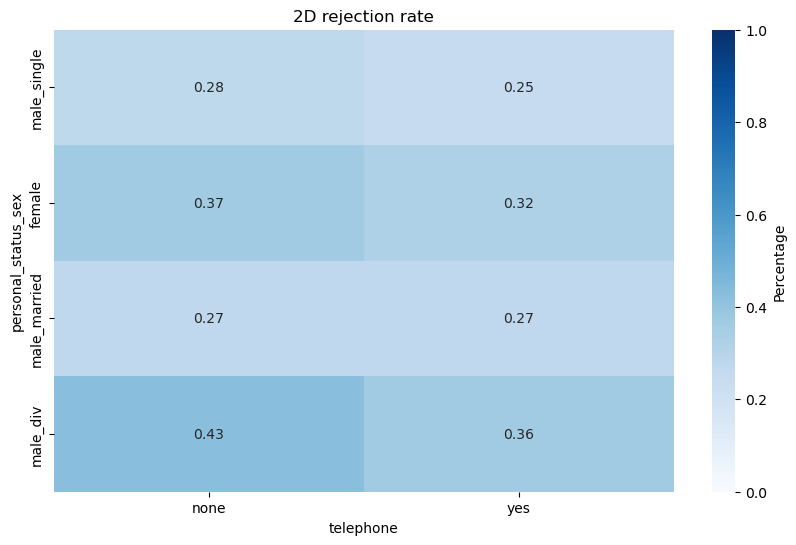

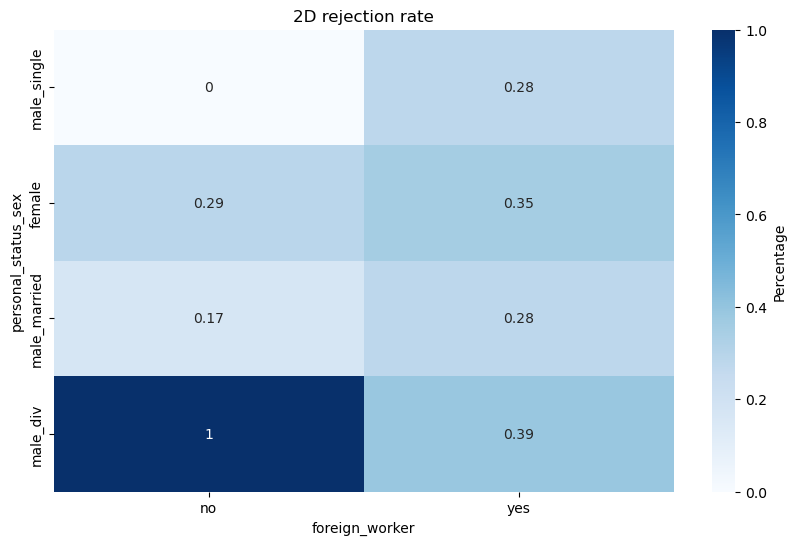

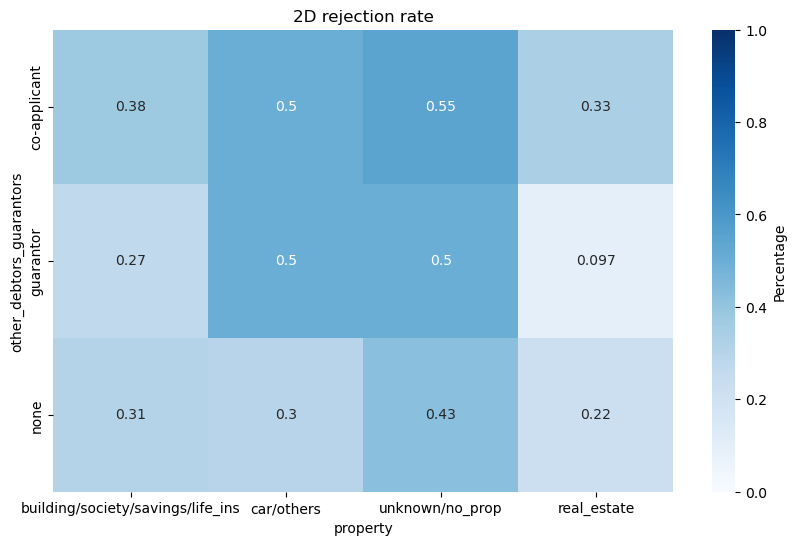

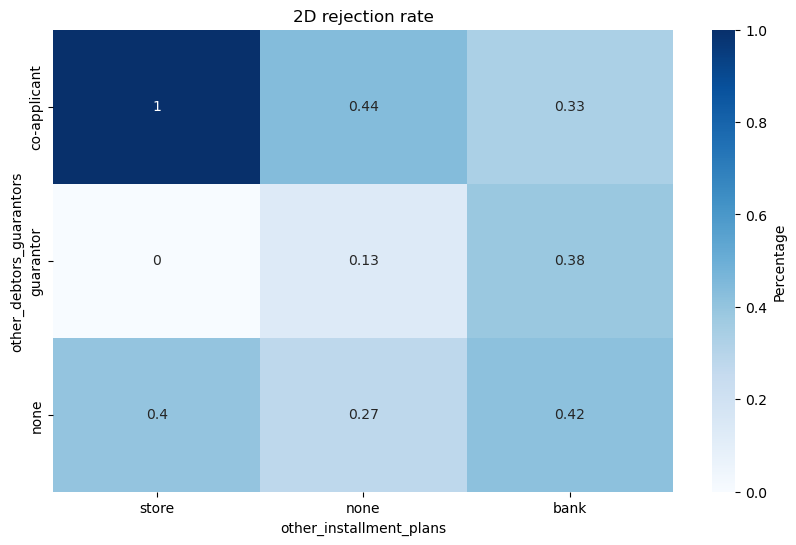

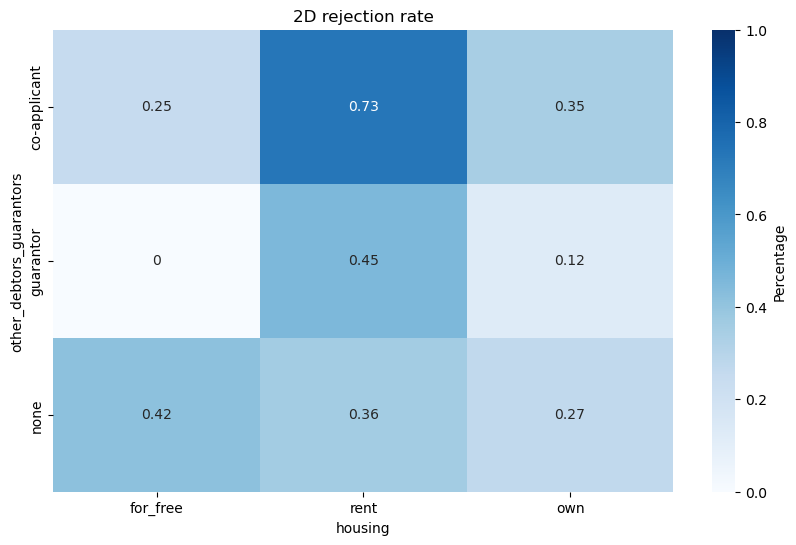

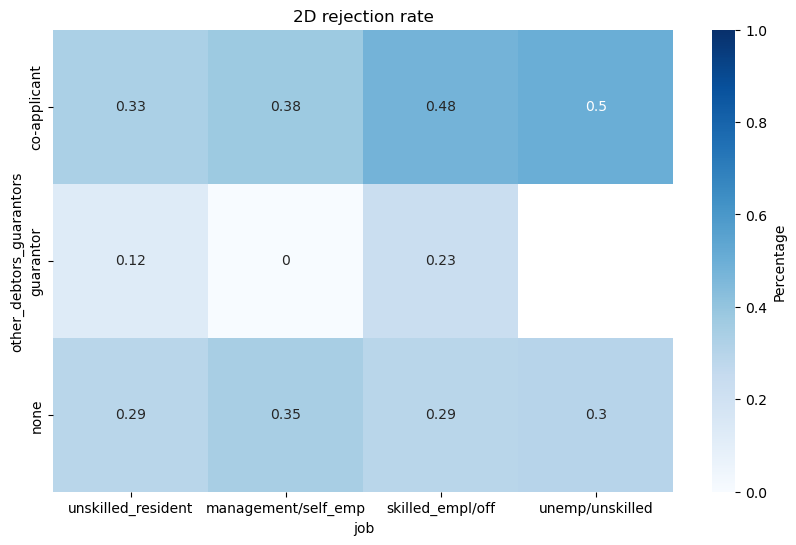

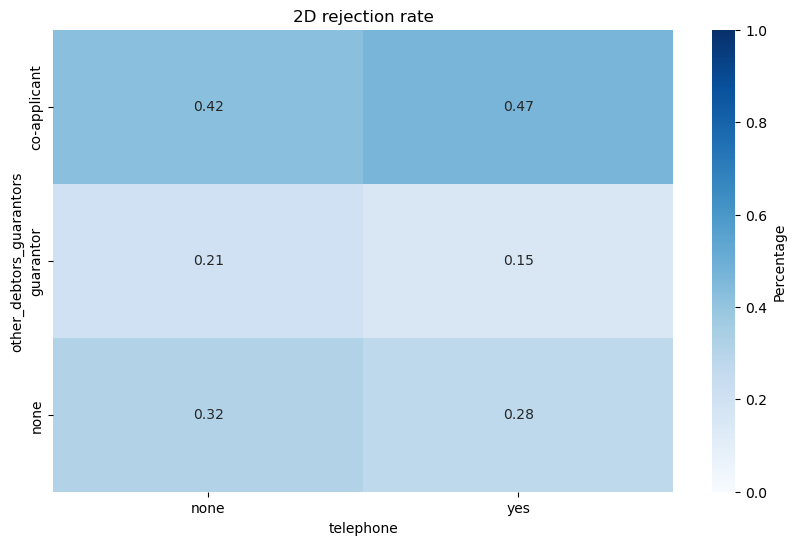

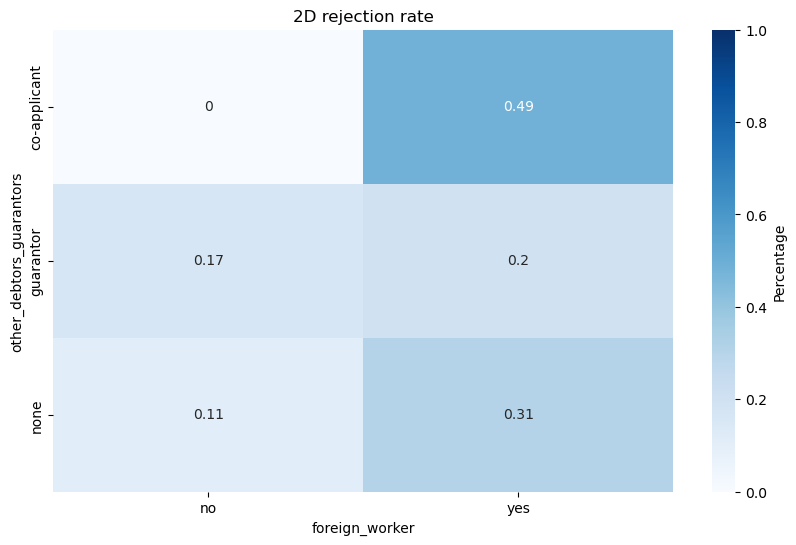

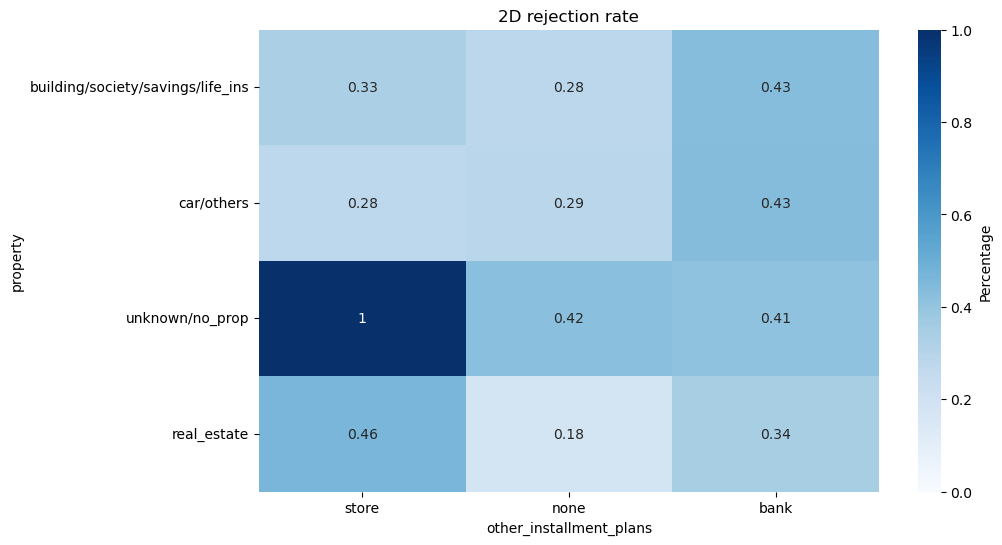

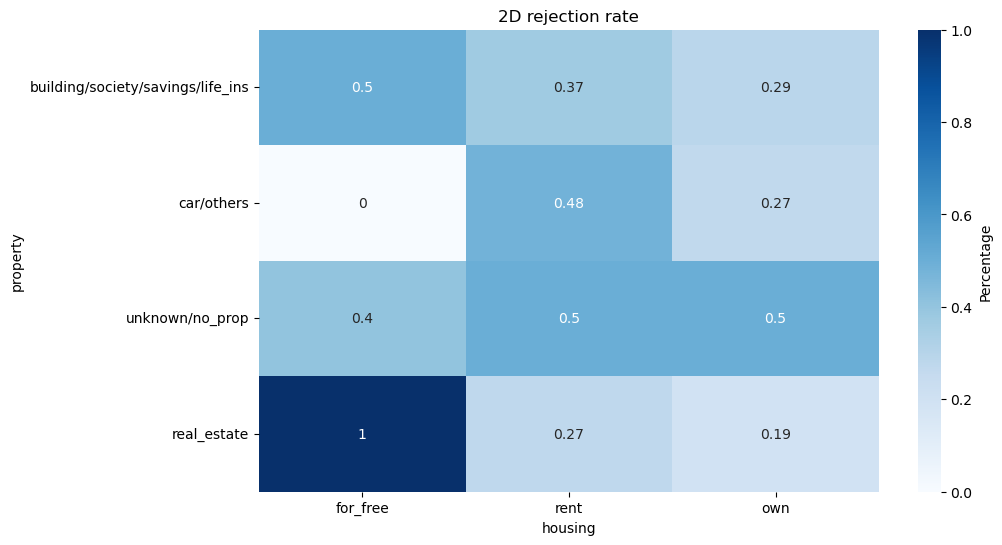

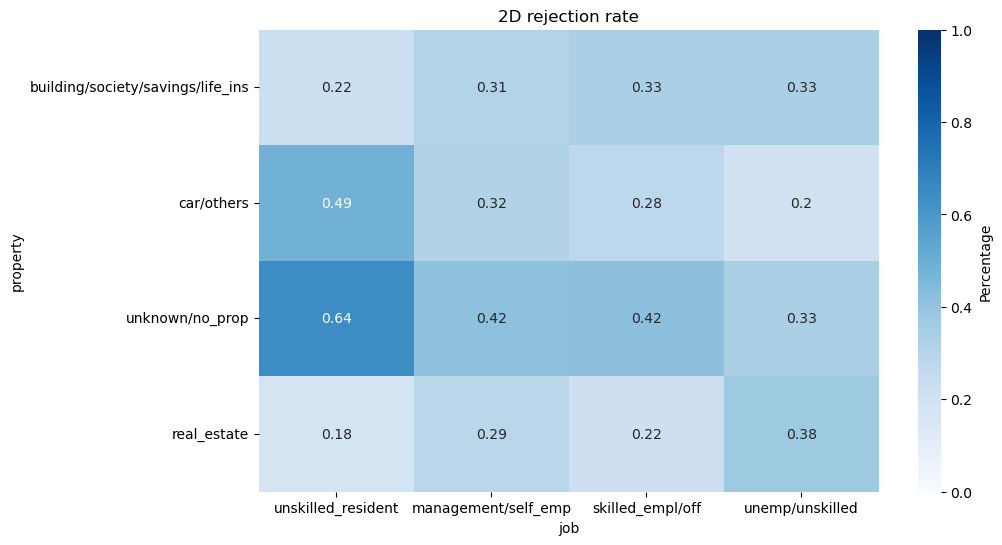

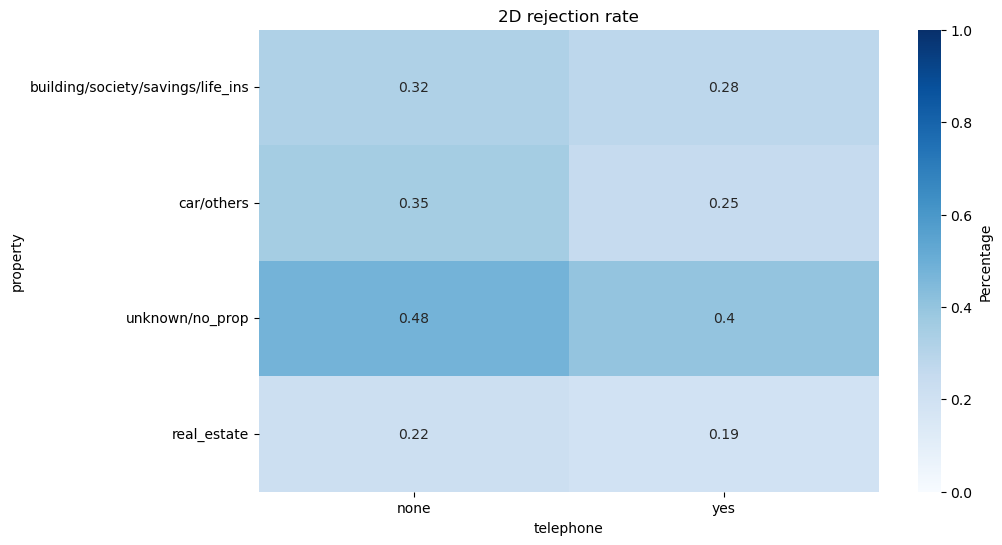

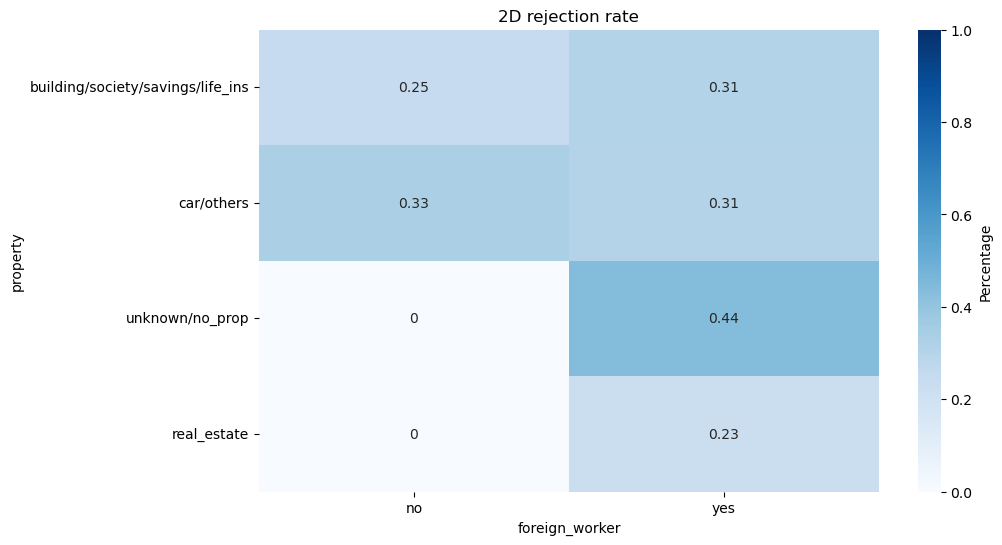

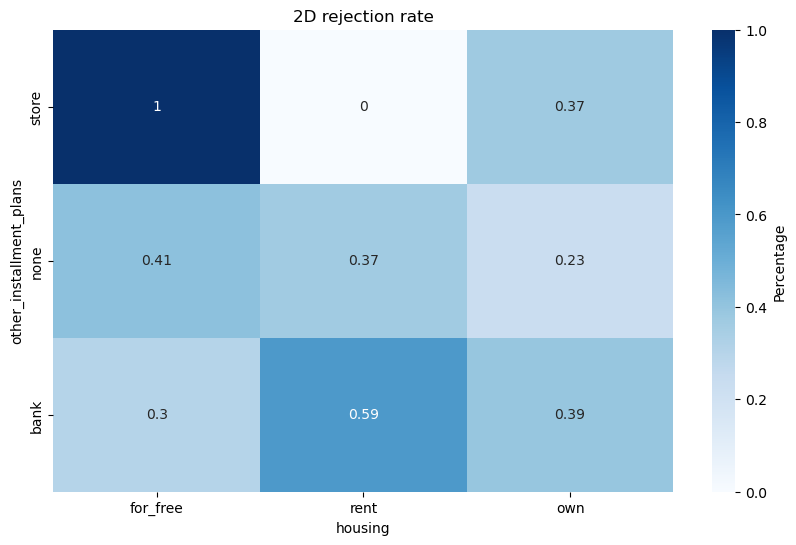

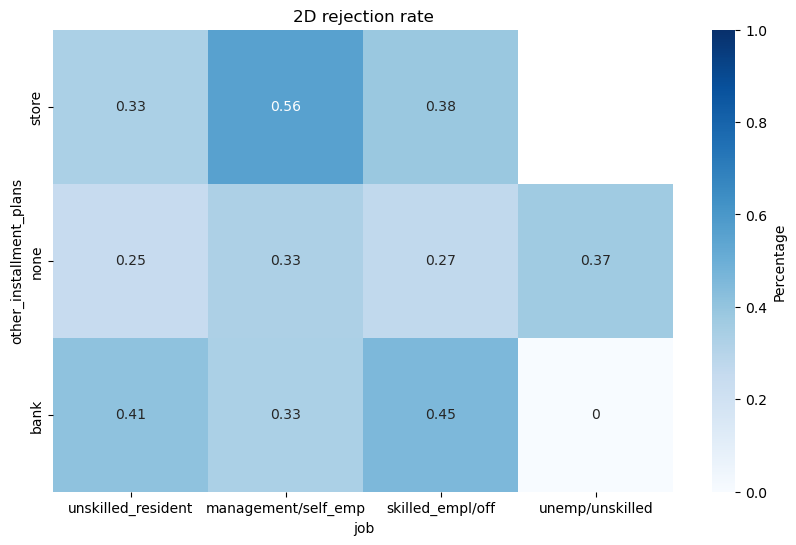

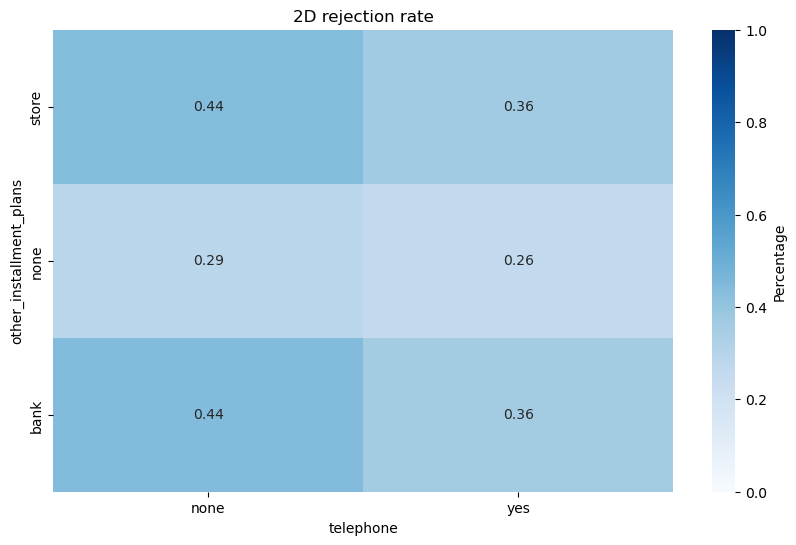

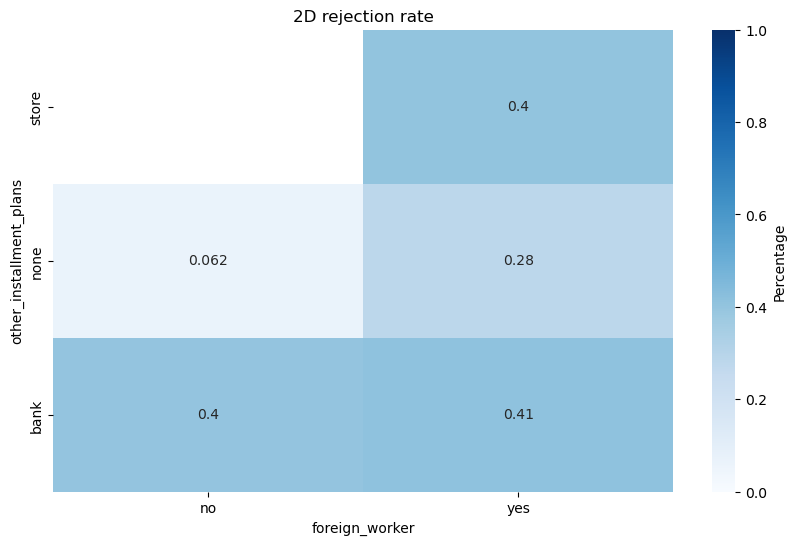

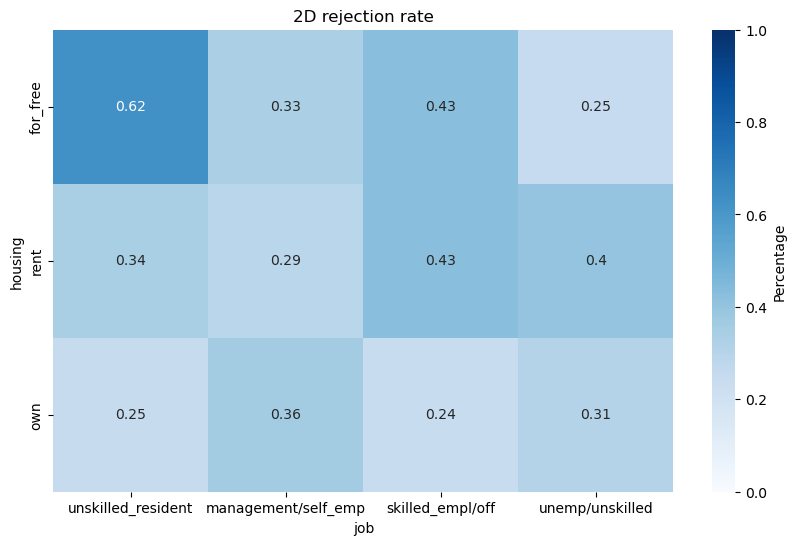

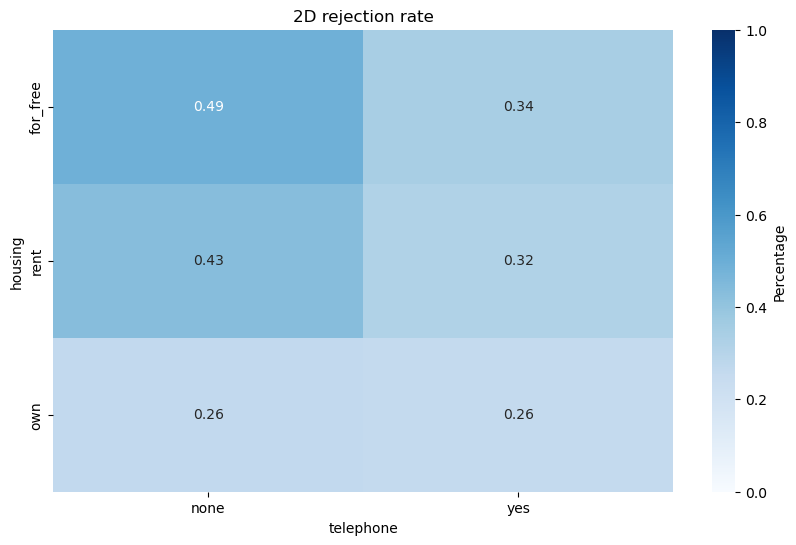

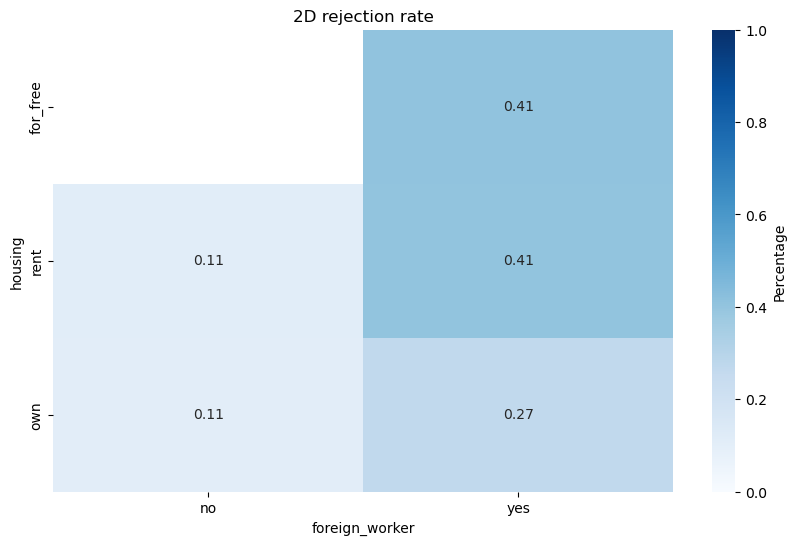

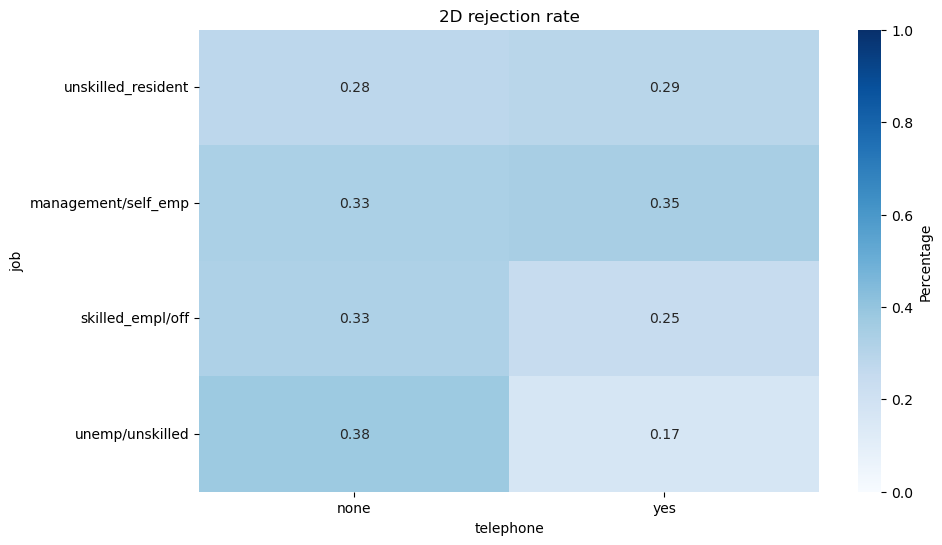

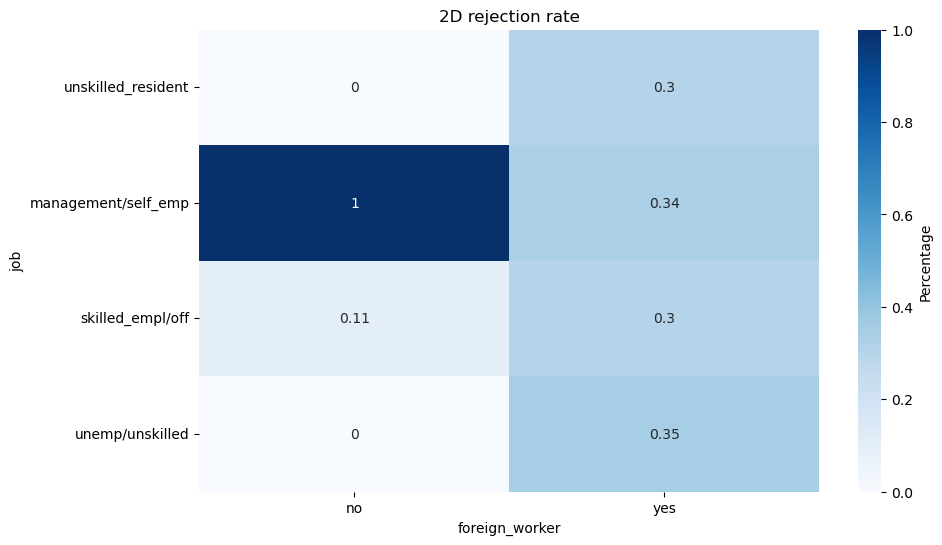

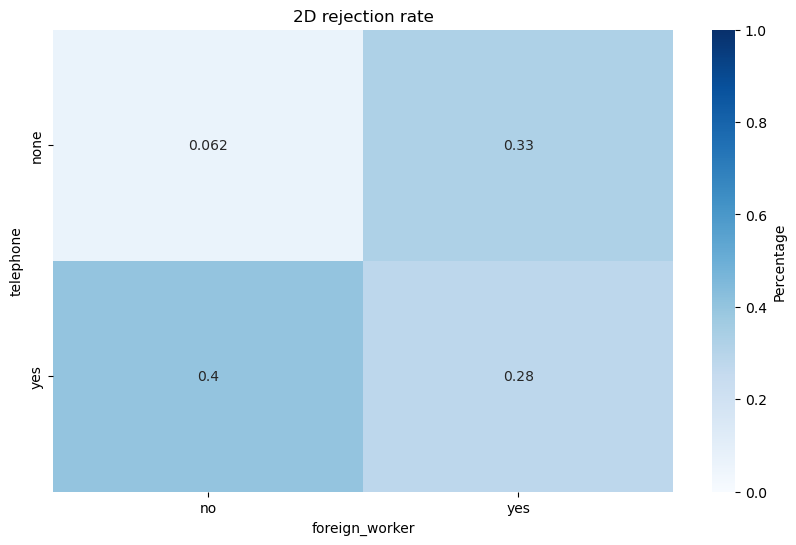

In [15]:
from itertools import combinations

selected_categorical_features = [
    "status_existing_checking_account",
    "credit_history",
    "purpose",
    "savings_account_bonds",
    "other_debtors_guarantors",
    "property",
    "other_installment_plans",
    "housing",
    "foreign_worker"
]

for col1,col2 in combinations(categorical_features, r=2):
    col1_types = list(filter(lambda x: x.startswith(col1), categorical_features_hotencoded))
    col2_types = list(filter(lambda x: x.startswith(col2), categorical_features_hotencoded))
    rejection_rates_2d = pd.DataFrame(index=col1_types, columns=col2_types)
    for cc1 in col1_types:
        for cc2 in col2_types:
            tmp = df_processed.loc[(df_processed[cc1] == 1) & (df_processed[cc2] == 1),:]
            tot = tmp.size
            if tot == 0:
                continue
            neg = tmp[tmp["label"] == 2].size
            rate = neg/tot * 100
            rejection_rates_2d.loc[cc1,cc2] = rate / 100
    rejection_rates_2d.rename(
        index=lambda x: translation[x.split(col1)[1][1:]], inplace=True
    )
    rejection_rates_2d.rename(
        columns=lambda x: translation[x.split(col2)[1][1:]], inplace=True
    )
    rejection_rates_2d = rejection_rates_2d.astype(np.float64)
    plt.figure(figsize=(10,6))
    sns.heatmap(rejection_rates_2d, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label': 'Percentage'})
    plt.title(f'2D rejection rate')
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.show()

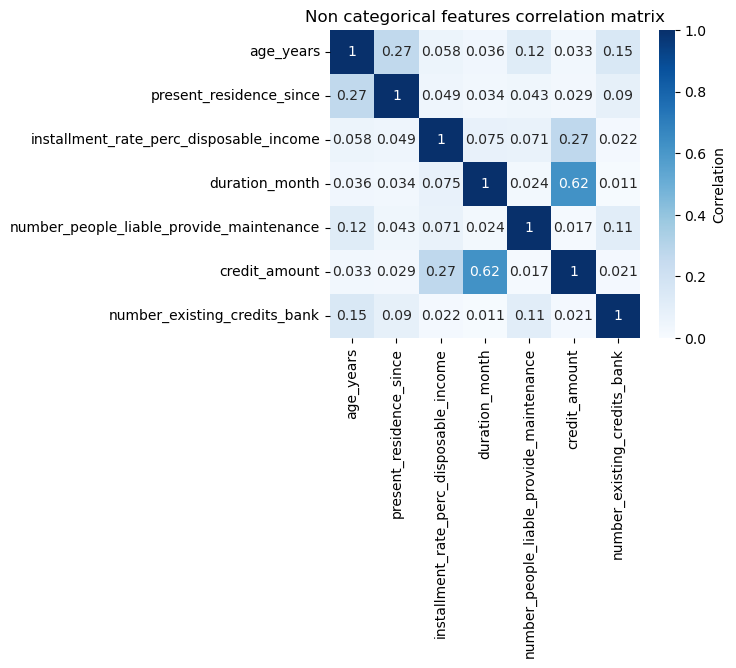

In [16]:
corr_matrix = df[non_categorical_features].corr().abs()
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Non categorical features correlation matrix')
plt.show()

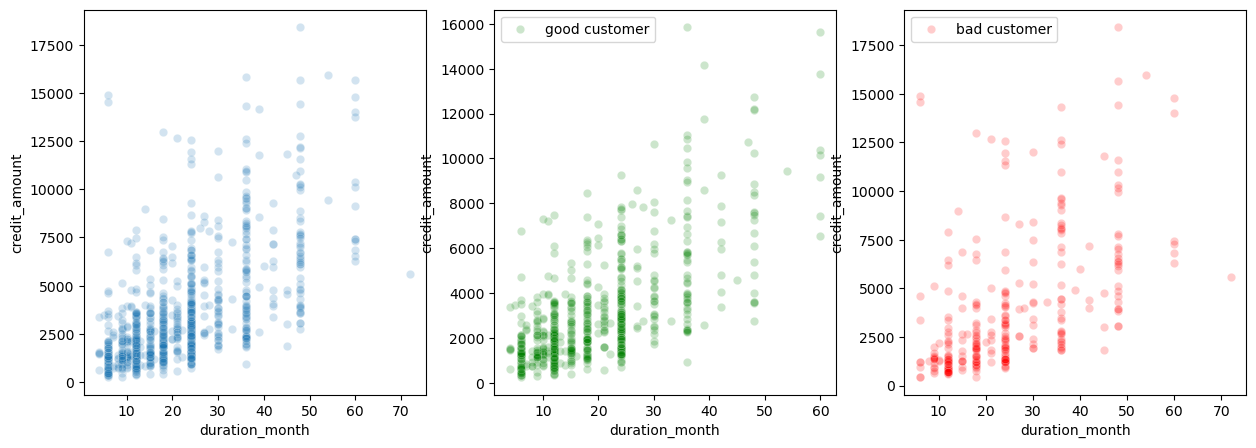

In [17]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(df_processed, y='credit_amount',x='duration_month', alpha=.2, ax=axs[0])
sns.scatterplot(df_processed[df_processed['label'] == 1], y='credit_amount',x='duration_month', alpha=.2, color='green', ax=axs[1], label='good customer')
sns.scatterplot(df_processed[df_processed['label'] == 2], y='credit_amount',x='duration_month', alpha=.2, color='red', ax=axs[2], label='bad customer')
plt.show()

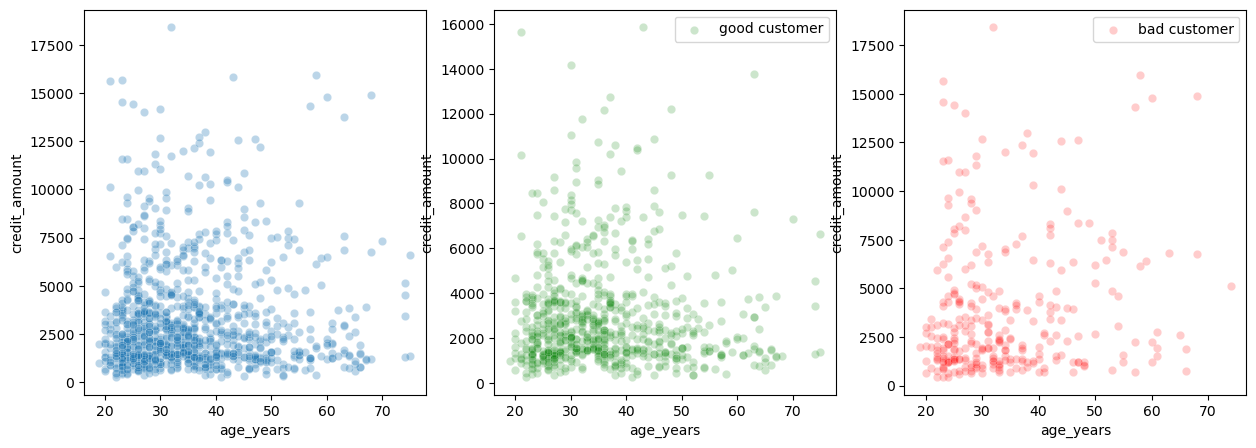

In [18]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(df_processed, y='credit_amount',x='age_years', alpha=.3, ax=axs[0])
sns.scatterplot(df_processed[df_processed['label'] == 1], y='credit_amount',x='age_years', alpha=.2, color='green', ax=axs[1], label='good customer')
sns.scatterplot(df_processed[df_processed['label'] == 2], y='credit_amount',x='age_years', alpha=.2, color='red', ax=axs[2], label='bad customer')
plt.show()

## 2 Unsupervised exploration and clustering

### 2.1 Dimensionality reduction for data visualization

#### Principal Component Analysis

In [19]:
from sklearn.decomposition import PCA

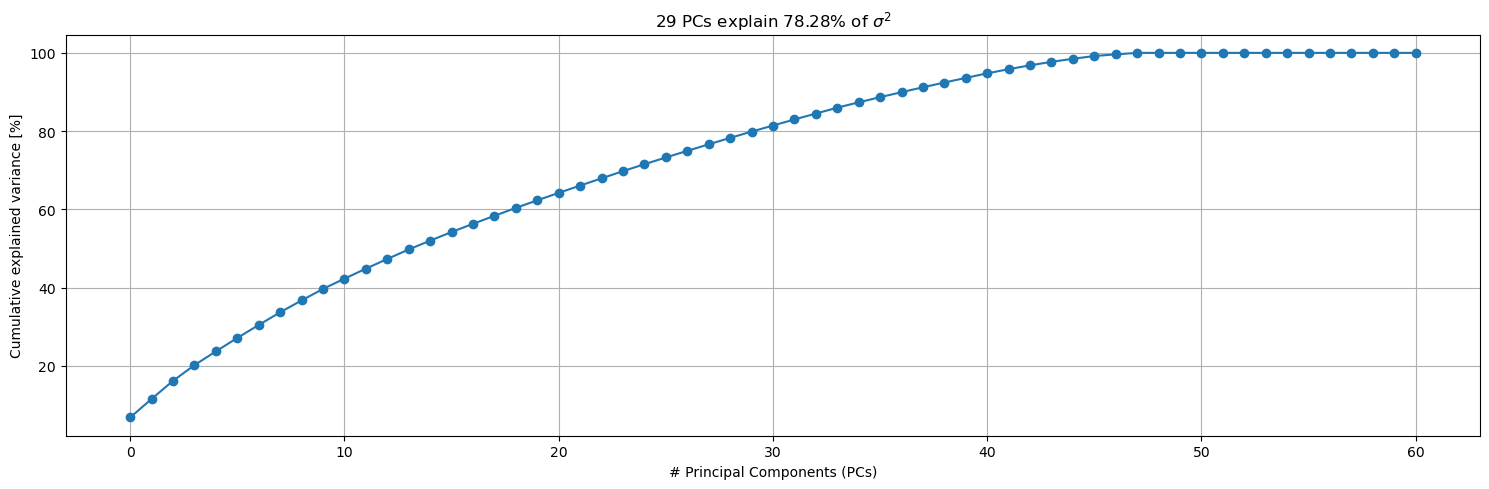

[4.17783097 2.89898975 2.82132872 2.44769628 2.14531991 2.09849464
 2.02313708 1.97946254 1.84506579 1.80090726 1.5915731  1.5650656
 1.51398155 1.48329882 1.36905659 1.35316726 1.27324072 1.25254642
 1.23577247 1.1805293  1.16063297 1.1396751  1.13010394 1.1206168
 1.08066833 1.05081341 1.03474866 1.01670684 1.00523653]


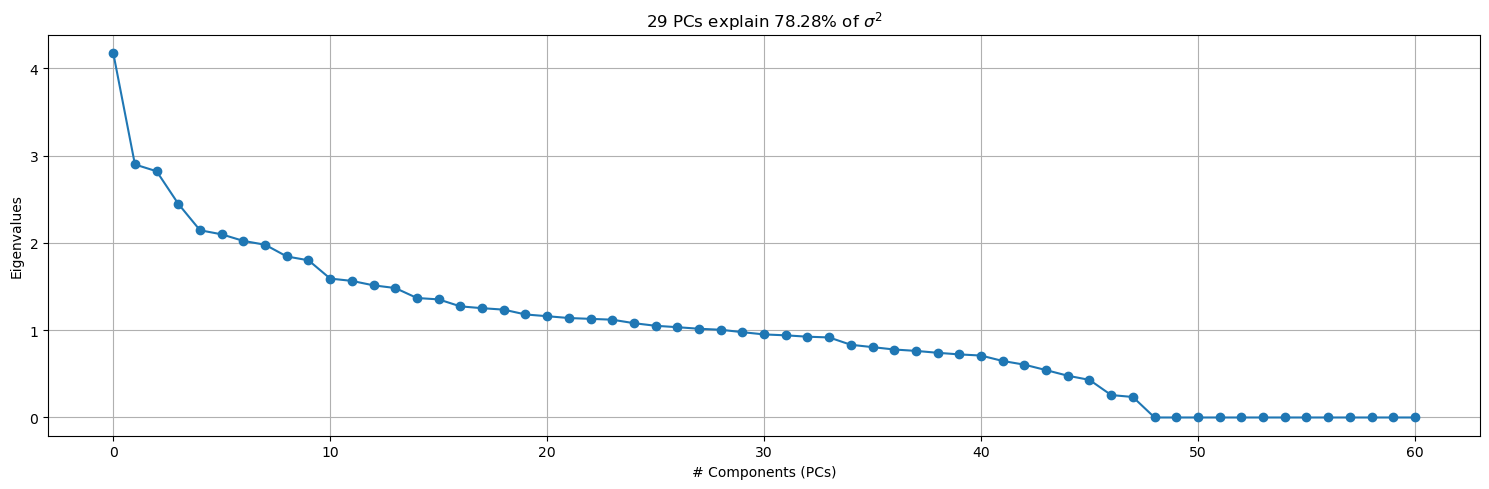

In [21]:
pca = PCA(random_state = RANDOM_STATE)
features = df_stds.columns.tolist()
features.remove("label")
pca.fit(df_stds[features])

explained_variance = pca.explained_variance_ratio_
perc_cumul_exp_var = np.cumsum(explained_variance) * 100

plt.figure(figsize=(15, 5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.grid()
plt.title(f'29 PCs explain {round(perc_cumul_exp_var[28], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

eigenvalues = pca.explained_variance_
print(eigenvalues[eigenvalues > 1])
plt.figure(figsize=(15, 5))
plt.plot(eigenvalues, marker='o')
plt.xlabel('# Components (PCs)')
plt.ylabel('Eigenvalues')
plt.title(f'29 PCs explain {round(perc_cumul_exp_var[28], 2)}% of $\sigma^2$')
plt.grid()
plt.tight_layout()
plt.show()

Using Kaiser method we select choose 29 as a possible number of PCs to select

In [24]:
pca = PCA(n_components=29, random_state=RANDOM_STATE)

pca.fit(df_stds[features])
pca_result = pca.transform(df_stds[features])

df_pca = pd.DataFrame(pca_result, columns=[f"pc_{i}" for i in range(29)])
df_pca['label'] = df_stds['label']
df_pca

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0    1.334464  3.259024  0.918577 -1.798817  0.055688  0.639808 -0.471168   
1   -1.999392 -1.302006 -1.693963  0.868091 -0.122285  1.015065  0.022702   
2   -0.462007  2.450922  2.085615 -0.676183 -0.561446 -1.225488  0.212335   
3    0.629867 -2.616213  2.663895  0.065587 -0.135602  4.234855 -1.917524   
4    2.536651 -0.601279  2.705425 -1.589173 -1.708845  0.665368 -1.084624   
..        ...       ...       ...       ...       ...       ...       ...   
995 -2.454520 -0.225663  0.057329 -0.757801 -0.212768 -1.258221  0.340243   
996  1.371935 -1.509879 -1.033068  0.330837  1.957149 -0.571625 -0.451422   
997 -0.655785  1.682973 -0.860412 -1.208645 -1.092789  1.743753  0.274758   
998  2.117036 -2.180451 -0.026499 -1.554284 -0.966637  2.723558 -0.443038   
999  1.492197  0.216820 -1.327582  0.385518  0.645210  0.083148  0.107091   

         pc_7      pc_8      pc_9  ...     pc_20     pc_21     pc_22  \
0   -1.869797  1.097434 -0.812796  ...  1.809843  0.137119  0.573663   
1   -0.278729 -0.456537  2.141307  ...  0.357754  0.338571  0.222007   
2   -0.531590 -1.031386  0.860746  ... -1.040538  0.249000  1.689641   
3    0.478854 -1.134898 -0.449026  ... -1.111248  1.086387  0.888226   
4    1.249811 -2.692922  2.159328  ...  1.001872 -1.151264 -1.311464   
..        ...       ...       ...  ...       ...       ...       ...   
995 -1.058707 -0.213792 -0.368356  ... -0.936637 -0.272950  1.308757   
996 -1.678339 -2.078853 -1.464802  ... -1.140250 -0.379537 -0.192985   
997 -1.412397 -0.727211 -0.599752  ...  0.130949  0.030474 -0.351795   
998 -0.821155 -1.931286  0.504908  ...  0.373404 -0.124889  0.560129   
999  1.141245  0.313689  2.091335  ... -0.810754  1.866055 -0.965660   

        pc_23     pc_24     pc_25     pc_26     pc_27     pc_28  label  
0   -1.033857 -0.118348 -0.068368 -0.384871  0.997512 -0.387573      1  
1   -0.003087 -0.655597 -0.754755 -1.585266  0.689385  0.481734      2  
2    1.069660 -0.298871  0.244545  1.885863  0.823922 -0.396141      1  
3    0.356538 -1.683879  0.237099  0.007397 -0.435678  0.813352      1  
4   -0.487260 -1.142026 -0.343590  0.524833  0.765841  1.524412      2  
..        ...       ...       ...       ...       ...       ...    ...  
995  1.663385 -0.575703 -1.512313 -0.545561  0.239450  0.207512      1  
996 -1.644056 -1.514115  1.576924  0.664141 -1.347534 -1.168511      1  
997  1.185836 -0.539263 -0.328117  0.191004 -0.315198  0.022817      1  
998 -0.351358  0.232903 -0.106761 -1.170021  0.152007 -0.279919      2  
999 -1.318868 -0.508369  1.215485 -0.725650 -1.023142 -1.638603      1  

[1000 rows x 30 columns]

In [25]:
from sklearn.model_selection import train_test_split

X_pca, X_pca_test, y_pca, y_pca_test = train_test_split(
    df_pca.loc[:, df_pca.columns != 'label'],
    df_pca['label'],
    train_size=0.8,
    stratify=df_pca['label'],
    random_state=RANDOM_STATE
)

#### t-SNE visualization

In [26]:
from sklearn.manifold import TSNE

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


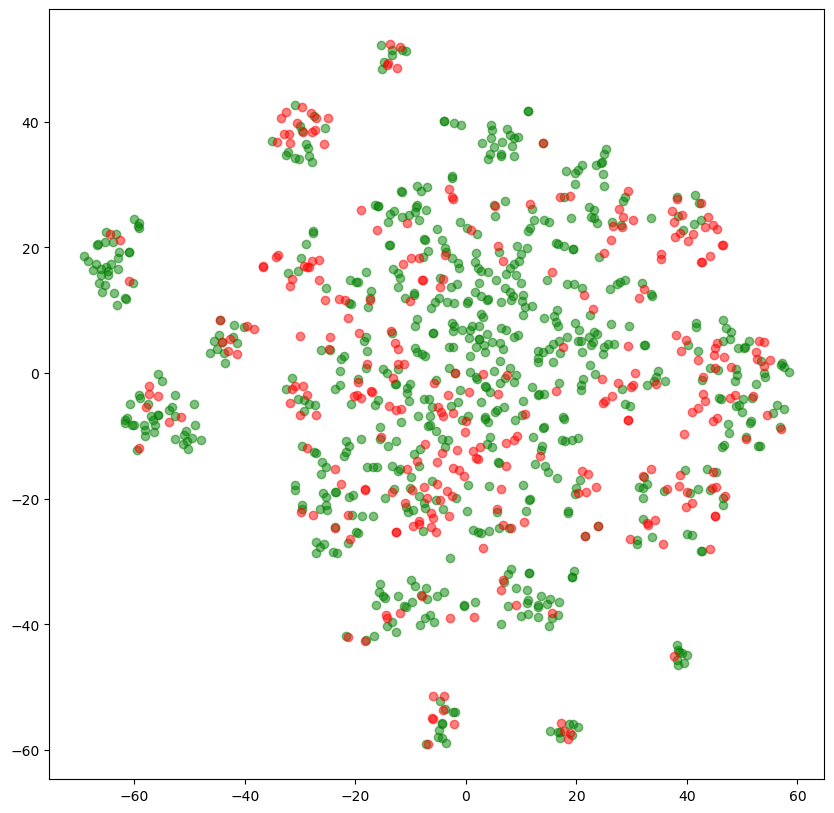

In [27]:
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    perplexity=15,
    random_state=RANDOM_STATE,
    init='pca'
)
X_nembed = tsne.fit_transform(df_stds[features])

plt.figure(figsize=(10,10))
plt.scatter(X_nembed[df_stds['label'] == 1,0], X_nembed[df_stds['label'] == 1,1], color='green', alpha=.5)
plt.scatter(X_nembed[df_stds['label'] == 2,0], X_nembed[df_stds['label'] == 2,1], color='red', alpha=.5)

plt.show()

### 2.2 Unsupervised Data Analysis

#### k-Means clustering (on PCA transformed data)

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

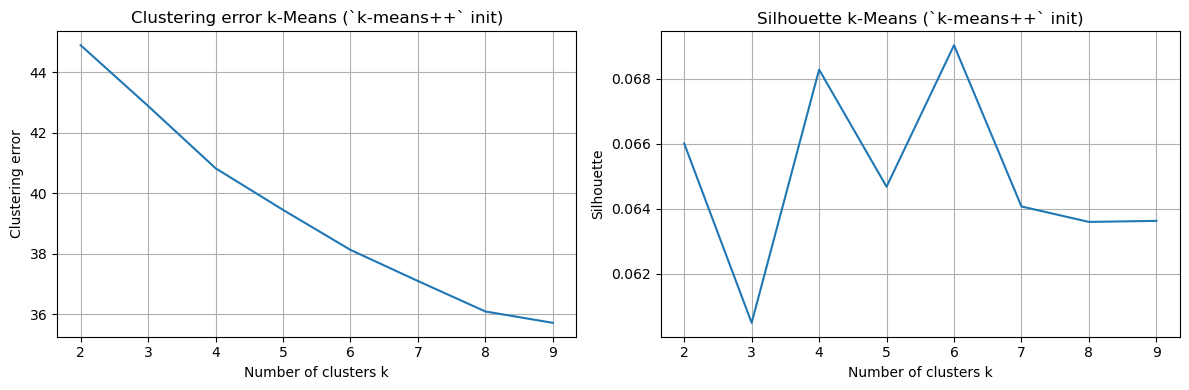

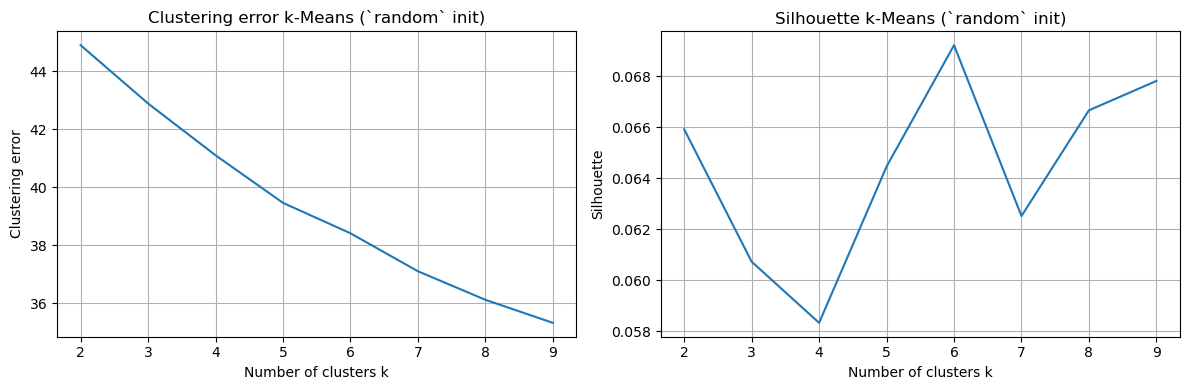

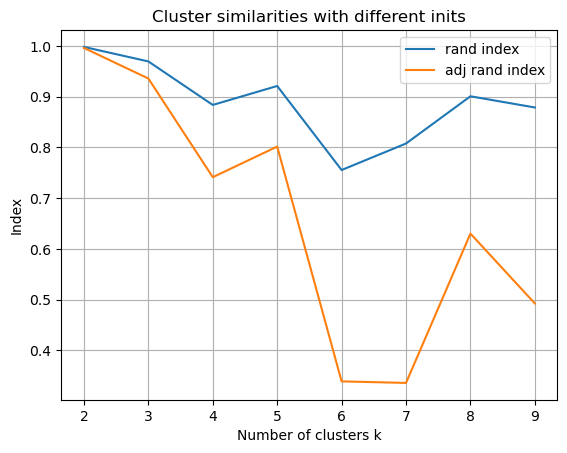

In [29]:
kmeans_sizes = list(range(2,10))
kmeans_errors = [[],[]]
kmeans_silhouettes = [[],[]]
kmeans_rand_scores = []
kmeans_adj_rand_scores = []
_pca_clustering_X = df_pca.loc[:, df_pca.columns != 'label']

for k in kmeans_sizes:
    # k-means with greedy k-means++ init
    km_1 = KMeans(n_clusters=k, init='k-means++', n_init=12, random_state=RANDOM_STATE)
    km_1.fit(_pca_clustering_X)
    kmeans_errors[0].append(km_1.inertia_ / len(_pca_clustering_X))
    kmeans_silhouettes[0].append(silhouette_score(_pca_clustering_X, km_1.labels_))
    # k-means with random init
    km_2 = KMeans(n_clusters=k, init='random', n_init=12, random_state=RANDOM_STATE)
    km_2.fit(_pca_clustering_X)
    kmeans_errors[1].append(km_2.inertia_ / len(_pca_clustering_X))
    kmeans_silhouettes[1].append(silhouette_score(_pca_clustering_X, km_2.labels_))
    # clustering comparison
    kmeans_rand_scores.append(rand_score(km_1.labels_, km_2.labels_))
    kmeans_adj_rand_scores.append(adjusted_rand_score(km_1.labels_, km_2.labels_))
    
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(kmeans_sizes, kmeans_errors[0])
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].set_title('Clustering error k-Means (`k-means++` init)')
axs[0].grid()
axs[1].plot(kmeans_sizes, kmeans_silhouettes[0])
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].set_title('Silhouette k-Means (`k-means++` init)')
axs[1].grid()
plt.tight_layout()
plt.show()
# seems best for 5

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(kmeans_sizes, kmeans_errors[1])
axs[0].set_xlabel("Number of clusters k")
axs[0].set_ylabel("Clustering error")
axs[0].set_title('Clustering error k-Means (`random` init)')
axs[0].grid()
axs[1].plot(kmeans_sizes, kmeans_silhouettes[1])
axs[1].set_xlabel("Number of clusters k")
axs[1].set_ylabel("Silhouette")
axs[1].set_title('Silhouette k-Means (`random` init)')
axs[1].grid()
plt.tight_layout()
plt.show()
# seems best for 4 or 8

plt.figure()
plt.plot(kmeans_sizes, kmeans_rand_scores, label='rand index')
plt.plot(kmeans_sizes, kmeans_adj_rand_scores, label='adj rand index')
plt.xlabel("Number of clusters k")
plt.ylabel("Index")
plt.title('Cluster similarities with different inits')
plt.legend()
plt.grid()
plt.show()

k-Means - n_clusters=6
Cluster 0 (310) - 0.81 purity of 1
Cluster 1 (37) - 0.89 purity of 1
Cluster 2 (145) - 0.62 purity of 1
Cluster 3 (307) - 0.67 purity of 1
Cluster 4 (120) - 0.55 purity of 1
Cluster 5 (81) - 0.67 purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  # This is added back by InteractiveShellApp.init_path()


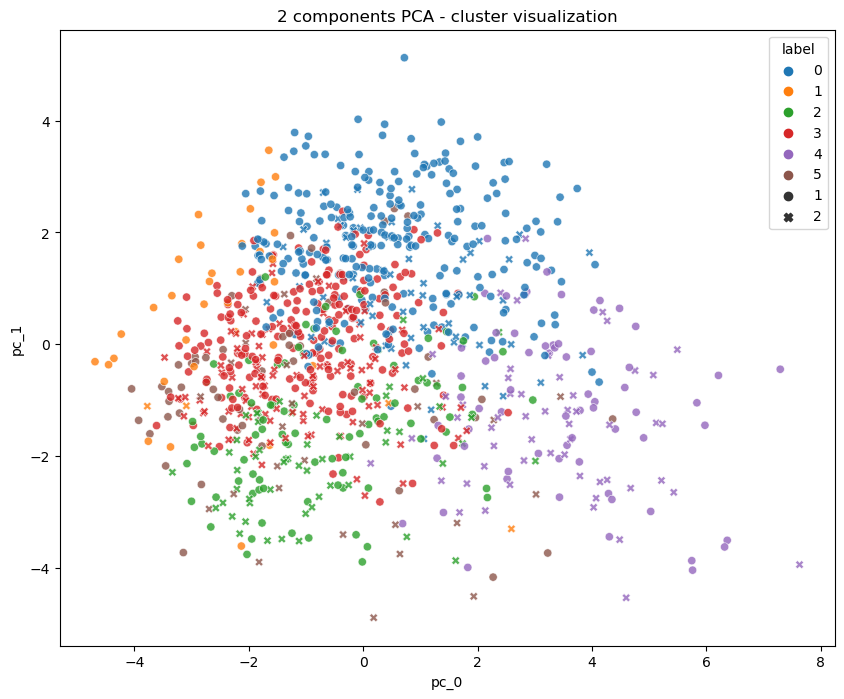

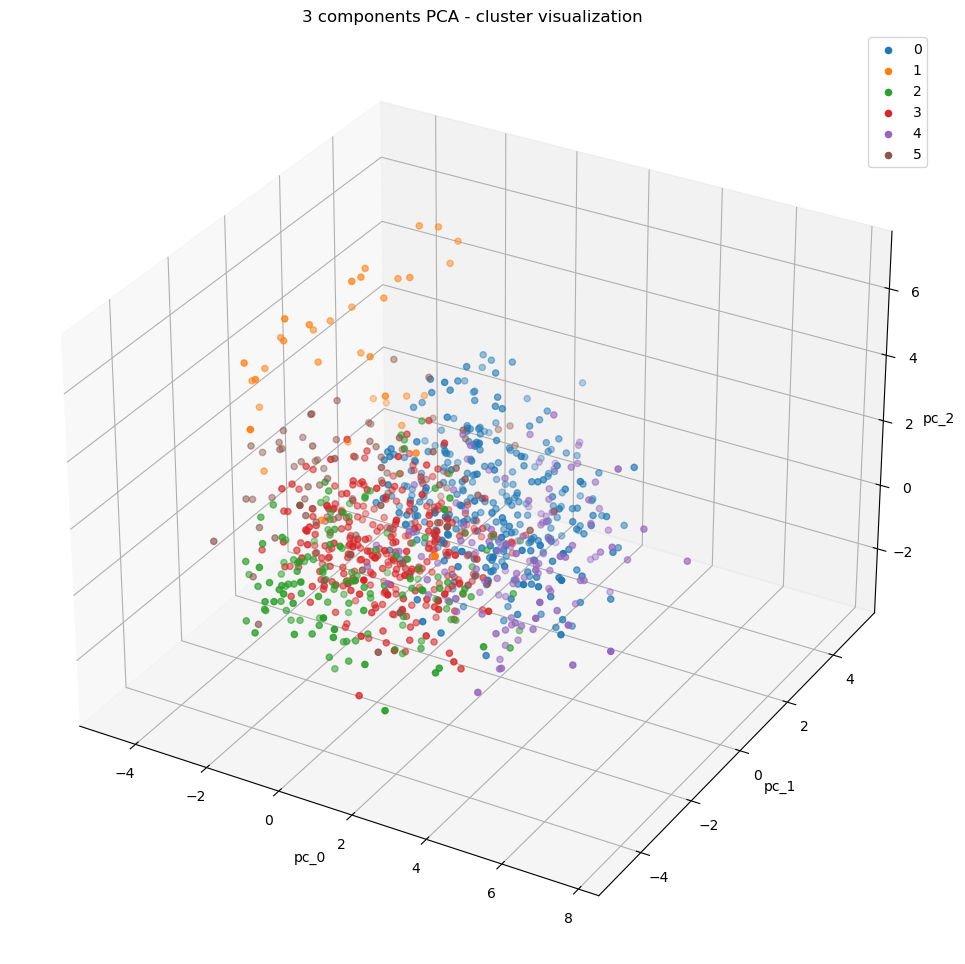

In [30]:
print("k-Means - n_clusters=6")
km = KMeans(n_clusters=6, init='k-means++', n_init=12, random_state=RANDOM_STATE)
km.fit(_pca_clustering_X)

cluster_sizes = np.bincount(km.labels_)
purity = np.bincount(km.labels_[df_pca['label'] == 1]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i,cluster_sizes[i],_) for i,_ in enumerate(purity)]))

# 2d visualization
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=km.labels_, style=df_pca['label'], alpha=.8, palette=sns.color_palette())
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

# 3d visualization
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
for k in set(km.labels_):
    ax.scatter(_pca_clustering_X.loc[km.labels_ == k, 'pc_0'],_pca_clustering_X.loc[km.labels_ == k, 'pc_1'],_pca_clustering_X.loc[km.labels_ == k, 'pc_2'],label=k)
ax.legend()
ax.set_xlabel('pc_0')
ax.set_ylabel('pc_1')
ax.set_zlabel('pc_2')
ax.set_title('3 components PCA - cluster visualization')
plt.show()

In [34]:
for i in set(km.labels_):
    print(f"Cluster {i}:")
    tmp = df_processed[km.labels_==i]
    for label in categorical_features_hotencoded:
        if tmp.groupby(label).count().iloc[:,1].size == 1:
            print(label, tmp.groupby(label).count().iloc[:,1].index[0])
    print()

Cluster 0:
purpose_A44 0.0
housing_A153 0.0
other_debtors_guarantors_A102 0.0
foreign_worker_A202 0.0
foreign_worker_A201 1.0
other_debtors_guarantors_A103 0.0
other_debtors_guarantors_A101 1.0

Cluster 1:
purpose_A44 0.0
housing_A153 0.0
foreign_worker_A202 1.0
present_employment_since_A71 0.0
other_installment_plans_A142 0.0
foreign_worker_A201 0.0
purpose_A46 0.0
purpose_A48 0.0
credit_history_A33 0.0

Cluster 2:
housing_A153 0.0
other_debtors_guarantors_A102 0.0
foreign_worker_A202 0.0
foreign_worker_A201 1.0
other_debtors_guarantors_A103 0.0
housing_A151 1.0
other_debtors_guarantors_A101 1.0
purpose_A410 0.0
housing_A152 0.0

Cluster 3:
housing_A153 0.0
other_debtors_guarantors_A102 0.0
foreign_worker_A202 0.0
foreign_worker_A201 1.0
other_debtors_guarantors_A103 0.0
housing_A151 0.0
other_debtors_guarantors_A101 1.0
purpose_A410 0.0
housing_A152 1.0

Cluster 4:
purpose_A44 0.0
foreign_worker_A202 0.0
foreign_worker_A201 1.0
other_debtors_guarantors_A103 0.0
purpose_A48 0.0

Clust

#### DBSCAN clustering (on PCA transformed data)

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

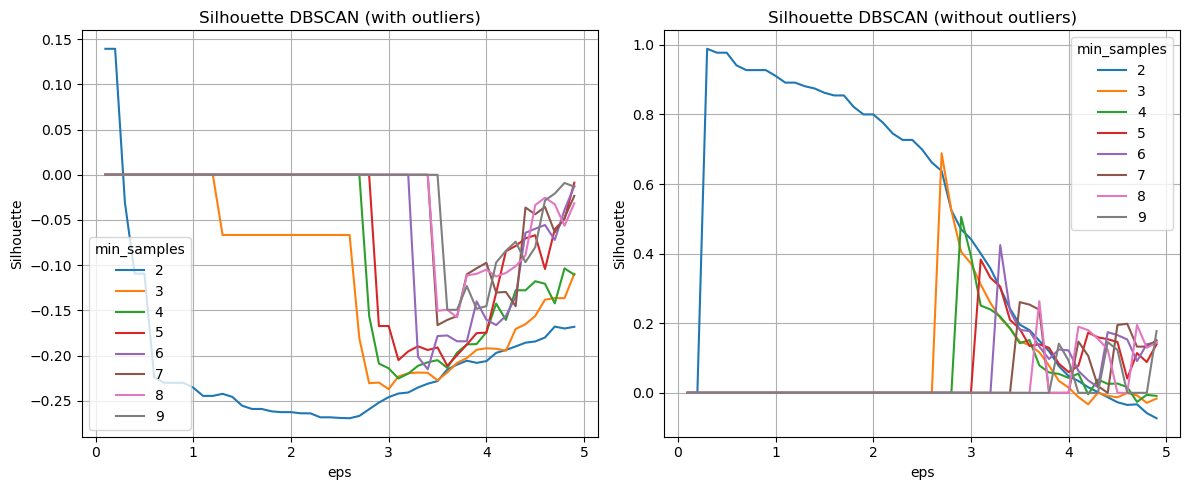

In [33]:
dbscan_nsamples_sizes = list(range(2,10))
dbscan_eps_sizes = np.arange(.1, 5, .1)
_pca_clustering_X = df_pca.loc[:, df_pca.columns != 'label']

fig, axs = plt.subplots(1,2, figsize=(12,5))
for s in dbscan_nsamples_sizes:
    dbscan_silhouettes = []
    dbscan_silhouettes_cleaned = []
    for e in dbscan_eps_sizes:
        dbscan = DBSCAN(eps=e, min_samples=s)
        dbscan.fit(_pca_clustering_X)
        
        dbscan_silhouettes.append(silhouette_score(_pca_clustering_X, dbscan.labels_) if len(set(dbscan.labels_)) > 1 else 0)
        dbscan_silhouettes_cleaned.append(silhouette_score(_pca_clustering_X[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]) if len(set(dbscan.labels_[dbscan.labels_ != -1])) > 1 else 0 )
        
    axs[0].plot(dbscan_eps_sizes, dbscan_silhouettes, label=f'{s}')
    axs[1].plot(dbscan_eps_sizes, dbscan_silhouettes_cleaned, label=f'{s}')

axs[0].set_title('Silhouette DBSCAN (with outliers)')
axs[0].set_xlabel('eps')
axs[0].set_ylabel('Silhouette')
axs[0].legend(title='min_samples')
axs[0].grid()
axs[1].set_title('Silhouette DBSCAN (without outliers)')
axs[1].set_xlabel('eps')
axs[1].set_ylabel('Silhouette')
axs[1].legend(title='min_samples')
axs[1].grid()
plt.tight_layout()
plt.show()

DBSCAN - eps=4.5, min_samples=6
Cluster 1 (284) - 0.79 purity of 1
Cluster 2 (8) - 1.00 purity of 1
Cluster 3 (6) - 0.83 purity of 1
Outliers: 702 - 0.66 purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The palette list has more values (20) than needed (4), which may not be intended.
  del sys.path[0]


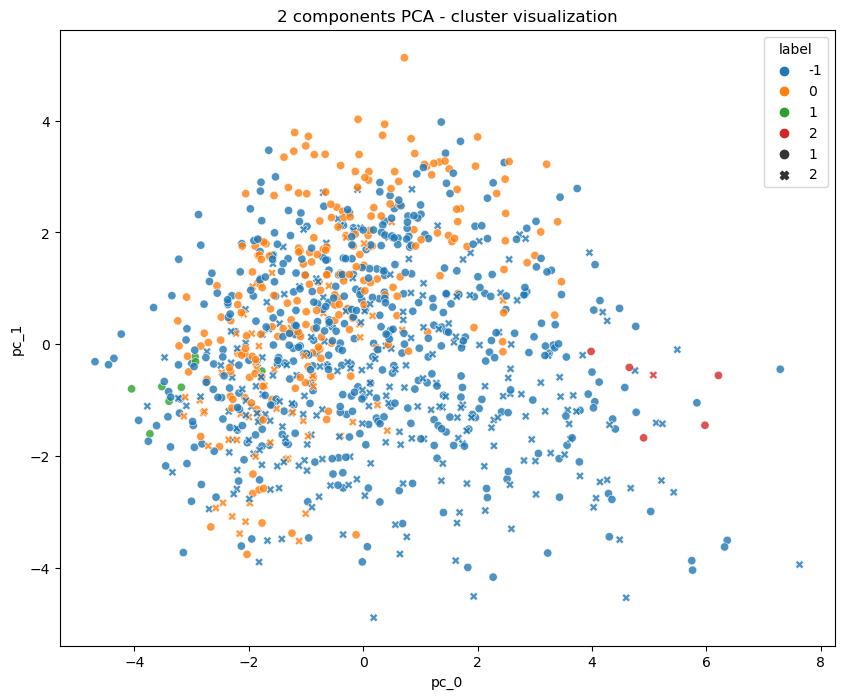

In [40]:
print(f"DBSCAN - eps=4.5, min_samples=6")
dbscan = DBSCAN(eps=4.5, min_samples=6)
dbscan.fit(_pca_clustering_X)

cluster_sizes = np.bincount(dbscan.labels_[dbscan.labels_ != -1])
outliers = (dbscan.labels_ == -1).sum()
purity = np.bincount(dbscan.labels_[(dbscan.labels_ != -1) & (df_pca['label'] == 1)]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i+1,cluster_sizes[i],_) for i,_ in enumerate(purity)]))
print("Outliers: %d - %.2f purity of 1" % (outliers, abs(dbscan.labels_[(dbscan.labels_ == -1) & (df_pca['label'] == 1)].sum()) / outliers))

# 2d visualization
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=dbscan.labels_, style=df_pca['label'], alpha=.8, palette=sns.color_palette() + sns.color_palette('husl',10))
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

In [41]:
for i in set(dbscan.labels_):
    print(f"Cluster {i}:")
    tmp = df_processed[km.labels_==i]
    for label in categorical_features_hotencoded:
        if tmp.groupby(label).count().iloc[:,1].size == 1:
            print(label, tmp.groupby(label).count().iloc[:,1].index[0])
    print()

Cluster 0:
purpose_A44 0.0
housing_A153 0.0
other_debtors_guarantors_A102 0.0
foreign_worker_A202 0.0
foreign_worker_A201 1.0
other_debtors_guarantors_A103 0.0
other_debtors_guarantors_A101 1.0

Cluster 1:
purpose_A44 0.0
housing_A153 0.0
foreign_worker_A202 1.0
present_employment_since_A71 0.0
other_installment_plans_A142 0.0
foreign_worker_A201 0.0
purpose_A46 0.0
purpose_A48 0.0
credit_history_A33 0.0

Cluster 2:
housing_A153 0.0
other_debtors_guarantors_A102 0.0
foreign_worker_A202 0.0
foreign_worker_A201 1.0
other_debtors_guarantors_A103 0.0
housing_A151 1.0
other_debtors_guarantors_A101 1.0
purpose_A410 0.0
housing_A152 0.0

Cluster -1:



#### k-Prototypes clustering (on mixed data)

In [29]:
from kmodes.kprototypes import KPrototypes
from kmodes.util.dissim import euclidean_dissim, jaccard_dissim_binary
from sklearn.metrics import silhouette_score

def custom_distance_metric(a_num, a_cat, b_num, b_cat, g):
    return euclidean_dissim(a_num, b_num) + g * jaccard_dissim_binary(a_cat, b_cat)

In [30]:
# dataset for clustering (no label feature)
clustering_X = df_mms.loc[:,df_mms.columns != 'label']

_non_categorical_indexer = clustering_X.columns.get_indexer(non_categorical_features).tolist()
_categorical_indexer = clustering_X.columns.get_indexer(categorical_features_hotencoded).tolist()
# precompute distance matrix following k-prototypes internal implementation
_gamma = 0.5 * np.mean(clustering_X.loc[:,non_categorical_features].std(axis=0))

_distance_matrix = np.array([custom_distance_metric(
        clustering_X.to_numpy()[:,_non_categorical_indexer],
        clustering_X.to_numpy()[:,_categorical_indexer].astype(int),
        clustering_X.to_numpy()[i,_non_categorical_indexer],
        clustering_X.to_numpy()[i,_categorical_indexer].astype(int),
        _gamma
    ) for i in range(len(clustering_X))])
_gamma

0.13080245046463496

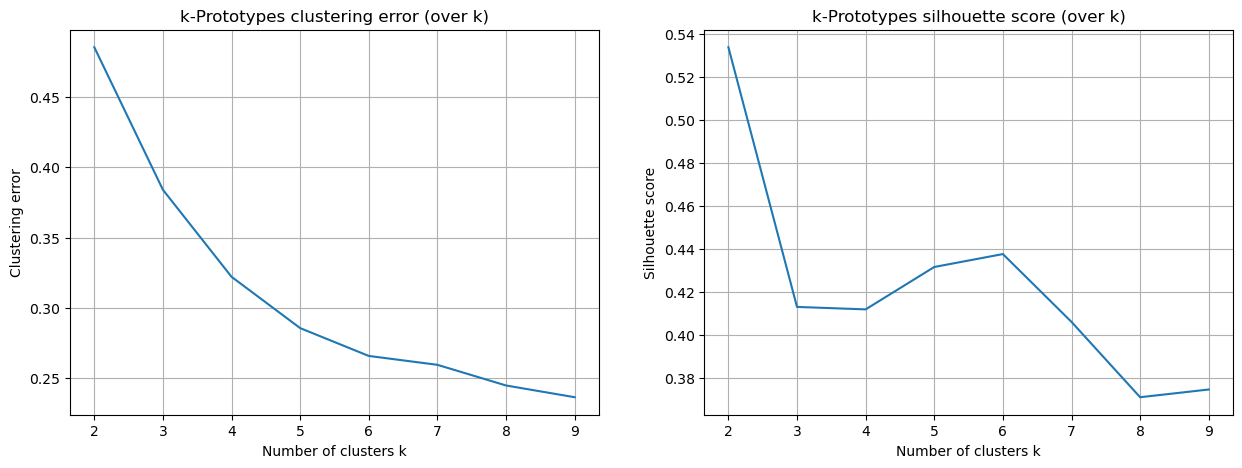

In [31]:
kmeans_sizes = list(range(2,10))
kmeans_errors = []
kmeans_silhouettes = []

for k in kmeans_sizes:
    kprot = KPrototypes(n_clusters=k, num_dissim=euclidean_dissim, cat_dissim=jaccard_dissim_binary, gamma=_gamma, n_jobs=-1)
    kprot.fit(clustering_X, categorical=_categorical_indexer)
    kmeans_errors.append(kprot.cost_ / len(df_processed))
    kmeans_silhouettes.append(silhouette_score(_distance_matrix, kprot.labels_, metric='precomputed'))
    
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(kmeans_sizes, kmeans_errors)
axs[0].set_title('k-Prototypes clustering error (over k)')
axs[0].set_xlabel('Number of clusters k')
axs[0].set_ylabel('Clustering error')
axs[0].grid()
axs[1].plot(kmeans_sizes, kmeans_silhouettes)
axs[1].set_title('k-Prototypes silhouette score (over k)')
axs[1].set_xlabel('Number of clusters k')
axs[1].set_ylabel('Silhouette score')
axs[1].grid()
plt.show()

Best number of clusters maximizing silhouette and minimizing the clustering error is $k = 6$

k-Prototypes - n_clusters=6
Cluster 0 (74) - 0.77 purity of 1
Cluster 1 (303) - 0.68 purity of 1
Cluster 2 (138) - 0.70 purity of 1
Cluster 3 (81) - 0.64 purity of 1
Cluster 4 (163) - 0.75 purity of 1
Cluster 5 (241) - 0.69 purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  # This is added back by InteractiveShellApp.init_path()


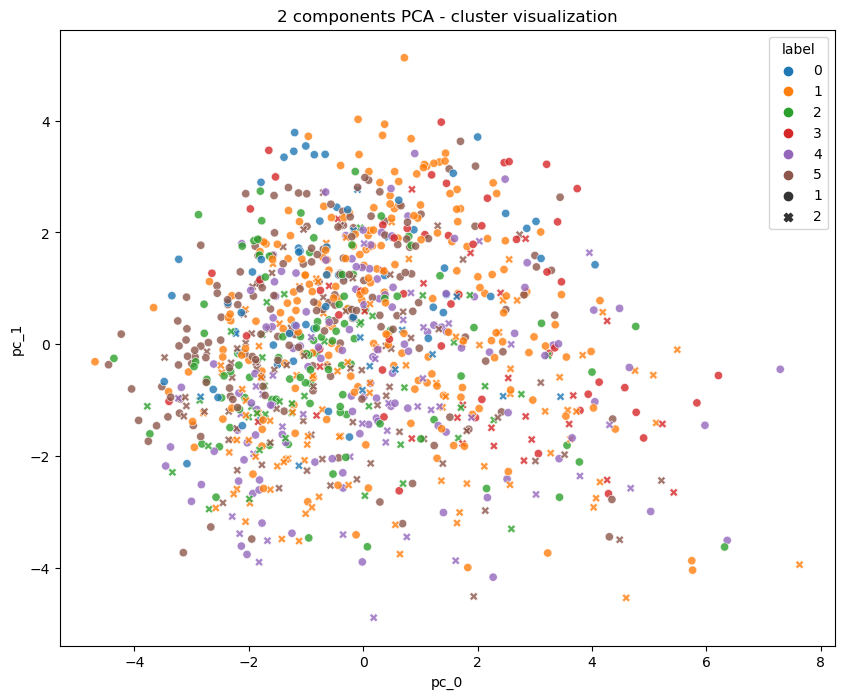

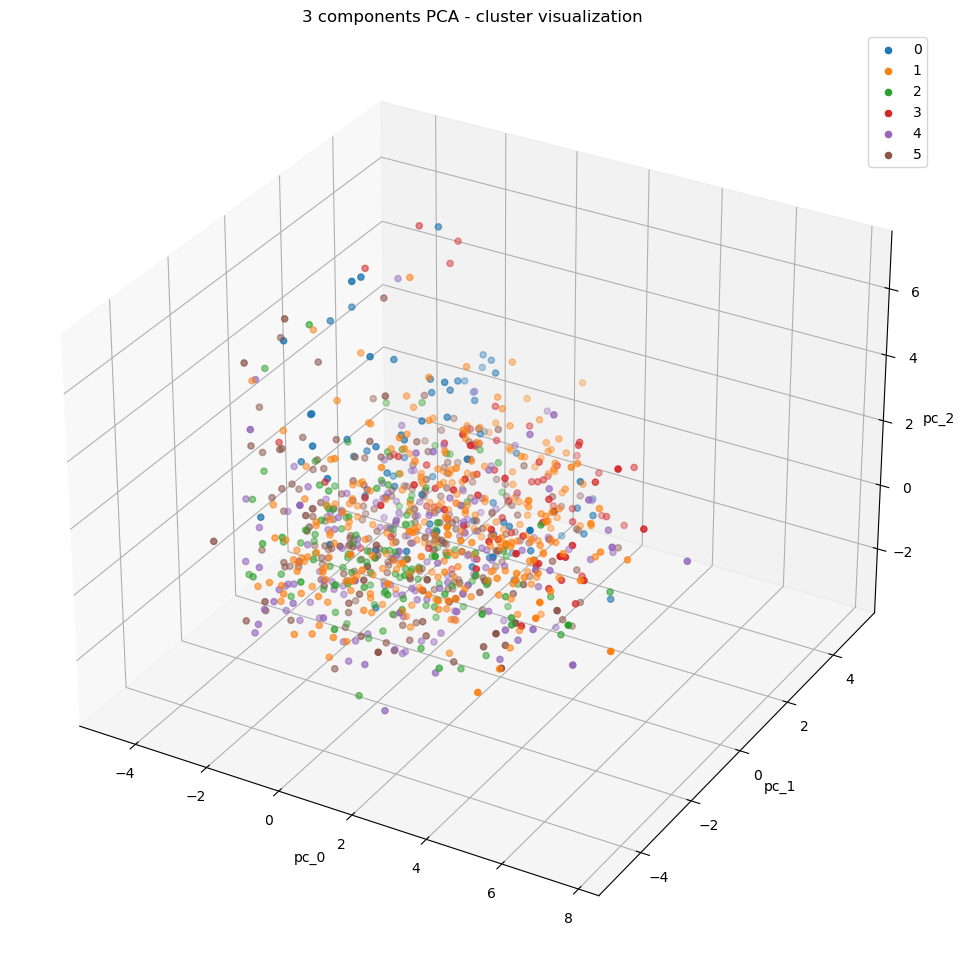

In [32]:
print(f"k-Prototypes - n_clusters=6")
kp = KPrototypes(n_clusters=6, num_dissim=euclidean_dissim, cat_dissim=jaccard_dissim_binary, gamma=_gamma, n_jobs=-1)
kp.fit(clustering_X, categorical=_categorical_indexer)

cluster_sizes = np.bincount(kp.labels_)
purity = np.bincount(kp.labels_[df_mms['label'] == 1]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i,cluster_sizes[i],_) for i,_ in enumerate(purity)]))

# 2d visualization (over PCA)
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=kp.labels_, style=df_mms['label'], alpha=.8, palette=sns.color_palette())
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

# 3d visualization (over PCA)
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
for k in set(kp.labels_):
    ax.scatter(_pca_clustering_X.loc[kp.labels_ == k, 'pc_0'],_pca_clustering_X.loc[kp.labels_ == k, 'pc_1'],_pca_clustering_X.loc[kp.labels_ == k, 'pc_2'],label=k)
ax.legend()
ax.set_xlabel('pc_0')
ax.set_ylabel('pc_1')
ax.set_zlabel('pc_2')
ax.set_title('3 components PCA - cluster visualization')
plt.show()

In [33]:
for i in set(kp.labels_):
    print(f"Cluster {i}:")
    tmp = df_processed[km.labels_==i]
    for label in categorical_features_hotencoded:
        if tmp.groupby(label).count().iloc[:,1].size == 1:
            print(label)
    print()

Cluster 0:
foreign_worker_A201
housing_A151
purpose_A45
foreign_worker_A202
purpose_A410
housing_A153
housing_A152
other_debtors_guarantors_A103

Cluster 1:
purpose_A48
foreign_worker_A201
purpose_A44
credit_history_A33
purpose_A46
present_employment_since_A71
foreign_worker_A202
housing_A153
other_installment_plans_A142

Cluster 2:
purpose_A48
savings_account_bonds_A63
foreign_worker_A201
other_debtors_guarantors_A101
purpose_A44
credit_history_A33
purpose_A46
present_employment_since_A71
foreign_worker_A202
job_A171
savings_account_bonds_A64
other_debtors_guarantors_A102
other_debtors_guarantors_A103

Cluster 3:
foreign_worker_A201
foreign_worker_A202
purpose_A410
housing_A153
job_A171
job_A174
other_debtors_guarantors_A103

Cluster 4:
foreign_worker_A201
job_A172
housing_A151
foreign_worker_A202
purpose_A410
housing_A153
job_A171
housing_A152
other_debtors_guarantors_A103

Cluster 5:
foreign_worker_A201
job_A172
present_employment_since_A74
credit_history_A30
foreign_worker_A202
sav

#### DBSCAN clustering (on mixed data, custom distance metric)

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

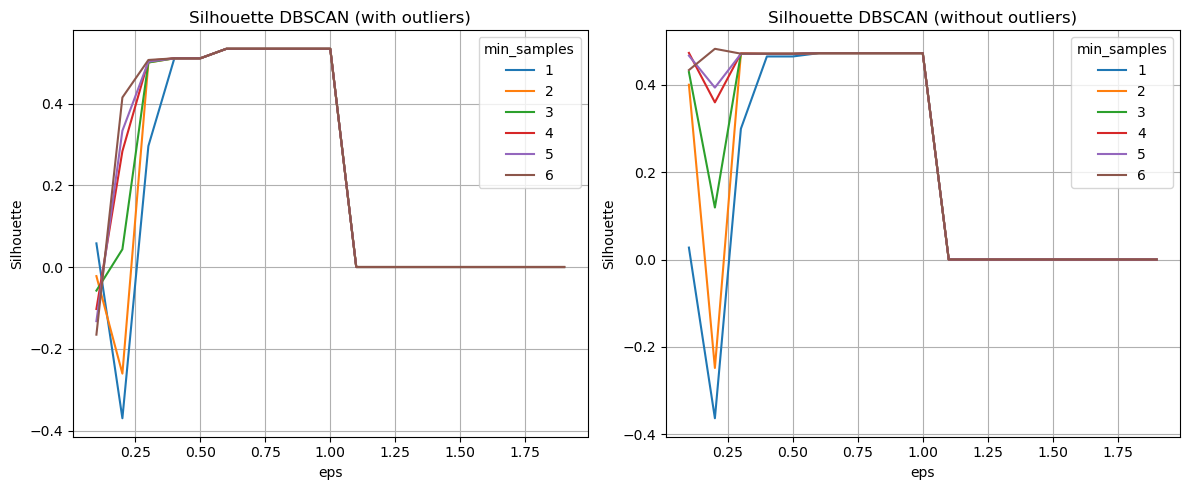

In [35]:
dbscan_nsamples_sizes = list(range(1,7))
dbscan_eps_sizes = np.arange(.1, 2, .1)
clustering_X = df_pca.loc[:, df_pca.columns != 'label']

fig, axs = plt.subplots(1,2, figsize=(12,5))
for s in dbscan_nsamples_sizes:
    dbscan_silhouettes = []
    dbscan_silhouettes_cleaned = []
    for e in dbscan_eps_sizes:
        dbscan = DBSCAN(eps=e, min_samples=s, metric='precomputed')
        dbscan.fit(_distance_matrix)
        
        dbscan_silhouettes.append(silhouette_score(_distance_matrix, dbscan.labels_, metric='precomputed') if len(set(dbscan.labels_)) > 1 else 0)
        dbscan_silhouettes_cleaned.append(silhouette_score(_distance_matrix[np.ix_(dbscan.labels_ != -1, dbscan.labels_ != -1)], dbscan.labels_[dbscan.labels_ != -1]) if len(set(dbscan.labels_[dbscan.labels_ != -1])) > 1 else 0 )
        
    axs[0].plot(dbscan_eps_sizes, dbscan_silhouettes, label=f'{s}')
    axs[1].plot(dbscan_eps_sizes, dbscan_silhouettes_cleaned, label=f'{s}')

axs[0].set_title('Silhouette DBSCAN (with outliers)')
axs[0].set_xlabel('eps')
axs[0].set_ylabel('Silhouette')
axs[0].legend(title='min_samples')
axs[0].grid()
axs[1].set_title('Silhouette DBSCAN (without outliers)')
axs[1].set_xlabel('eps')
axs[1].set_ylabel('Silhouette')
axs[1].legend(title='min_samples')
axs[1].grid()
plt.tight_layout()
plt.show()

DBSCAN - eps=.75, min_samples=3
Cluster 1 (845) - 0.70 purity of 1
Cluster 2 (155) - 0.70 purity of 1
Outliers: 0 - nan purity of 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  del sys.path[0]


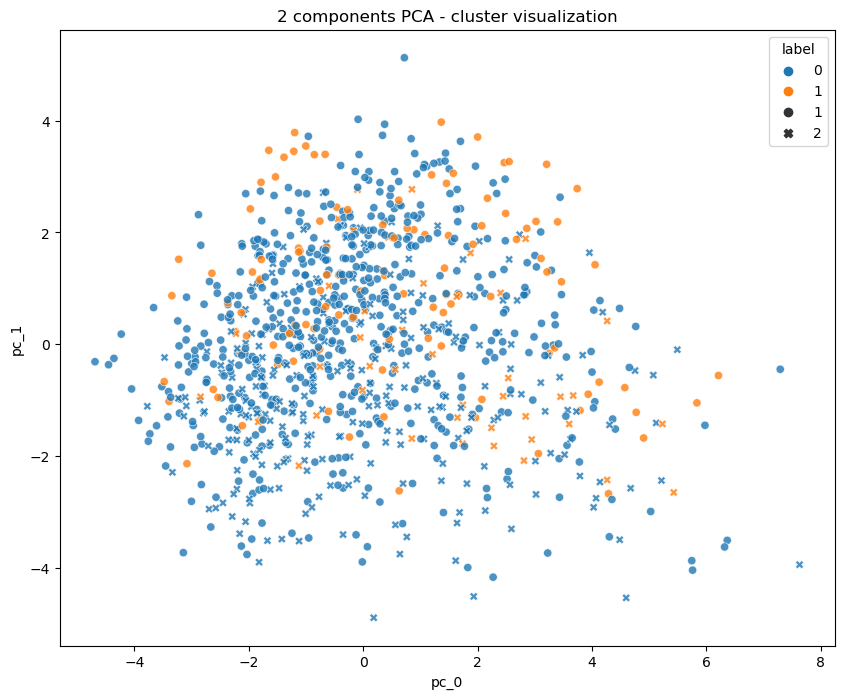

In [36]:
print(f"DBSCAN - eps=.75, min_samples=3")
dbscan = DBSCAN(eps=.75, min_samples=3, metric='precomputed')
dbscan.fit(_distance_matrix)

cluster_sizes = np.bincount(dbscan.labels_[dbscan.labels_ != -1])
outliers = (dbscan.labels_ == -1).sum()
purity = np.bincount(dbscan.labels_[(dbscan.labels_ != -1) & (df_processed['label'] == 1)]) / cluster_sizes
print("\n".join(["Cluster %d (%d) - %.2f purity of 1" % (i+1,cluster_sizes[i],_) for i,_ in enumerate(purity)]))
print("Outliers: %d - %.2f purity of 1" % (outliers, abs(dbscan.labels_[(dbscan.labels_ == -1) & (df_processed['label'] == 1)].sum()) / outliers))

# 2d visualization
plt.figure(figsize=(10,8))
sns.scatterplot(_pca_clustering_X, x='pc_0', y='pc_1', hue=dbscan.labels_, style=df_pca['label'], alpha=.8, palette=sns.color_palette())
plt.title('2 components PCA - cluster visualization')
plt.xlabel('pc_0')
plt.ylabel('pc_1')
plt.show()

In [37]:
for i in set(dbscan.labels_):
    print(f"Cluster {i}:")
    tmp = df_processed[km.labels_==i]
    for label in categorical_features_hotencoded:
        if tmp.groupby(label).count().iloc[:,1].size == 1:
            print(label)
    print()

Cluster 0:
foreign_worker_A201
housing_A151
purpose_A45
foreign_worker_A202
purpose_A410
housing_A153
housing_A152
other_debtors_guarantors_A103

Cluster 1:
purpose_A48
foreign_worker_A201
purpose_A44
credit_history_A33
purpose_A46
present_employment_since_A71
foreign_worker_A202
housing_A153
other_installment_plans_A142



## 3 Supervised Data analysis

### 3.1 Classifier Selection

We are going to experiment with the following classifiers to get a first overview of the most promising models to further select for the cross-validation step
- Support Vector Machine [SVM] (linear model with regularized Hinge loss)
- Logistic Regression [LR] (linear model with logistic loss)
- Decision Tree [DT] / Random Forest [RF] (non linear model)
- k-Nearest Neighbours [kNN]
- Multi-Layer Perceptron [MLP]

In [42]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, zero_one_loss

In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    train_size=.85,
    stratify=y,
    random_state=RANDOM_STATE
)

X_pca_train, X_pca_val, y_pca_train, y_pca_val = train_test_split(
    X_pca,
    y_pca,
    train_size=.85,
    stratify=y_pca,
    random_state=RANDOM_STATE
)

CLASS_WEIGHT = {1: 0.17, 2: 0.83}
CLASS_WEIGHT_NN = {0: 0.17, 1: 0.83}

In [44]:
Xpca_train = pd.DataFrame(pca.transform(X_train), columns=[f"pc_{i}" for i in range(29)])
Xpca_val = pd.DataFrame(pca.transform(X_val), columns=[f"pc_{i}" for i in range(29)])

In [45]:
def plot_confusion_matrix(y_true, y_pred, title_ext=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), xticklabels=["1","2"], yticklabels=["1","2"], fmt=".3g", cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
    plt.tick_params(axis='both', labelbottom=False, bottom=False, top=True, labeltop=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix' + (f' {title_ext}' if title_ext else ''))
    plt.show()

#### 3.1.1 Support Vector Machine

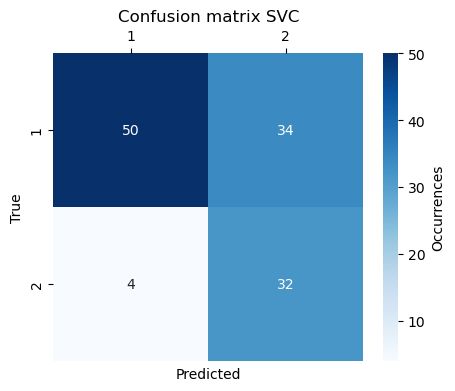

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.68 - Validation accuracy: 0.68
Train accuracy (balanced): 0.75 - Validation accuracy (balanced): 0.74


In [46]:
svc = LinearSVC(class_weight=CLASS_WEIGHT)
svc.fit(X_train, y_train)

preds = svc.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = svc.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'SVC')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

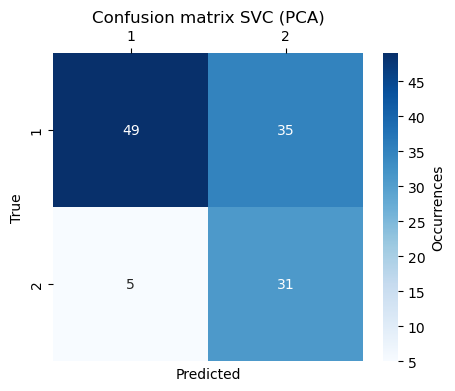

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.67 - Validation accuracy: 0.67
Train accuracy (balanced): 0.74 - Validation accuracy (balanced): 0.72


In [47]:
svc = LinearSVC(class_weight=CLASS_WEIGHT)
svc.fit(Xpca_train, y_train)

preds = svc.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = svc.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'SVC (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.2 Logistic Regression

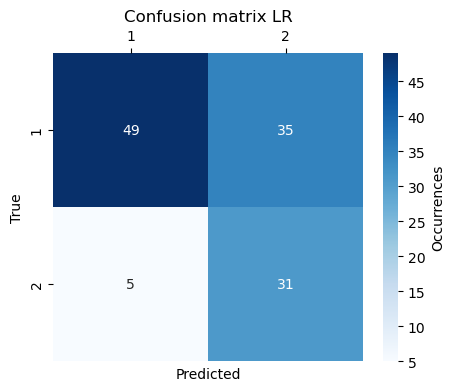

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.66 - Validation accuracy: 0.67
Train accuracy (balanced): 0.74 - Validation accuracy (balanced): 0.72


In [48]:
lr = LogisticRegression(class_weight=CLASS_WEIGHT)
lr.fit(X_train, y_train)

preds = lr.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = lr.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'LR')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

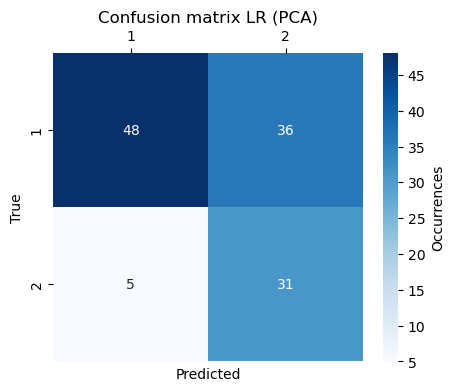

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.66 - Validation accuracy: 0.66
Train accuracy (balanced): 0.73 - Validation accuracy (balanced): 0.72


In [49]:
lr = LogisticRegression(class_weight=CLASS_WEIGHT)
lr.fit(Xpca_train, y_train)

preds = lr.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = lr.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'LR (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.3 Decision Tree

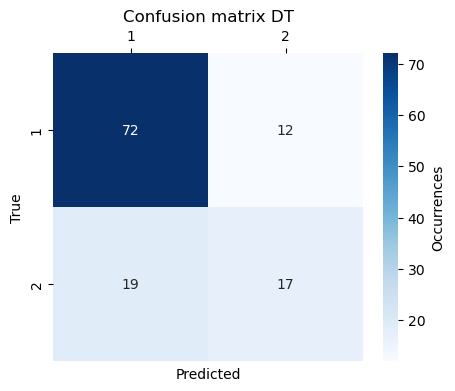

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.74
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.66


In [86]:
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT)
dt.fit(X_train, y_train)

preds = dt.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = dt.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'DT')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

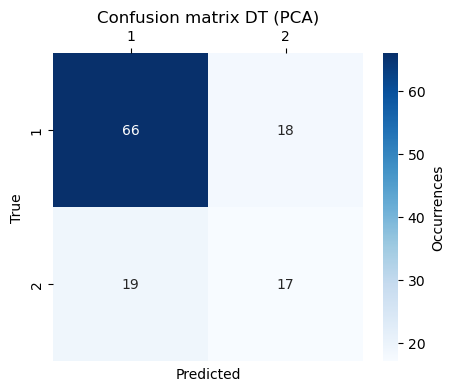

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.69
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.63


In [87]:
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT)
dt.fit(Xpca_train, y_train)

preds = dt.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = dt.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'DT (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.4 Random Forest

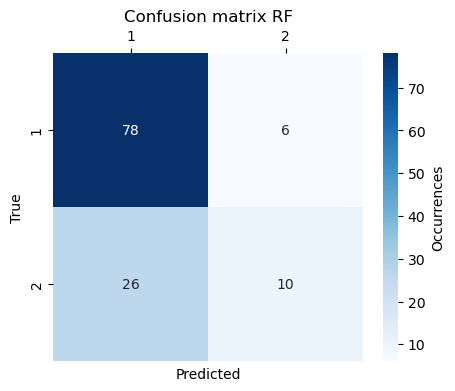

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.73
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.60


In [56]:
rf = RandomForestClassifier(class_weight=CLASS_WEIGHT)
rf.fit(X_train, y_train)

preds = rf.predict(X_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = rf.predict(X_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'RF')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

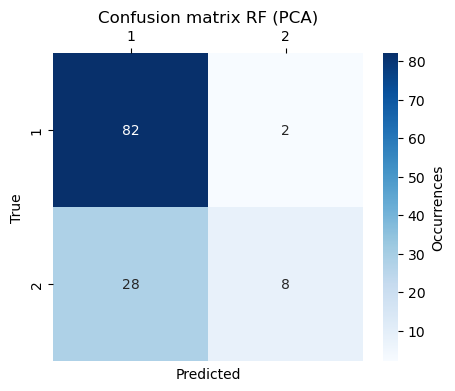

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 1.00 - Validation accuracy: 0.75
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.60


In [57]:
rf = RandomForestClassifier(class_weight=CLASS_WEIGHT)
rf.fit(Xpca_train, y_train)

preds = rf.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = rf.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'RF (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.5 k-NN

In [15]:
from kmodes.util.dissim import euclidean_dissim, jaccard_dissim_binary

def custom_distance_metric(a_num, a_cat, b_num, b_cat, g):
    return euclidean_dissim(a_num, b_num) + g * jaccard_dissim_binary(a_cat, b_cat)

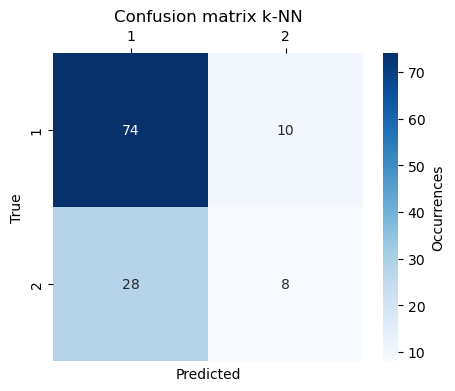

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.79 - Validation accuracy: 0.68
Train accuracy (balanced): 0.68 - Validation accuracy (balanced): 0.55


In [16]:
_non_categorical_indexer = X_train.columns.get_indexer(non_categorical_features).tolist()
_categorical_indexer = X_train.columns.get_indexer(categorical_features_hotencoded).tolist()
_gamma = 0.5 * np.mean(X_train.loc[:,non_categorical_features].std(axis=0))
X_train_distances = np.array([custom_distance_metric(
    X_train.to_numpy()[:,_non_categorical_indexer],
    X_train.to_numpy()[:,_categorical_indexer].astype(int),
    X_train.to_numpy()[i,_non_categorical_indexer],
    X_train.to_numpy()[i,_categorical_indexer].astype(int),
    _gamma
) for i in range(len(X_train))])
X_val_distances = np.array([custom_distance_metric(
    X_train.to_numpy()[:,_non_categorical_indexer],
    X_train.to_numpy()[:,_categorical_indexer].astype(int),
    X_val.to_numpy()[i,_non_categorical_indexer],
    X_val.to_numpy()[i,_categorical_indexer].astype(int),
    _gamma
) for i in range(len(X_val))])

knn = KNeighborsClassifier(metric='precomputed')
knn.fit(X_train_distances, y_train)

preds = knn.predict(X_train_distances)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = knn.predict(X_val_distances)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'k-NN')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

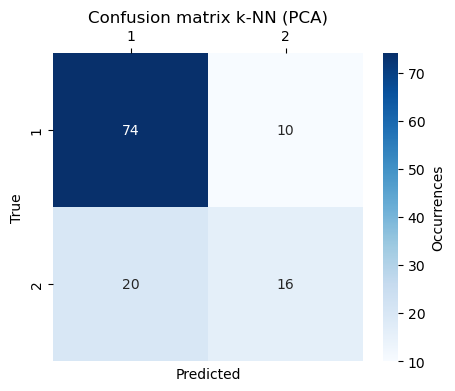

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy: 0.80 - Validation accuracy: 0.75
Train accuracy (balanced): 0.72 - Validation accuracy (balanced): 0.66


In [52]:
knn = KNeighborsClassifier()
knn.fit(Xpca_train, y_train)

preds = knn.predict(Xpca_train)
bal_acc_train = balanced_accuracy_score(y_train, preds)
acc_train = accuracy_score(y_train, preds)
preds = knn.predict(Xpca_val)
bal_acc_val = balanced_accuracy_score(y_val, preds)
acc_val = accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'k-NN (PCA)')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy: {acc_train:.2f} - Validation accuracy: {acc_val:.2f}')
print(f'Train accuracy (balanced): {bal_acc_train:.2f} - Validation accuracy (balanced): {bal_acc_val:.2f}')

#### 3.1.6 Neural Network

In [88]:
import tqdm.keras as tk

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.special import expit

def plot_roc_curve(fpr, tpr, optimal_idx=None):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    if optimal_idx:
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='optimal')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
def plot_validation_curve(nn_history):
    x = list(range(len(nn_history.history['loss'])))
    plt.plot(x, nn_history.history['loss'], label='training loss')
    plt.plot(x, nn_history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Weighted Binary Cross-Entropy Loss')
    plt.title('Validation Curve')
    plt.legend()
    plt.show()


def get_model_threshold(model, X, y):
    y_pred = expit(np.squeeze(model.predict(X)))
    fpr, tpr, thresholds = roc_curve(y,y_pred)
    return thresholds[np.argmax(tpr-fpr)]


def score_to_label(y_score, threshold):
    return (expit(y_score) > threshold).astype(int) + 1

Fit model on training data


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

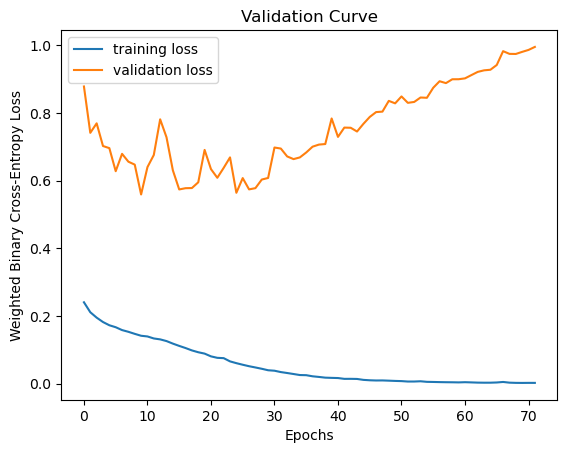

In [92]:
nn = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],), name='input'),
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1, name='output')
])
nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'accuracy'
    ]
)

print("Fit model on training data")
nn_history = nn.fit(
    X_train,
    y_train-1,
    batch_size=30,
    epochs=200,
    validation_data=(X_val, y_val-1),
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        tk.TqdmCallback(),
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch=50)
    ],
    verbose=0
)
plot_validation_curve(nn_history)

4/4 [==============================] - 0s 2ms/step


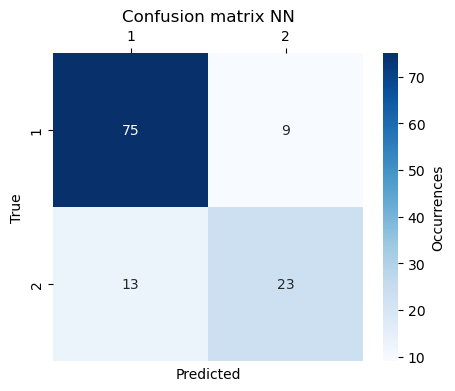

[680 TRAIN POINTS - 120 VALIDATION POINTS]
Train accuracy (balanced): 1.00 - Validation accuracy (balanced): 0.77


In [93]:
optimal_threshold = get_model_threshold(nn, X, y-1)

preds = score_to_label(nn.predict(X_train), optimal_threshold)
acc_train = balanced_accuracy_score(y_train, preds)
preds = score_to_label(nn.predict(X_val), optimal_threshold)
acc_val = balanced_accuracy_score(y_val, preds)
plot_confusion_matrix(y_val, preds, 'NN')
print(f'[{len(y_train)} TRAIN POINTS - {len(y_val)} VALIDATION POINTS]')
print(f'Train accuracy (balanced): {acc_train:.2f} - Validation accuracy (balanced): {acc_val:.2f}')

In [94]:
nn.save('experimental-nn.keras')

### 3.2 Cross Validation

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report

In [36]:
# Define common grid-search with cross-validation and performance evaluation process
def hyperparam_tuning_process(model, param_grid, X, y, model_name, scoring='accuracy'):
    gscv = GridSearchCV(model, param_grid=param_grid, scoring=scoring, return_train_score=True, n_jobs=-1, cv=StratifiedShuffleSplit(train_size=.85, random_state=RANDOM_STATE))
    gscv.fit(X, y)
    
    best_param_set = gscv.best_params_
    
    param_names = param_grid.keys()
    params_x = [str([_p[pname] for pname in param_names]) for _p in gscv.cv_results_['params']]

    plt.figure(figsize=(15,8))
    plt.plot(params_x, gscv.cv_results_['mean_train_score'], color='blue', label='train')
    plt.fill_between(
        params_x,
        gscv.cv_results_['mean_train_score'] - gscv.cv_results_['std_train_score'],
        gscv.cv_results_['mean_train_score'] + gscv.cv_results_['std_train_score'],
        color='blue', alpha=.3
    )
    plt.plot(params_x, gscv.cv_results_['mean_test_score'], color='red', label='val')
    plt.fill_between(
        params_x,
        gscv.cv_results_['mean_test_score'] - gscv.cv_results_['std_test_score'],
        gscv.cv_results_['mean_test_score'] + gscv.cv_results_['std_test_score'],
        color='red', alpha=.3
    )
    plt.legend()
    plt.grid()
    plt.xlabel('Parameter combinations')
    plt.xticks(rotation=90)
    plt.ylabel(scoring)
    plt.ylim(0, 1)
    plt.title(f'Grid search - `{model_name}`')
    plt.show()
    
    return gscv.best_params_, gscv.best_score_

#### 3.2.1 Decision Tree

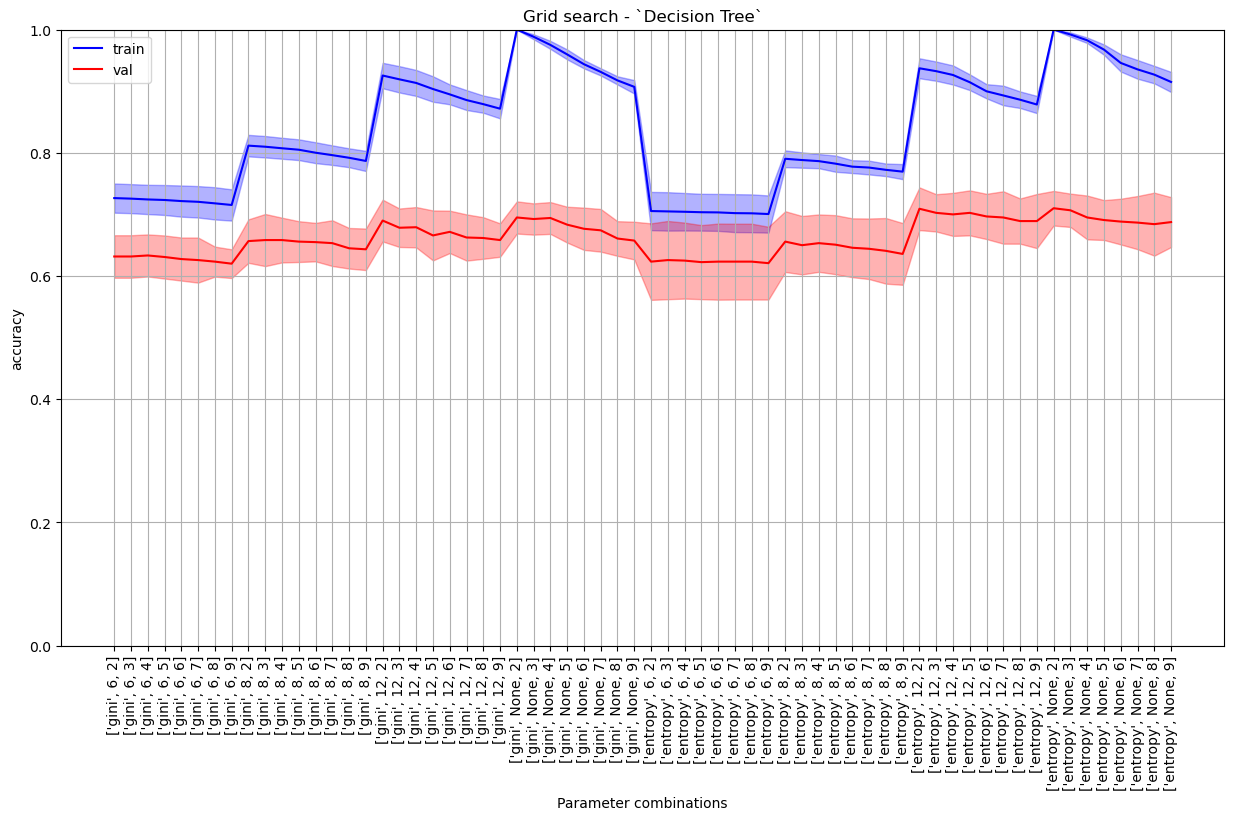

Decision Tree - Grid search results
Best set of params is:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
With validation score of 0.7100000000000001


In [37]:
param_grid = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [6,8,12,None],
    "min_samples_split": np.arange(2,10,1)
}
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE)
best_p_dt, score = hyperparam_tuning_process(dt, param_grid, X, y, 'Decision Tree', scoring='accuracy')

print('Decision Tree - Grid search results')
print('Best set of params is:')
print(best_p_dt)
print(f'With validation score of {score}')

              precision    recall  f1-score   support

           1       0.82      0.88      0.85        84
           2       0.67      0.56      0.61        36

    accuracy                           0.78       120
   macro avg       0.74      0.72      0.73       120
weighted avg       0.78      0.78      0.78       120



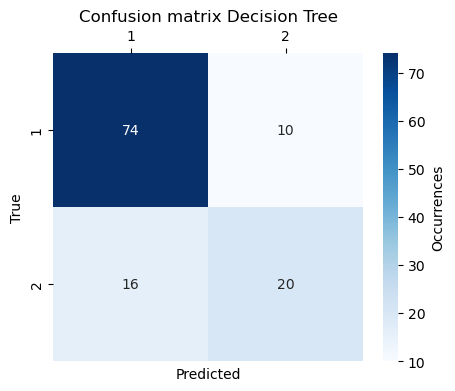

In [38]:
dt = DecisionTreeClassifier(class_weight=CLASS_WEIGHT, **best_p_dt, random_state=RANDOM_STATE)
dt.fit(X_train,y_train)
preds = dt.predict(X_val)

print(classification_report(y_val, preds))
plot_confusion_matrix(y_val, preds, 'Decision Tree')

#### 3.2.2 LinearSVC

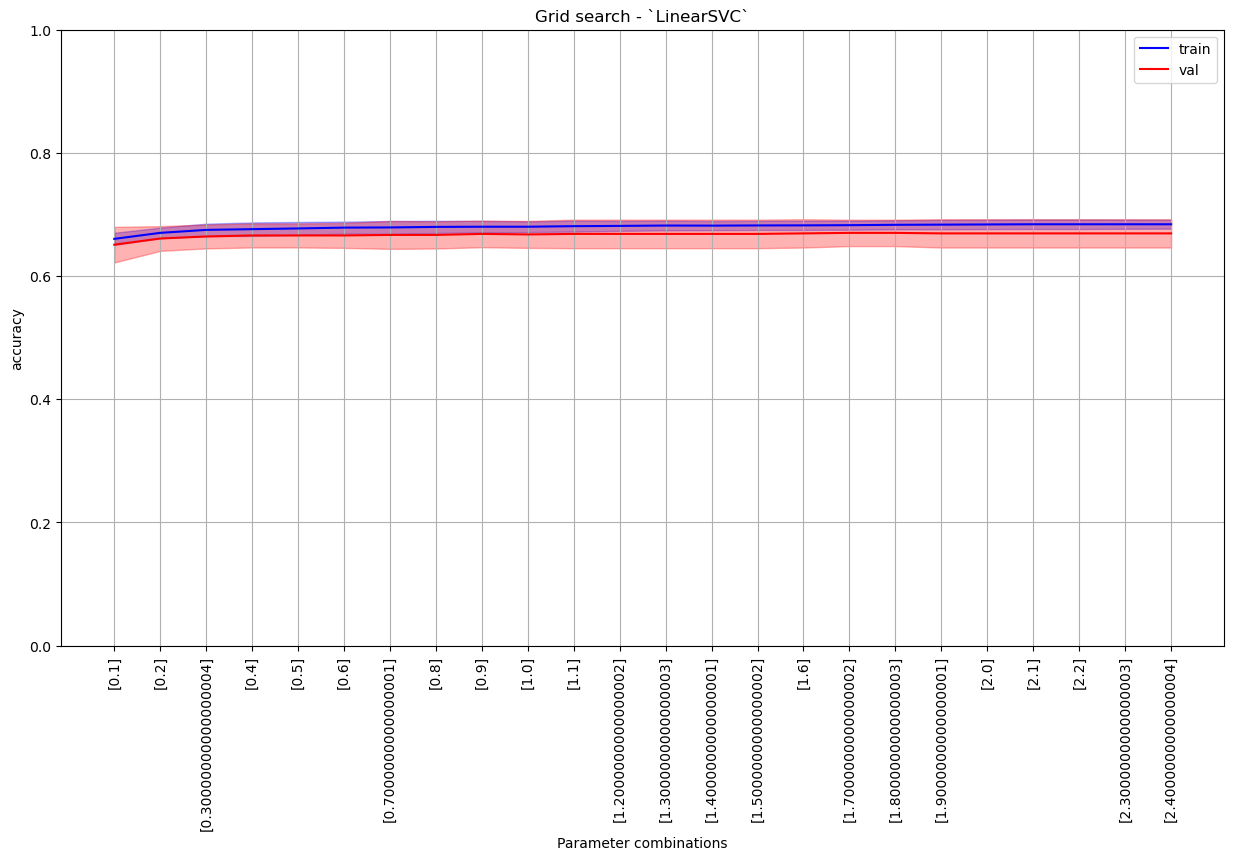

LinearSVC - Grid search results
Best set of params is:
{'C': 1.7000000000000002}
With validation score of 0.67


In [39]:
param_grid = {
    "C": np.arange(0.1,2.5,0.1)
}
svc = LinearSVC(class_weight=CLASS_WEIGHT)
best_p_svc, score = hyperparam_tuning_process(svc, param_grid, X, y, 'LinearSVC', scoring='accuracy')

print('LinearSVC - Grid search results')
print('Best set of params is:')
print(best_p_svc)
print(f'With validation score of {score}')

              precision    recall  f1-score   support

           1       0.82      0.88      0.85        84
           2       0.67      0.56      0.61        36

    accuracy                           0.78       120
   macro avg       0.74      0.72      0.73       120
weighted avg       0.78      0.78      0.78       120



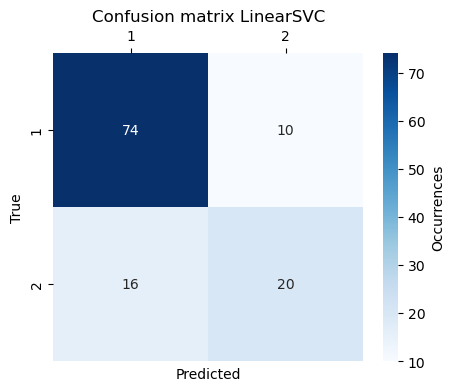

In [40]:
svc = LinearSVC(class_weight=CLASS_WEIGHT, **best_p_svc)
svc.fit(X_train,y_train)
preds = dt.predict(X_val)

print(classification_report(y_val, preds))
plot_confusion_matrix(y_val, preds, 'LinearSVC')

#### 3.2.3 Neural Network

In [96]:
from scipy.special import expit
import keras_tuner as kt

In [97]:
def model_builder(hp):
    hp_l1_units = hp.Int('l1_units', min_value=10, max_value=10, step=5)
    hp_l2_units = hp.Int('l2_units', min_value=35, max_value=35, step=5)
    model = keras.Sequential([
        keras.layers.Input(shape=(X.shape[1],), name='input'),
        keras.layers.Dense(units=hp_l1_units, activation='relu'),
        keras.layers.Dense(units=hp_l2_units, activation='relu'),
        keras.layers.Dense(1, name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

class GridSearchKerasCV(kt.GridSearch):
    def __init__(self,
        hypermodel=None,
        objective=None,
        max_trials=None,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        cv = None,
        **kwargs,
    ):
        self.cv = cv
        self.objective = objective
        super().__init__(
            **kwargs
        )
        
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        obj_results = []
        for i, (train_index, test_index) in enumerate(self.cv.split(fit_kwargs.get("x"), fit_kwargs.get("y"))):
            trainX = fit_kwargs.get("x").iloc[train_index]
            trainy = fit_kwargs.get("y").iloc[train_index]
            valX = fit_kwargs.get("x").iloc[test_index]
            valy = fit_kwargs.get("y").iloc[test_index]
            copied_kwargs = copy.copy(fit_kwargs)
            copied_kwargs["x"] = trainX
            copied_kwargs["y"] = trainy
            copied_kwargs["validation_data"] = (valX,valy)
            copied_kwargs["verbose"] = 0
            
            model = model_builder(trial.hyperparameters)
            history = model.fit(**copied_kwargs)
            
            thr = get_model_threshold(model, fit_kwargs.get("x"), fit_kwargs.get("y"))
            preds = score_to_label(model.predict(valX), thr)-1
            acc = balanced_accuracy_score(valy, preds)
            obj_results.append(acc)
            
        return [-np.mean(obj_results)] # to maximize balanced_accuracy

tuner = GridSearchKerasCV(
    model_builder,
    objective='default_objective', # objective is balanced_accuracy, computed inside run_trial()
    seed=RANDOM_STATE,
    #max_trials=,
    #overwrite = True,
    project_name='nn_tuning',
    cv=StratifiedShuffleSplit(n_splits=5, train_size=.85, random_state=RANDOM_STATE)
)

Reloading Tuner from ./nn_tuning/tuner0.json


In [49]:
tuner.search(
    x=X,
    y=y-1,
    batch_size=30,
    epochs=150,
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=35)
    ]
)

Trial 1 Complete [00h 00m 23s]
default_objective: -0.7535714285714284

Best default_objective So Far: -0.7535714285714284
Total elapsed time: 00h 00m 23s


In [98]:
best_hps_org = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_org.values

{'l1_units': 10, 'l2_units': 35}

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                620       
                                                                 
 dense_5 (Dense)             (None, 35)                385       
                                                                 
 output (Dense)              (None, 1)                 36        
                                                                 
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

4/4 [==============================] - 0s 2ms/step


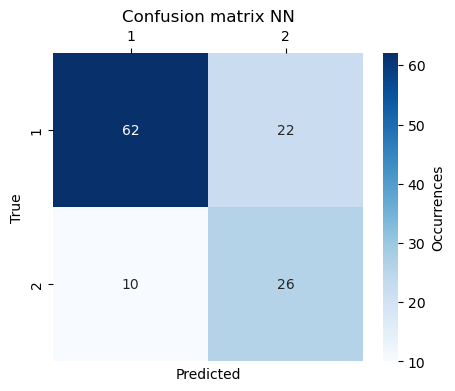

              precision    recall  f1-score   support

           1       0.86      0.74      0.79        84
           2       0.54      0.72      0.62        36

    accuracy                           0.73       120
   macro avg       0.70      0.73      0.71       120
weighted avg       0.77      0.73      0.74       120



In [99]:
model = model_builder(best_hps_org)
model.summary()

model.fit(
    X_train,
    y_train-1,
    batch_size=30,
    epochs=150,
    validation_data=(X_val, y_val-1),
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        tk.TqdmCallback(),
        keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=35)
    ],
    verbose=0
)

optimal_threshold = get_model_threshold(model, X, y-1)
preds = score_to_label(model.predict(X_val), optimal_threshold)
plot_confusion_matrix(y_val, preds, 'NN')
print(classification_report(y_val, preds))

In [59]:
model.save('best-nn.keras')
with open('best-nn.threshold','w') as f:
    f.write(str(optimal_threshold))

### 3.3 Classifier Evaluation

In [100]:
def evaluate_best_model_performance(X, y, only_score=False, scoring=None):
    if not scoring:
        scoring = accuracy_score
        
    bmodel = tf.keras.models.load_model('best-nn.keras')
    with open('best-nn.threshold') as f:
        bthreshold = float(f.read())
    
    test_scores = bmodel.predict(X, verbose=0)
    test_preds = score_to_label(test_scores, bthreshold)
    
    if only_score:
        return scoring(y,test_preds)
        
    plot_confusion_matrix(y, test_preds, 'Best Classifier (NN)')
    print(classification_report(y, test_preds))

    fpr, tpr, thrs = roc_curve(y,test_scores, pos_label=2)
    plot_roc_curve(fpr, tpr)

    auc = roc_auc_score(y, test_scores)
    print(f"AUC score: {auc}")
    return scoring(y,test_preds)

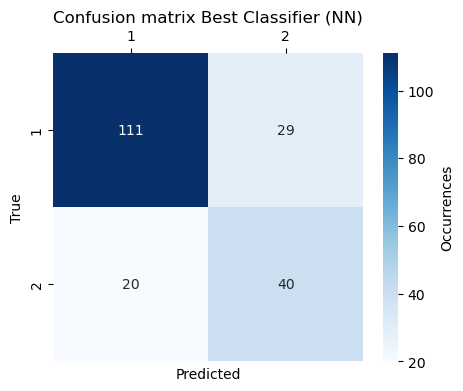

              precision    recall  f1-score   support

           1       0.85      0.79      0.82       140
           2       0.58      0.67      0.62        60

    accuracy                           0.76       200
   macro avg       0.71      0.73      0.72       200
weighted avg       0.77      0.76      0.76       200



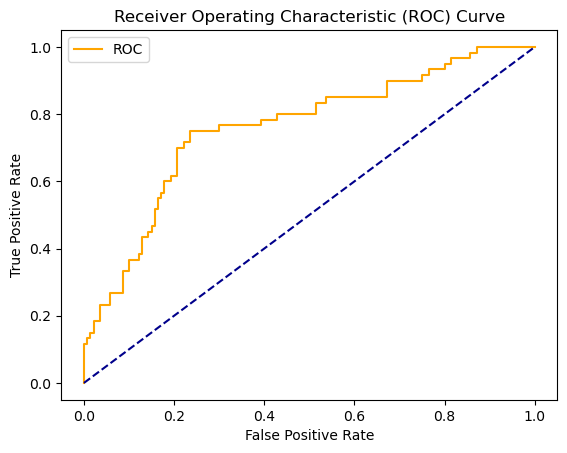

AUC score: 0.7594047619047619


0.7297619047619047

In [101]:
evaluate_best_model_performance(X_test, y_test, scoring=balanced_accuracy_score)

## 4 Adversarial Attacks

### 4.1 Random Noise

Consider noise a vector of RVs ~ $Normal(0,\sigma^2)$ of size $N$
We want to generate noise vectors to have L2 norm approximately equal to $\epsilon$

$E\left[\sqrt{\sum{X_i^2}}\right] < \epsilon $

as each dimension of the noise vector is uncorrelated to the other dimensions we can rewrite this as

$\sqrt{\sum{E\left[X_i^2\right]}} = \sqrt{\sum{\sigma^2}} < \epsilon$

so we choose $\sigma$ such that

$\sigma = \frac{\epsilon}{N}$

100%|██████████| 19/19 [00:36<00:00,  1.92s/it]


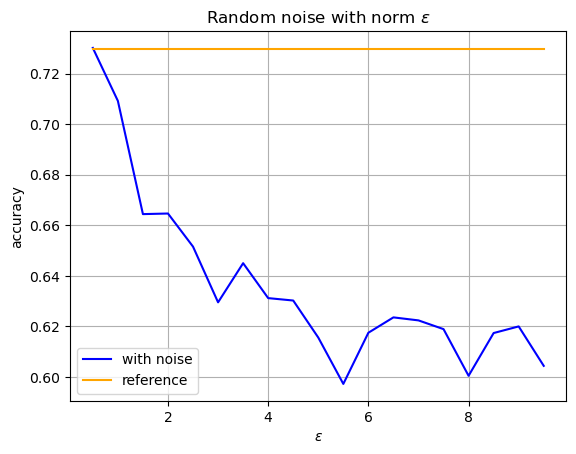

In [34]:
noisyy = y_test.copy()

ref_acc = evaluate_best_model_performance(X_test, y_test, only_score=True, scoring=balanced_accuracy_score)

eps_x = np.arange(0.5,10,0.5)
eps_acc = []

for eps in tqdm(eps_x):
    acc_vs = []
    for _ in range(10):
        noise = np.clip(np.random.normal(0, eps/math.sqrt(X_test.shape[1]),X_test.shape),-.5,.5)
        noisyX = X_test.copy() + noise
        acc = evaluate_best_model_performance(noisyX, noisyy, only_score=True, scoring=balanced_accuracy_score)
        acc_vs.append(acc)
    eps_acc.append(np.mean(acc_vs))

plt.plot(eps_x, eps_acc, color='blue', label='with noise')
plt.plot(eps_x, [ref_acc]*len(eps_x), color='orange', label='reference')
plt.title('Random noise with norm $\epsilon$')
plt.xlabel('$\epsilon$')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

### 4.2 Feature specific noise

2024-01-28 14:09:14.997635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-28 14:09:14.997709: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-28 14:09:14.997742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-s323351): /proc/driver/nvidia/version does not exist
2024-01-28 14:09:14.998174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 61/61 [19:49<00:00, 19.51s/it]


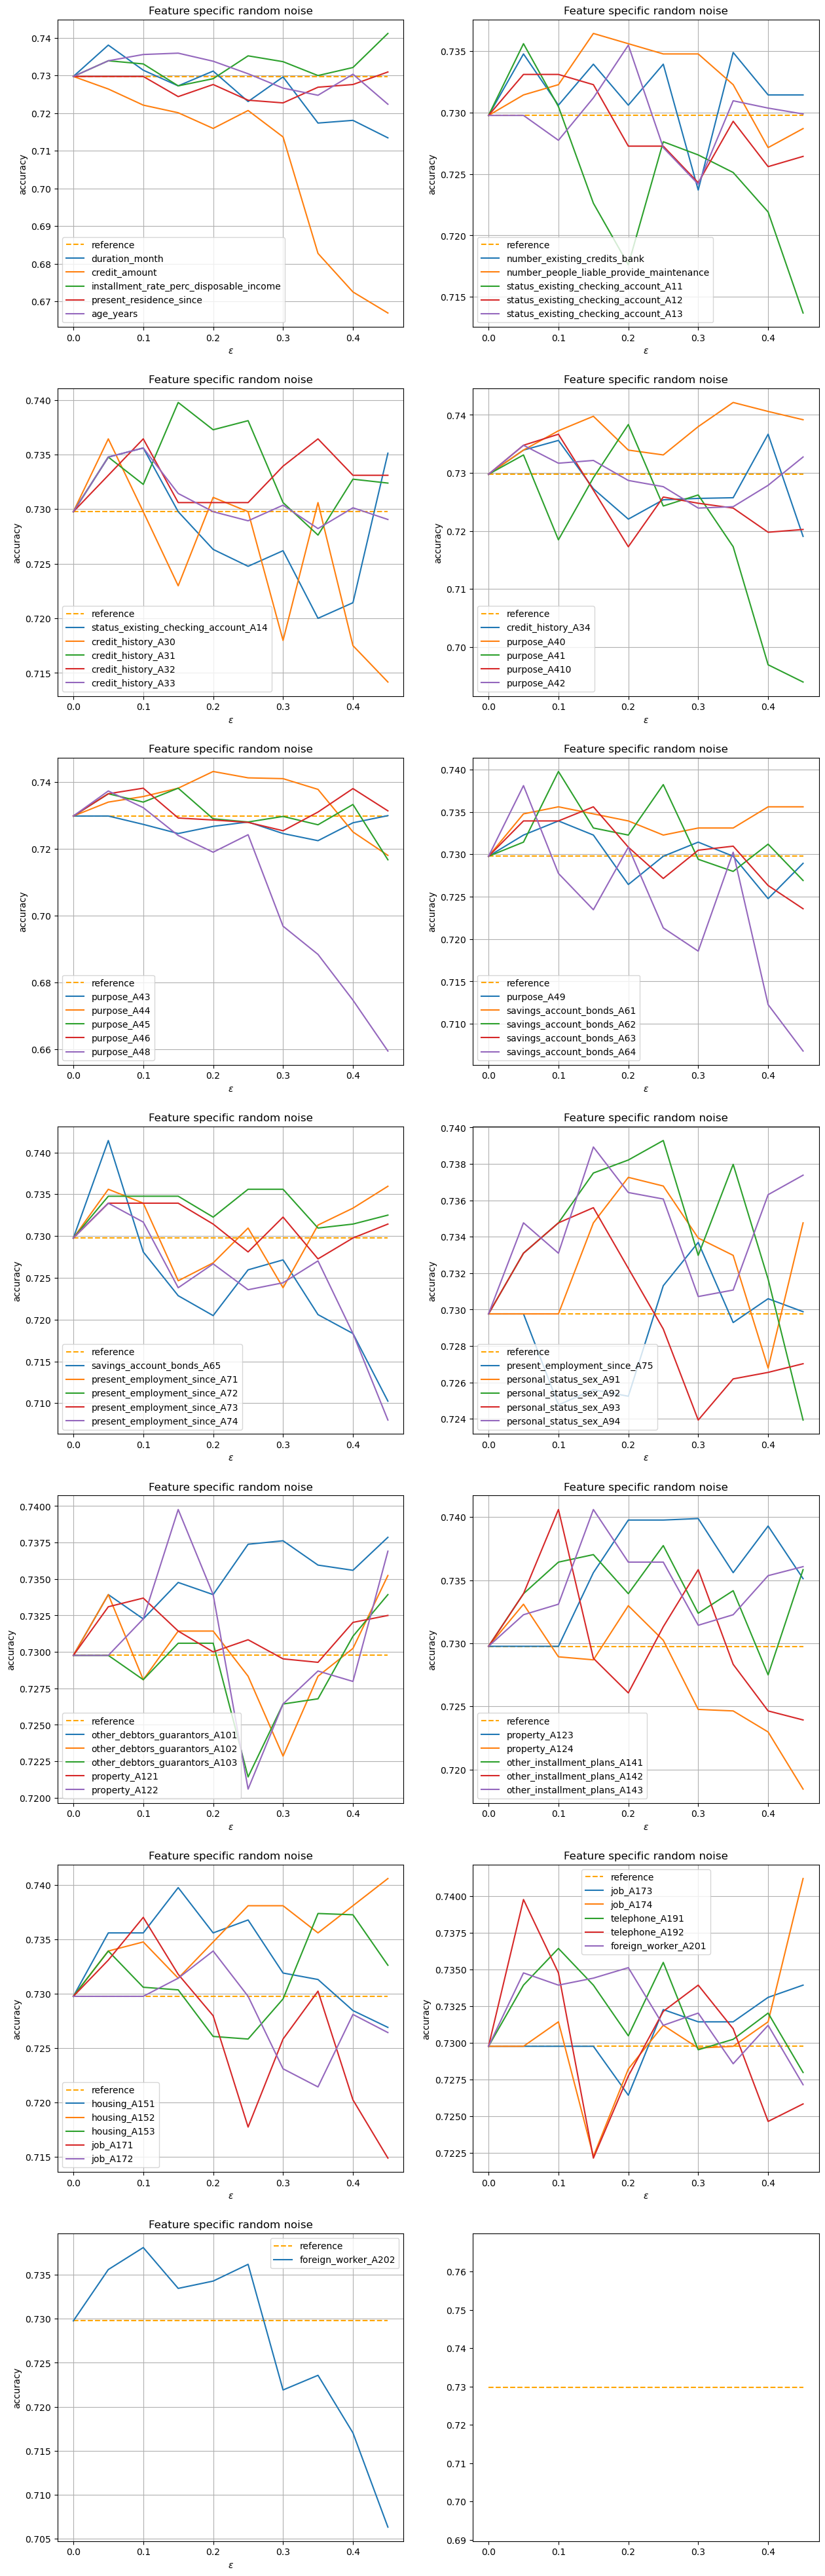

In [24]:
noisyy = y_test.copy()

ref_acc = evaluate_best_model_performance(X_test, y_test, only_score=True, scoring=balanced_accuracy_score)
eps_x = np.arange(0,.5,0.05)

fig, axs = plt.subplots(len(X_test.columns)//10+1,2, figsize=(15,50))
for _ in axs:
    for ax in _:
        ax.plot(eps_x, [ref_acc]*len(eps_x), color='orange', label='reference', linestyle='--')
        
for i,c in enumerate(tqdm(X_test.columns)):
    eps_acc = []
    for eps in eps_x:
        acc_vs = []
        for _ in range(10):
            noise = np.random.normal(eps, 1e-3, X_test.shape[0]) * np.random.choice([-1,1], X_test.shape[0])
            noisyX = X_test.copy()
            noisyX.loc[:,c] += noise
            acc = evaluate_best_model_performance(noisyX, noisyy, only_score=True, scoring=balanced_accuracy_score)
            acc_vs.append(acc)
        eps_acc.append(np.mean(acc_vs))
    axs[i//10][(i//5)%2].plot(eps_x, eps_acc, label=c)
    axs[i//10][(i//5)%2].legend()
    axs[i//10][(i//5)%2].set_title('Feature specific random noise')
    axs[i//10][(i//5)%2].set_xlabel('$\epsilon$')
    axs[i//10][(i//5)%2].set_ylabel('accuracy')
    axs[i//10][(i//5)%2].grid()
plt.show()

### 4.3 Adversarial attacks with ART

In [24]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BoundaryAttack
tf.compat.v1.disable_eager_execution()

/opt/conda/lib/python3.7/site-packages/art/estimators/certification/__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


#### FastGradientSignMethod

In [27]:
bmodel = tf.keras.models.load_model('best-nn.keras')
with open('best-nn.threshold') as f:
    bthreshold = float(f.read())
classifier = KerasClassifier(model=bmodel)

2024-01-28 15:03:38.453799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-01-28 15:03:38.464684: W tensorflow/c/c_api.cc:291] Operation '{name:'output/bias/Assign' id:68 op device:{requested: '', assigned: ''} def:{{{node output/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output/bias, output/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 15:03:38.613911: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673/kernel/v/Assign' id:224 op device:{requested: '', assigned: ''} def:{{{node dense_673/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673/kernel/v, dense_673/kernel/v/Initializer/zero

In [ ]:
eps_x = np.arange(.0,.2,.005)
eps_accs = []
for eps in tqdm(eps_x):
    attack = FastGradientMethod(estimator=classifier, norm=np.inf, eps=eps)
    x_test_adv = attack.generate(x=X_test.to_numpy())
    acc = evaluate_best_model_performance(x_test_adv, y_test, only_score=True, scoring=balanced_accuracy_score)
    eps_accs.append(acc)

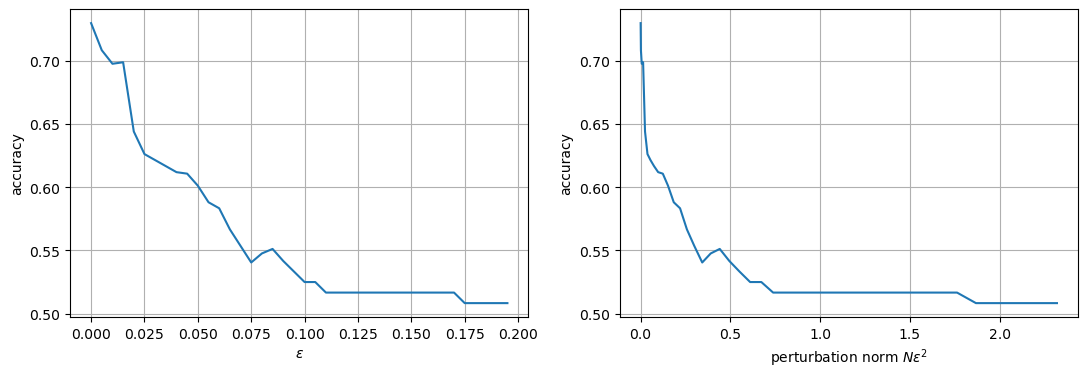

In [88]:
fig,axs = plt.subplots(1,2, figsize=(13,4))
axs[0].plot(eps_x,eps_accs)
axs[0].grid()
axs[0].set_xlabel('$\epsilon$')
axs[0].set_ylabel('accuracy')

axs[1].plot(len(X_test.columns)*(eps_x**2),eps_accs)
axs[1].grid()
axs[1].set_xlabel('perturbation norm $N\epsilon^2$')
axs[1].set_ylabel('accuracy')
plt.show()

2024-01-28 11:53:29.945519: W tensorflow/c/c_api.cc:291] Operation '{name:'output_68/bias/Assign' id:72369 op device:{requested: '', assigned: ''} def:{{{node output_68/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_68/bias, output_68/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 11:53:38.144274: W tensorflow/c/c_api.cc:291] Operation '{name:'output_68/bias/v/Assign' id:72540 op device:{requested: '', assigned: ''} def:{{{node output_68/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_68/bias/v, output_68/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an

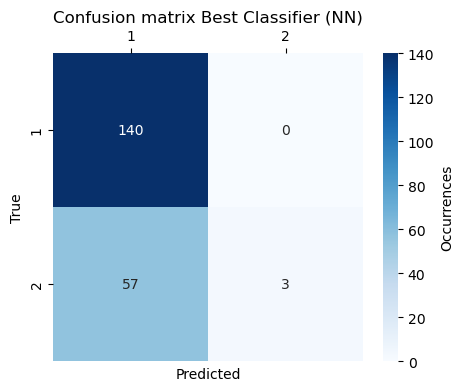

              precision    recall  f1-score   support

           1       0.71      1.00      0.83       140
           2       1.00      0.05      0.10        60

    accuracy                           0.71       200
   macro avg       0.86      0.53      0.46       200
weighted avg       0.80      0.71      0.61       200



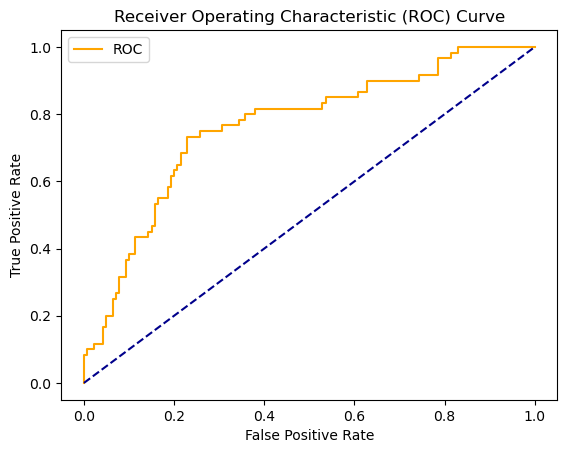

AUC score: 0.764047619047619


2024-01-28 11:53:55.784439: W tensorflow/c/c_api.cc:291] Operation '{name:'output_69/bias/Assign' id:72668 op device:{requested: '', assigned: ''} def:{{{node output_69/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_69/bias, output_69/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 11:54:05.741244: W tensorflow/c/c_api.cc:291] Operation '{name:'total_68/Assign' id:72702 op device:{requested: '', assigned: ''} def:{{{node total_68/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_68, total_68/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don

Balanced accuracy after attack: 0.53


In [71]:
attack = FastGradientMethod(estimator=classifier, norm=np.inf, eps=.1)
x_test_adv = attack.generate(x=X_test.to_numpy())
evaluate_best_model_performance(x_test_adv, y_test)
acc = evaluate_best_model_performance(x_test_adv, y_test, only_score=True, scoring=balanced_accuracy_score)
print(f"Balanced accuracy after attack: {acc:.2f}")

#### Projected Gradient Descent

In [ ]:
bmodel = tf.keras.models.load_model('best-nn.keras')
with open('best-nn.threshold') as f:
    bthreshold = float(f.read())
classifier = KerasClassifier(model=bmodel)

In [ ]:
eps_x = np.arange(.0,.2,.005)
eps_accs_pgd = []
for eps in tqdm(eps_x):
    attack =ProjectedGradientDescent(estimator=classifier, eps=eps)
    x_test_adv = attack.generate(x=X_test.to_numpy())
    acc = evaluate_best_model_performance(x_test_adv, y_test, only_score=True, scoring=balanced_accuracy_score)
    eps_accs_pgd.append(acc)

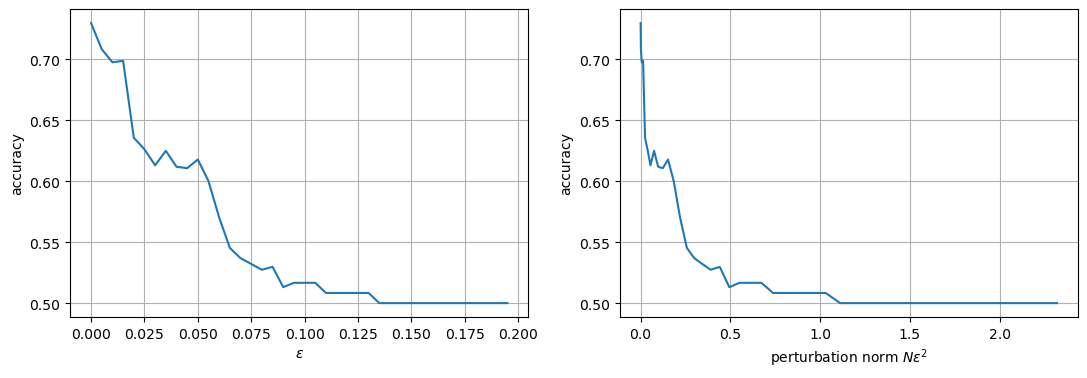

In [91]:
fig,axs = plt.subplots(1,2, figsize=(13,4))
axs[0].plot(eps_x,eps_accs_pgd)
axs[0].grid()
axs[0].set_xlabel('$\epsilon$')
axs[0].set_ylabel('accuracy')

axs[1].plot(len(X_test.columns)*(eps_x**2),eps_accs_pgd)
axs[1].grid()
axs[1].set_xlabel('perturbation norm $N\epsilon^2$')
axs[1].set_ylabel('accuracy')
plt.show()

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 15:03:48.666873: W tensorflow/c/c_api.cc:291] Operation '{name:'output/BiasAdd' id:73 op device:{requested: '', assigned: ''} def:{{{node output/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](output/MatMul, output/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

2024-01-28 15:03:50.076166: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673_1/kernel/Assign' id:472 op device:{requested: '', assigned: ''} def:{{{node dense_673_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673_1/kernel, dense_673_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 15:03:50.234807: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673_1/bias/v/Assign' id:662 op device:{requested: '', assigned: ''} def:{{{node dense_673_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673_1/bias/v, dense_673_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation w

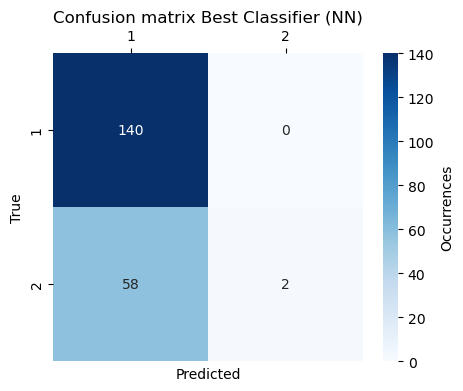

              precision    recall  f1-score   support

           1       0.71      1.00      0.83       140
           2       1.00      0.03      0.06        60

    accuracy                           0.71       200
   macro avg       0.85      0.52      0.45       200
weighted avg       0.79      0.71      0.60       200



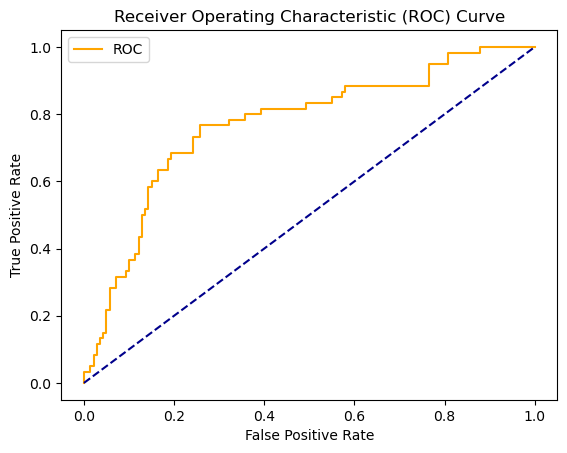

AUC score: 0.7690476190476191


2024-01-28 15:03:51.085410: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673_2/bias/Assign' id:776 op device:{requested: '', assigned: ''} def:{{{node dense_673_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673_2/bias, dense_673_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 15:03:51.397735: W tensorflow/c/c_api.cc:291] Operation '{name:'count_2/Assign' id:839 op device:{requested: '', assigned: ''} def:{{{node count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_2, count_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don

Balanced accuracy after attack: 0.52


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 15:03:51.629941: W tensorflow/c/c_api.cc:291] Operation '{name:'output_2/BiasAdd' id:805 op device:{requested: '', assigned: ''} def:{{{node output_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](output_2/MatMul, output_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [28]:
attack = ProjectedGradientDescent(estimator=classifier, eps=.1)
x_test_adv = attack.generate(x=X_test.to_numpy())
evaluate_best_model_performance(x_test_adv, y_test)
acc = evaluate_best_model_performance(x_test_adv, y_test, only_score=True, scoring=balanced_accuracy_score)
print(f"Balanced accuracy after attack: {acc:.2f}")

#### Boundary Attack

In [74]:
bmodel = tf.keras.models.load_model('best-nn.keras')
with open('best-nn.threshold') as f:
    bthreshold = float(f.read())

from art.estimators.classification import BlackBoxClassifier
def predict_fn(x):
    preds = score_to_label(bmodel.predict(x),bthreshold)
    return np.array(list(map(lambda x: np.array([1,0]) if x == 1 else np.array([0,1]), preds)))
bb_classifier = BlackBoxClassifier(
    predict_fn,
    input_shape=(len(X_test.columns),),
    nb_classes=2,
    clip_values=(0,1)
)

2024-01-28 16:06:17.717264: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673_13/kernel/Assign' id:4216 op device:{requested: '', assigned: ''} def:{{{node dense_673_13/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673_13/kernel, dense_673_13/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 16:06:18.092203: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673_13/bias/m/Assign' id:4376 op device:{requested: '', assigned: ''} def:{{{node dense_673_13/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_673_13/bias/m, dense_673_13/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This 

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 16:11:30.763173: W tensorflow/c/c_api.cc:291] Operation '{name:'output_13/BiasAdd' id:4250 op device:{requested: '', assigned: ''} def:{{{node output_13/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](output_13/MatMul, output_13/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 16:17:39.571026: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_673_14/kernel/Assign' id:4515 op device:{requested: '', assigned: ''} def:{{{node dense_673_14/kernel/Assign}} = AssignVariableOp[_h

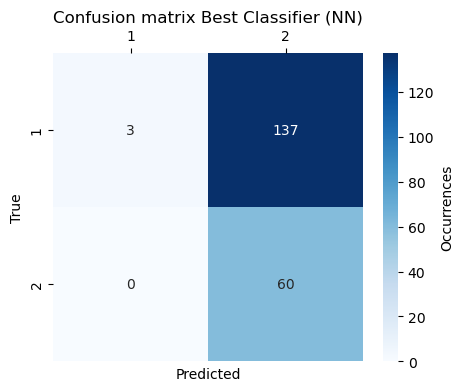

              precision    recall  f1-score   support

           1       1.00      0.02      0.04       140
           2       0.30      1.00      0.47        60

    accuracy                           0.32       200
   macro avg       0.65      0.51      0.25       200
weighted avg       0.79      0.32      0.17       200



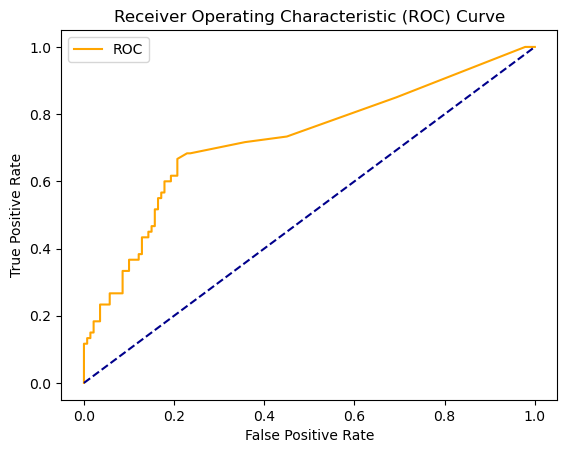

AUC score: 0.7248809523809524
Balanced accuracy after attack: 0.51


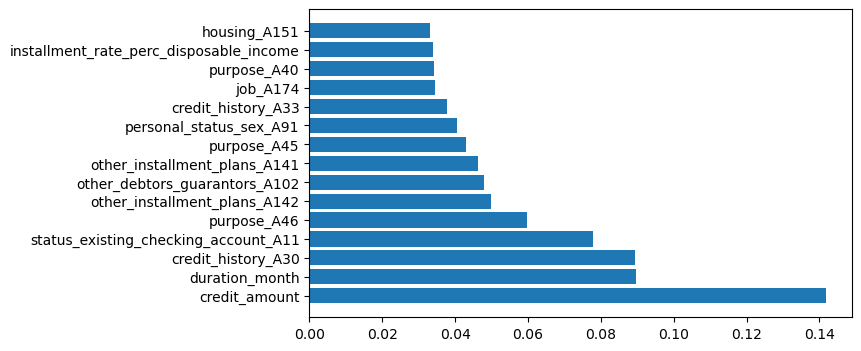

In [86]:
attack = BoundaryAttack(
    estimator=bb_classifier,
    batch_size=30,
    targeted=True,
    verbose=False)
x_test_adv = attack.generate(x=X_test.to_numpy(), y=np.array([np.array([0,1])]*len(X_test)))
acc = evaluate_best_model_performance(x_test_adv, y_test, scoring=balanced_accuracy_score)
print(f"Balanced accuracy after attack: {acc:.2f}")
top_features_diffs = (x_test_adv - X_test).mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(7,4))
plt.barh(top_features_diffs.index, width=top_features_diffs)
plt.show()

2024-01-28 16:20:14.648191: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_672_15/kernel/Assign' id:4790 op device:{requested: '', assigned: ''} def:{{{node dense_672_15/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_672_15/kernel, dense_672_15/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 16:20:15.045151: W tensorflow/c/c_api.cc:291] Operation '{name:'output_15/kernel/m/Assign' id:4979 op device:{requested: '', assigned: ''} def:{{{node output_15/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_15/kernel/m, output_15/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This muta

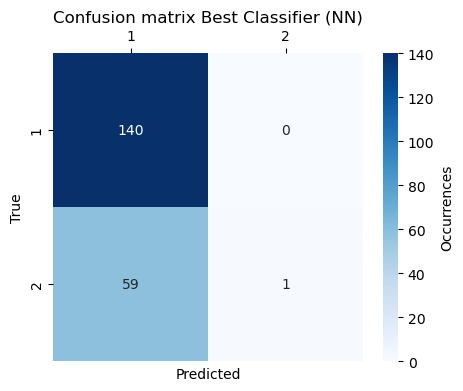

              precision    recall  f1-score   support

           1       0.70      1.00      0.83       140
           2       1.00      0.02      0.03        60

    accuracy                           0.70       200
   macro avg       0.85      0.51      0.43       200
weighted avg       0.79      0.70      0.59       200



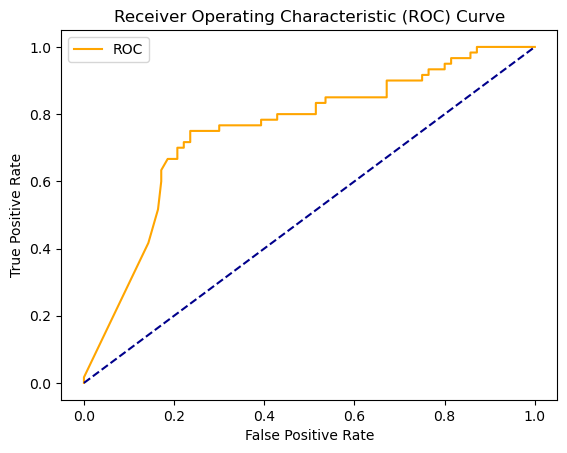

AUC score: 0.7526785714285714
Balanced accuracy after attack: 0.51


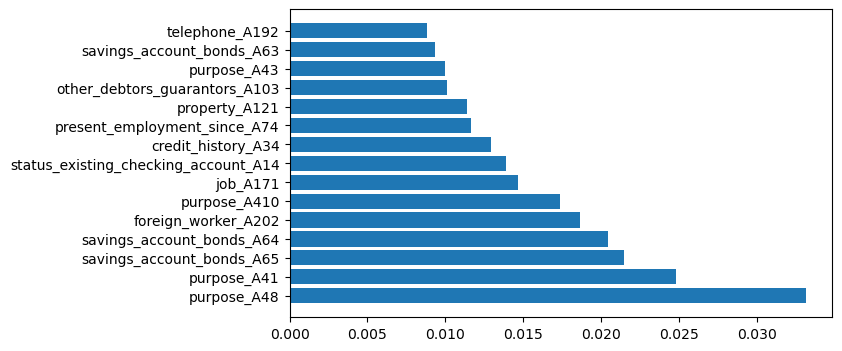

In [87]:
attack = BoundaryAttack(
    estimator=bb_classifier,
    batch_size=30,
    targeted=True,
    verbose=False)
x_test_adv = attack.generate(x=X_test.to_numpy(), y=np.array([np.array([1,0])]*len(X_test)))
acc = evaluate_best_model_performance(x_test_adv, y_test, scoring=balanced_accuracy_score)
print(f"Balanced accuracy after attack: {acc:.2f}")
top_features_diffs = (x_test_adv - X_test).mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(7,4))
plt.barh(top_features_diffs.index, width=top_features_diffs)
plt.show()

### 4.4 Countermeasure Exploration

#### FastGradientSignMethod adversarial training

In [25]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer

2024-01-28 21:27:06.699829: W tensorflow/c/c_api.cc:291] Operation '{name:'output_1/kernel/Assign' id:361 op device:{requested: '', assigned: ''} def:{{{node output_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_1/kernel, output_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-28 21:27:06.857316: W tensorflow/c/c_api.cc:291] Operation '{name:'iter_1/Assign' id:457 op device:{requested: '', assigned: ''} def:{{{node iter_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](iter_1, iter_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future.

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

2024-01-28 21:27:07.291101: W tensorflow/c/c_api.cc:291] Operation '{name:'output_2/kernel/Assign' id:793 op device:{requested: '', assigned: ''} def:{{{node output_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_2/kernel, output_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Adversarial training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

2024-01-28 21:27:07.668576: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/beta_1/Assign' id:1145 op device:{requested: '', assigned: ''} def:{{{node training/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/beta_1, training/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property 

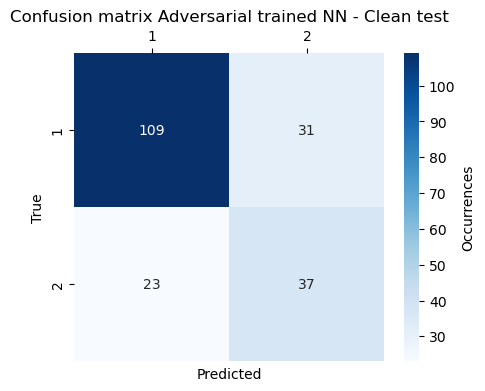

              precision    recall  f1-score   support

           1       0.83      0.78      0.80       140
           2       0.54      0.62      0.58        60

    accuracy                           0.73       200
   macro avg       0.68      0.70      0.69       200
weighted avg       0.74      0.73      0.73       200

Balanced accuracy after attack: 0.70


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 22:55:18.308942: W tensorflow/c/c_api.cc:291] Operation '{name:'output_1/BiasAdd' id:371 op device:{requested: '', assigned: ''} def:{{{node output_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](output_1/MatMul, output_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


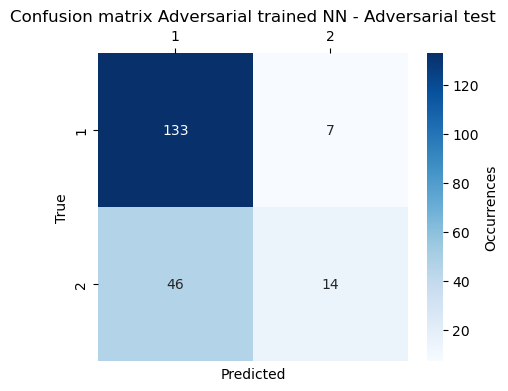

              precision    recall  f1-score   support

           1       0.74      0.95      0.83       140
           2       0.67      0.23      0.35        60

    accuracy                           0.73       200
   macro avg       0.70      0.59      0.59       200
weighted avg       0.72      0.73      0.69       200

Balanced accuracy after attack: 0.59


In [27]:
# clean model used to generate adversarial examples
modelA = tf.keras.models.load_model('best-nn.keras')
classifierA = KerasClassifier(model=modelA)

modelB = model_builder(best_hps_org)
classifierB = KerasClassifier(model=modelB)

attack = FastGradientMethod(estimator=classifierA, norm=np.inf, eps=.1)
trainer = AdversarialTrainer(
    classifierB,
    attacks=[attack],
)

trainer.fit(
    X_train.to_numpy(),y_train.to_numpy()-1,
    validation_data=(X_val.to_numpy(),y_val.to_numpy()-1),
    batch_size=64,
    nb_epochs=50,
    class_weight=CLASS_WEIGHT_NN,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch=50)
    ]
)
optimal_threshold = get_model_threshold(trainer, X, y-1)

# Clean test
test_scores = trainer.predict(X_test, verbose=0)
test_preds = score_to_label(test_scores, optimal_threshold)

plot_confusion_matrix(y_test, test_preds, 'Adversarial trained NN - Clean test')
print(classification_report(y_test, test_preds))
acc = balanced_accuracy_score(y_test, test_preds)
print(f"Balanced accuracy after attack: {acc:.2f}")

# Adversarial test
x_test_adv = attack.generate(x=X_test.to_numpy()) # generated against modelA
test_scores = trainer.predict(x_test_adv, verbose=0)
test_preds = score_to_label(test_scores, optimal_threshold)

plot_confusion_matrix(y_test, test_preds, 'Adversarial trained NN - Adversarial test')
print(classification_report(y_test, test_preds))
acc = balanced_accuracy_score(y_test, test_preds)
print(f"Balanced accuracy after attack: {acc:.2f}")

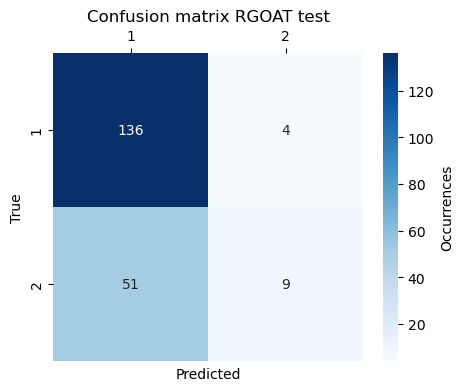

              precision    recall  f1-score   support

           1       0.73      0.97      0.83       140
           2       0.69      0.15      0.25        60

    accuracy                           0.73       200
   macro avg       0.71      0.56      0.54       200
weighted avg       0.72      0.72      0.66       200

Balanced accuracy after attack: 0.56


In [31]:
attack = FastGradientMethod(estimator=classifierB, norm=np.inf, eps=.1)
x_test_adv_rgoat = attack.generate(x=X_test.to_numpy())

test_scores = trainer.predict(x_test_adv_rgoat, verbose=0)
test_preds = score_to_label(test_scores, optimal_threshold)

plot_confusion_matrix(y_test, test_preds, 'RGOAT test')
print(classification_report(y_test, test_preds))
acc = balanced_accuracy_score(y_test, test_preds)
print(f"Balanced accuracy after attack: {acc:.2f}")